# Emulators: First example

This example illustrates Bayesian inference on a time series, using [Adaptive Covariance MCMC](http://pints.readthedocs.io/en/latest/mcmc_samplers/adaptive_covariance_mcmc.html) with emulator neural networks .

It follows on from [Sampling: First example](../sampling/first-example.ipynb)

Like in the sampling example, I start by importing pints:

In [1]:
import pints

C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passi

Next, I create a model class using the "Logistic" toy model included in pints:

In [2]:
import pints.toy as toy
model = toy.LogisticModel()

In order to generate some test data, I choose an arbitrary set of "true" parameters:

In [3]:
true_parameters = [0.015, 500]

And a number of time points at which to sample the time series:

In [4]:
import numpy as np
times = np.linspace(0, 1000, 400)

Using these parameters and time points, I generate an example dataset:

In [5]:
org_values = model.simulate(true_parameters, times)

And make it more realistic by adding gaussian noise:

In [6]:
noise = 5
values = org_values + np.random.normal(0, noise, org_values.shape)

Using matplotlib, I look at the noisy time series I just simulated:

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4.5))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values, label='Noisy data')
plt.plot(times, org_values, lw=2, label='Noise-free data')
plt.legend()
plt.show()

Now, I have enough data (a model, a list of times, and a list of values) to formulate a PINTS problem:

In [8]:
problem = pints.SingleOutputProblem(model, times, values)

I now have some toy data, and a model that can be used for forward simulations. To make it into a probabilistic problem, a _noise model_ needs to be added. This can be done using the `GaussianLogLikelihood` function, which assumes independently distributed Gaussian noise over the data, and can calculate log-likelihoods:

In [9]:
#log_likelihood = pints.GaussianLogLikelihood(problem)
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, noise)

This `log_likelihood` represents the _conditional probability_ $p(y|\theta)$, given a set of parameters $\theta$ and a series of $y=$ `values`, it can calculate the probability of finding those values if the real parameters are $\theta$.

This can be used in a Bayesian inference scheme to find the quantity of interest:

$p(\theta|y) = \frac{p(\theta)p(y|\theta)}{p(y)} \propto p(\theta)p(y|\theta)$

To solve this, a _prior_ is defined, indicating an initial guess about what the parameters should be. 
Similarly as using a _log-likelihood_ (the natural logarithm of a likelihood), this is defined by using a _log-prior_. Hence, the above equation simplifies to:

$\log p(\theta|y) \propto \log p(\theta) + \log p(y|\theta)$

In this example, it is assumed that we don't know too much about the prior except lower and upper bounds for each variable: We assume the first model parameter is somewhere on the interval $[0.01, 0.02]$, the second model parameter on $[400, 600]$, and the standard deviation of the noise is somewhere on $[1, 100]$.

In [10]:
# Create bounds for our parameters and get prior
bounds = pints.RectangularBoundaries([0.01, 400], [0.02, 600])
log_prior = pints.UniformLogPrior(bounds)

With this prior, the numerator of Bayes' rule can be defined -- the unnormalised log posterior, $\log \left[ p(y|\theta) p(\theta) \right]$, which is the natural logarithm of the likelihood times the prior:

In [11]:
# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

Finally we create a list of guesses to use as initial positions. We'll run three MCMC chains so we create three initial positions:

In [12]:
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]

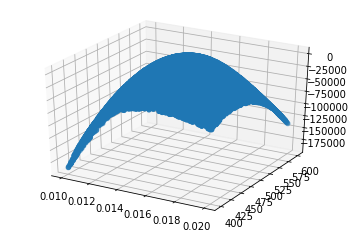

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

input_parameters = log_prior.sample(10000)
xs = [p[0] for p in input_parameters]
ys = [p[1] for p in input_parameters]
input_parameters[:5]

likelihoods = np.apply_along_axis(log_likelihood, 1, input_parameters)
likelihoods[:5]

#print(max(likelihoods))
#idx = list(likelihoods).index(max(likelihoods))
#print(input_parameters[idx])
#print(log_likelihood([0.015, 500]))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, list(likelihoods))
plt.show()

In [14]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(input_parameters, likelihoods, test_size=0.3, random_state=0)
emu = pints.MultiLayerNN(log_likelihood, X_train, y_train, input_scaler=MinMaxScaler(), output_scaler=StandardScaler())
emu.set_parameters(layers=6, neurons=64, hidden_activation='relu', activation='linear', learning_rate=0.0001)
hist = emu.fit(epochs=1000, batch_size=32, X_val=X_valid, y_val=y_valid, verbose=0)
#emu.summary()

In [15]:
emu([0.015, 500])

array([[-1266.3278]], dtype=float32)

In [16]:
log_likelihood([0.015, 500])

-1220.4552548106567

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


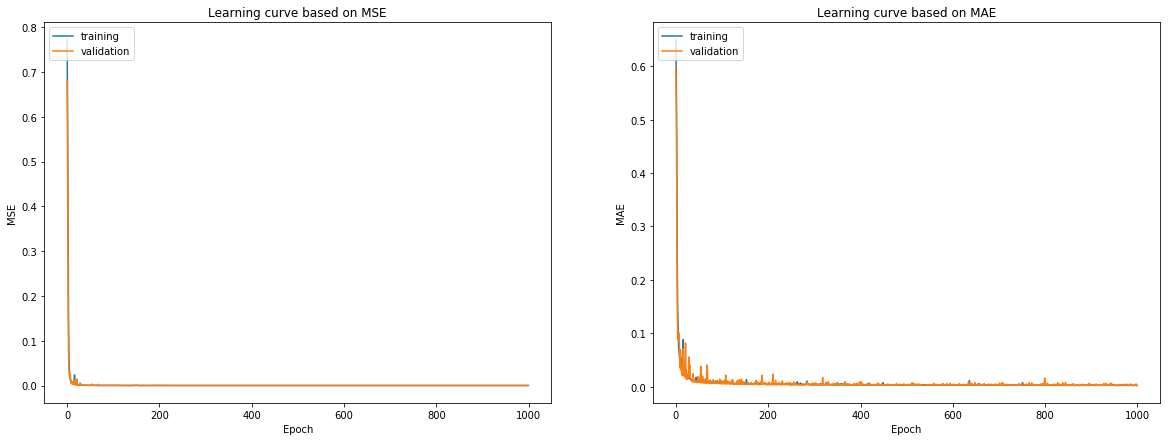

In [17]:
# summarize history for loss
print(hist.history.keys())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))                 
ax1.title.set_text('Learning curve based on MSE')
ax2.title.set_text('Learning curve based on MAE')

ax1.plot(hist.history['loss'])
ax1.plot(hist.history['val_loss'])
ax1.set_ylabel('MSE')
ax1.set_xlabel('Epoch')
ax1.legend(['training', 'validation'], loc='upper left')

ax2.plot(hist.history['mean_absolute_error'])
ax2.plot(hist.history['val_mean_absolute_error'])
ax2.set_ylabel('MAE')
ax2.set_xlabel('Epoch')
ax2.legend(['training', 'validation'], loc='upper left')

plt.show()

In [18]:
test_splits = 20 # number of splits along each axis
r_grid, k_grid, test_data = pints.generate_grid(bounds.lower(), bounds.upper(), test_splits)
model_prediction = pints.predict_grid(log_likelihood, test_data)

plt.figure(figsize = (10, 5))
ax = pints.plot.surface(r_grid, k_grid, model_prediction, title = "True log-likelihood",
                     x_label = "growth rate (r)",
                     y_label = "carrying capacity (k)")

In [19]:
emu_prediction = pints.predict_grid(emu, test_data)

plt.figure(figsize = (10, 5))
ax = pints.plot.surface(r_grid, k_grid, emu_prediction, title = "Multi-layer NN emulator log-likelihood",
                        x_label = "growth rate (r)",
                        y_label = "carrying capacity (k)")

In [20]:
# Create grid
test_splits = 100 # number of splits along each axis
xx, yy, test_data = pints.generate_grid(bounds.lower(), bounds.upper(), test_splits)
xmin, xmax = np.min(xx), np.max(xx)
ymin, ymax = np.min(yy), np.max(yy)
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

In [ ]:
# Create grid
test_splits = 100 # number of splits along each axis
xx, yy, test_data = pints.generate_grid([0.01495, 450], [0.01505, 550], test_splits)
xmin, xmax = np.min(xx), np.max(xx)
ymin, ymax = np.min(yy), np.max(yy)
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

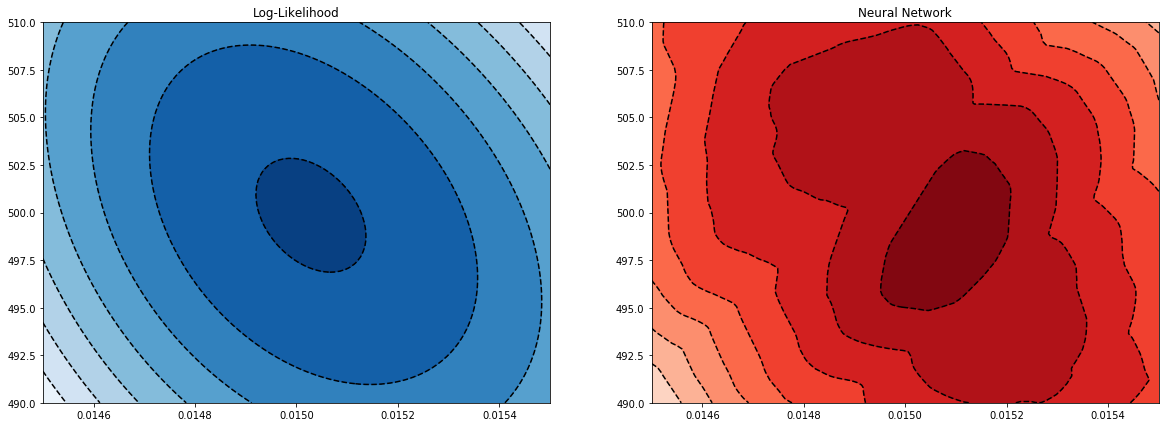

In [22]:
# Create grid
test_splits = 100 # number of splits along each axis
xx, yy, test_data = pints.generate_grid([0.0145, 490], [0.0155, 510], test_splits)
xmin, xmax = np.min(xx), np.max(xx)
ymin, ymax = np.min(yy), np.max(yy)
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

In [23]:
# Create grid
test_splits = 100 # number of splits along each axis
xx, yy, test_data = pints.generate_grid([0.01494, 498], [0.01504, 501], test_splits)
xmin, xmax = np.min(xx), np.max(xx)
ymin, ymax = np.min(yy), np.max(yy)
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

In [24]:
log_posterior_emu = pints.LogPosterior(emu, log_prior)
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]

Running...
[-1.00167647e-02  4.49956561e+02]
-inf


[2.27252750e-02 5.22505882e+02]
-inf


[1.28629757e-02 5.73415691e+02]
-25732.948536970725
accepted


[6.35582492e-05 4.50708210e+02]
-inf


[2.56577678e-02 5.26498599e+02]
-inf


[3.00718838e-02 5.72747345e+02]
-inf


[1.67617351e-02 4.47353615e+02]
-13660.102801433906
accepted


[7.85521577e-04 5.22547981e+02]
-inf


[-1.50478849e-02  5.70055616e+02]
-inf


[8.90203255e-03 4.54227676e+02]
-inf


[1.84680787e-02 5.28527305e+02]
-39876.877431891895


[2.00754246e-02 5.76260707e+02]
-inf


[-1.35459529e-02  4.45665947e+02]
-inf


[2.86481377e-02 5.27731287e+02]
-inf


[3.00444897e-02 5.71394681e+02]
-inf


[2.36028248e-02 4.46124822e+02]
-inf


[2.62184296e-03 5.24989387e+02]
-inf


[2.32489384e-02 5.74669944e+02]
-inf


[2.25003564e-02 4.47686022e+02]
-inf


[3.12125753e-02 5.25689475e+02]
-inf


[3.00997622e-02 5.70707356e+02]
-inf


[1.24385513e-02 4.49211354e+02]
-47024.48386473924


[1.17945814e-02 5.26520044e+02]
-41936.365278273

[1.10868772e-02 5.63650364e+02]
-66098.03471714808


[2.35000876e-03 4.48712758e+02]
-inf


[2.57374364e-02 5.18640805e+02]
-inf


[2.44020901e-02 5.60335127e+02]
-inf


[-8.63008109e-04  4.44917857e+02]
-inf


[2.06066341e-02 5.17421220e+02]
-inf


[2.46967019e-03 5.61672045e+02]
-inf


[2.32273390e-02 4.45442885e+02]
-inf


[1.01210087e-02 5.13785883e+02]
-119435.05272584334


[-6.10424368e-03  5.60053412e+02]
-inf


[-3.89579236e-03  4.47924687e+02]
-inf


[3.30004093e-02 5.17759575e+02]
-inf


[2.28639754e-02 5.59777825e+02]
-inf


[5.76748053e-03 4.46826331e+02]
-inf


[1.60434253e-02 5.15636871e+02]
-6536.371755629816


[1.57659374e-02 5.59678836e+02]
-21572.24642473323


[9.89139905e-03 4.49379528e+02]
-inf


[4.54105390e-03 5.11856443e+02]
-inf


[1.08264980e-02 5.57615503e+02]
-76435.77355198177


[8.52781251e-03 4.44841004e+02]
-inf


[1.94085036e-02 5.17086777e+02]
-48164.24543390559


[3.12470765e-02 5.63081020e+02]
-inf


[8.52085303e-04 4.49243260e+02]
-inf


[1.95604695e

[1.47616315e-02 4.53394445e+02]
-11203.14648612552


[1.54833521e-02 5.17111001e+02]
-3733.247191207256


[1.49143514e-02 5.52502382e+02]
-11945.359164783618


[1.65110658e-02 4.54015307e+02]
-10642.192407048204


[1.36359499e-02 5.16638313e+02]
-7339.621667177879


[1.56746920e-02 5.51640787e+02]
-16499.351603429095


[1.49805072e-02 4.52995797e+02]
-10413.219245835842


[1.78515098e-02 5.17030963e+02]
-25537.995259000545


[1.47791653e-02 5.48674613e+02]
-9962.05058642578
accepted


[1.42474725e-02 4.54342809e+02]
-14275.298987201493


[1.46962160e-02 5.17123564e+02]
-2297.282915588955


[1.65147242e-02 5.52237105e+02]
-25729.90331842942


[1.53599661e-02 4.53393235e+02]
-9300.55209832421


[1.5652522e-02 5.1737733e+02]
-4566.540504579104


[1.48577318e-02 5.48110243e+02]
-10001.31354344509


[1.66108901e-02 4.53078385e+02]
-11301.17012158359


[1.60490427e-02 5.17444751e+02]
-6988.665191156052


[1.36839308e-02 5.52192469e+02]
-12244.892567424278


[1.61778761e-02 4.53465812e+02]
-9

[1.48049966e-02 5.15539017e+02]
-2080.8848998619624


[1.51466726e-02 4.92845707e+02]
-1395.8140664238636


[1.64934701e-02 4.88651850e+02]
-6161.822660350821


[1.48103377e-02 5.15302406e+02]
-2055.0400957028446
accepted


[1.47460990e-02 5.08799083e+02]
-1588.016157458247


[1.60689114e-02 4.72143468e+02]
-5150.776378655289


[1.48119998e-02 5.15030690e+02]
-2026.2363336506721
accepted


[1.49468892e-02 4.99611205e+02]
-1241.4070158105571


[1.62116465e-02 4.76404433e+02]
-5145.987137173513


[1.48128315e-02 5.14673215e+02]
-1989.3095586628267
accepted


[1.48058303e-02 5.06912387e+02]
-1448.1156533990008


[1.63459716e-02 4.81968711e+02]
-5369.582810513845


[1.48179726e-02 5.14674422e+02]
-1988.8931772300537
accepted


[1.50873228e-02 4.96997542e+02]
-1249.3795451878602


[1.61130423e-02 4.72823391e+02]
-5202.51410571782


[1.48156068e-02 5.15161290e+02]
-2039.6838412180362


[1.51900841e-02 4.95750263e+02]
-1313.9789963485557


[1.61791825e-02 4.78649053e+02]
-4792.301105980557
ac

-1219.9773446405068
accepted


[1.50704053e-02 4.97810437e+02]
-1234.5358872597988


[1.50130840e-02 5.00172739e+02]
-1219.6781940052929
accepted


[1.50972672e-02 4.96959842e+02]
-1251.6728485571273


[1.50331222e-02 4.99276857e+02]
-1220.1760541369147
accepted


[1.53153305e-02 4.94952427e+02]
-1451.815924348357


[1.50619409e-02 4.99391294e+02]
-1222.1521127709632


[1.49929339e-02 5.00026821e+02]
-1222.408740558715


[1.47196948e-02 5.04593417e+02]
-1494.3037129836996


[1.50531700e-02 4.98736069e+02]
-1223.752191879401


[1.50245495e-02 4.99527453e+02]
-1219.535746548196
accepted


[1.50535041e-02 5.00090814e+02]
-1221.7382193520361


[1.50219045e-02 4.99521937e+02]
-1219.701068711559
accepted


[1.49685124e-02 5.01040471e+02]
-1229.9287438747394


[1.48661679e-02 5.02783062e+02]
-1297.475163086972


[1.50626451e-02 4.96719335e+02]
-1254.0044700932212


[1.49872692e-02 5.00439878e+02]
-1223.560060515707


[1.49888713e-02 5.00285489e+02]
-1223.095089340106


[1.50387866e-02 4.97311



[1.50458167e-02 4.98668330e+02]
-1223.9810468296355


[1.49880203e-02 4.99706981e+02]
-1224.5078213558866


[1.50493223e-02 5.00054190e+02]
-1220.916353993196


[1.50314862e-02 4.99666793e+02]
-1219.1027506829553
accepted


[1.49859317e-02 5.00371389e+02]
-1223.7703868297272


[1.50250854e-02 5.00169498e+02]
-1219.328079029796
accepted


[1.50073857e-02 5.00911746e+02]
-1223.0522351934496


[1.50323870e-02 4.99282817e+02]
-1220.162860888603


[1.50327626e-02 4.99894419e+02]
-1219.0695899983175
accepted


[1.50357800e-02 5.00580307e+02]
-1221.7887514580425


[1.50500821e-02 4.99253968e+02]
-1220.883958075788


[1.50209557e-02 5.00163863e+02]
-1219.3344987960036
accepted


[1.50235645e-02 4.99822646e+02]
-1219.0462913029512
accepted


[1.50240628e-02 4.99526647e+02]
-1219.562070010934
accepted


[1.50090156e-02 5.00679333e+02]
-1221.5717906308128


[1.49856882e-02 5.00322111e+02]
-1223.797841895357


[1.50647640e-02 4.99562315e+02]
-1222.654624654275


[1.50190212e-02 4.99779868e+02]
-

[1.49925324e-02 5.00180906e+02]
-1222.3553966805414


[1.50433549e-02 4.99730764e+02]
-1219.6230610426046
accepted


[1.50073890e-02 4.99732914e+02]
-1220.5472441157453


[1.49998945e-02 4.99941505e+02]
-1221.2451837133233
accepted


[1.50378880e-02 5.00385232e+02]
-1220.8708115237996


[1.49769383e-02 5.00560522e+02]
-1226.1529867781085


[1.50070320e-02 4.99327158e+02]
-1222.3703860750843


[1.50336426e-02 5.00375211e+02]
-1220.428814053667
accepted


[1.50250954e-02 4.99959145e+02]
-1219.0170158165845
accepted


[1.49761720e-02 5.00376194e+02]
-1226.2185815141224


[1.50747214e-02 4.99117928e+02]
-1225.1514605619152


[1.50264937e-02 4.99745752e+02]
-1219.0401308872792


[1.49828532e-02 5.00320666e+02]
-1224.4628310212108


[1.50347511e-02 5.00519536e+02]
-1221.3003185054292
accepted


[1.50030910e-02 5.00465683e+02]
-1221.1614419642299


[1.50258218e-02 4.99873515e+02]
-1218.9841057500323
accepted


[1.50301180e-02 5.00945174e+02]
-1224.0436585033212


[1.50325949e-02 4.99247643e+0

accepted


[1.49696339e-02 5.00130232e+02]
-1228.5743168860943


[1.50102945e-02 5.00027073e+02]
-1219.8066308767438
accepted


[1.50156709e-02 5.00255297e+02]
-1219.6872184046679
accepted


[1.50314604e-02 5.00347152e+02]
-1220.1472365356701
accepted


[1.50193284e-02 5.00048681e+02]
-1219.2163170262495
accepted


[1.50060349e-02 4.99811237e+02]
-1220.5456370595903
accepted


[1.50627306e-02 5.00613334e+02]
-1227.2737993308926


[1.50211505e-02 4.99293322e+02]
-1220.7140697927923


[1.49992770e-02 5.00478443e+02]
-1221.6394322957651
accepted


[1.50192100e-02 5.01568541e+02]
-1229.967842631839


[1.50019830e-02 5.00369169e+02]
-1221.0440555301282


[1.50466474e-02 4.98024476e+02]
-1230.9471660634188


[1.50218973e-02 4.99647339e+02]
-1219.362576491392
accepted


[1.50457175e-02 4.98643903e+02]
-1224.1834092068834


[1.50153045e-02 4.99397485e+02]
-1220.7937142410688
accepted


[1.5029451e-02 4.9920614e+02]
-1220.618111283243


[1.50315039e-02 4.99643833e+02]
-1219.1335279081845
accept

[1.50790957e-02 5.00114333e+02]
-1228.4683046196576


[1.50198603e-02 4.99916181e+02]
-1219.1472215117478
accepted


[1.50316281e-02 5.00033423e+02]
-1219.2018172198843
accepted


[1.50405670e-02 5.00175057e+02]
-1220.227139635372
accepted


[1.50212966e-02 4.99469961e+02]
-1219.9221689166052


[1.50104635e-02 5.00594233e+02]
-1221.0856637011475


[1.50147194e-02 4.99581093e+02]
-1220.1149886525461
accepted


[1.50398148e-02 4.99819670e+02]
-1219.3870027128291
accepted


[1.50459498e-02 4.99593657e+02]
-1219.8790977980216


[1.50008858e-02 5.00480982e+02]
-1221.450068159089
accepted


[1.50162640e-02 5.00917728e+02]
-1222.9844796193715


[1.50101508e-02 5.00688713e+02]
-1221.5692472668736


[1.50018652e-02 5.00317291e+02]
-1220.9627097626274
accepted


[1.50278661e-02 4.99601341e+02]
-1219.2364344365053
accepted


[1.50215816e-02 5.00445198e+02]
-1220.2112799558593


[1.50008233e-02 5.01552015e+02]
-1229.2172082456036


[1.50366904e-02 4.99465169e+02]
-1219.5537401134743


[1.5016472e-

[1.50564339e-02 4.99789539e+02]
-1221.36863077458


[1.50257517e-02 5.00089776e+02]
-1219.170426331124
accepted


[1.49836460e-02 4.98331473e+02]
-1240.0954401606093


[1.49928980e-02 4.99503558e+02]
-1224.3071226685113


[1.50135841e-02 5.00671593e+02]
-1221.3676731133219


[1.49506608e-02 4.99744524e+02]
-1238.4141415320398


[1.50565279e-02 4.99233876e+02]
-1221.6345475625717


[1.49975830e-02 5.00398705e+02]
-1221.6835210958336


[1.49724705e-02 4.99040657e+02]
-1234.9895906667405


[1.50635143e-02 4.98954495e+02]
-1223.5884635342247


[1.50495807e-02 5.00550977e+02]
-1223.662018145962


[1.49680320e-02 4.99764858e+02]
-1230.6561240752717


[1.49656273e-02 5.01219146e+02]
-1231.6872706832548


[1.50579050e-02 4.99483879e+02]
-1221.417750708961


[1.49693869e-02 4.99740277e+02]
-1230.2817218307457


[1.50515187e-02 4.99635092e+02]
-1220.4792042186427
accepted


[1.50104585e-02 5.00427406e+02]
-1220.432475356075


[1.50215814e-02 4.98071013e+02]
-1233.0257866282177


[1.50367890e-02 

[1.50205373e-02 4.98643971e+02]
-1225.8649756378977


[1.51130343e-02 5.00220686e+02]
-1244.471365209671


[1.49913475e-02 5.00943142e+02]
-1224.6905423773478


[1.49933060e-02 5.01339111e+02]
-1227.4556532484794


[1.50645329e-02 5.00334686e+02]
-1225.5319998594277


[1.49998286e-02 4.99419721e+02]
-1223.2046348143424


[1.50222876e-02 4.99990511e+02]
-1219.082111577904
accepted


[1.50236263e-02 5.02497113e+02]
-1246.603509388162


[1.50348609e-02 5.00217676e+02]
-1219.870676928239


[1.50271234e-02 5.01495030e+02]
-1229.8562647810077


[1.50329350e-02 5.00803789e+02]
-1223.125026739422


[1.49979082e-02 5.00257275e+02]
-1221.440424211144


[1.50644851e-02 4.96848508e+02]
-1251.0786825757489


[1.50827014e-02 4.98852203e+02]
-1227.866231320302


[1.50417036e-02 5.00434472e+02]
-1221.6000118398078


[1.50194551e-02 4.99509813e+02]
-1219.9198745980877


[1.50190564e-02 4.99909080e+02]
-1219.187113882185
accepted


[1.49956945e-02 5.00395964e+02]
-1221.9627708272785


[1.49687290e-02 5.

[1.50367868e-02 4.99399976e+02]
-1219.7333706792067
accepted


[1.50610622e-02 4.99574115e+02]
-1221.9453756781845


[1.49558636e-02 5.01319190e+02]
-1235.2668257450052


[1.50184864e-02 4.99948448e+02]
-1219.2100733125603
accepted


[1.50317541e-02 4.98002581e+02]
-1232.4574834740806


[1.49210512e-02 5.02230747e+02]
-1256.906073769186


[1.50332470e-02 5.00121681e+02]
-1219.4711017170102
accepted


[1.50729903e-02 4.99570886e+02]
-1224.5543237433121


[1.50374956e-02 4.98788866e+02]
-1223.0649541764465


[1.49638503e-02 5.01298650e+02]
-1232.6817023002093


[1.50669128e-02 4.99134364e+02]
-1223.5065767629899


[1.50681888e-02 4.99049323e+02]
-1223.9931133211808


[1.49997796e-02 5.00338724e+02]
-1221.2687577314628
accepted


[1.50203935e-02 5.00650159e+02]
-1221.237093743074
accepted


[1.50252644e-02 4.98659714e+02]
-1225.090593325415


[1.50406664e-02 5.00367117e+02]
-1221.0931444959067
accepted


[1.49726868e-02 5.01394885e+02]
-1231.1594197368588


[1.49615929e-02 5.00234159e+02]

[1.50235932e-02 5.00892709e+02]
-1223.059626307628


[1.50739836e-02 4.99668312e+02]
-1224.9935391870233


[1.50256001e-02 5.00008262e+02]
-1219.0557830650105
accepted


[1.50510313e-02 5.00355640e+02]
-1222.6187425747444


[1.50647680e-02 4.97987432e+02]
-1231.7990027259732


[1.50337156e-02 5.00333321e+02]
-1220.2435663184815
accepted


[1.49971761e-02 4.99759525e+02]
-1222.191170088296


[1.50865593e-02 4.98623217e+02]
-1229.8884271911732


[1.50113171e-02 5.00022679e+02]
-1219.7121873091858
accepted


[1.50266614e-02 5.01095007e+02]
-1225.1317629753191


[1.49643047e-02 5.00979291e+02]
-1230.8865408735069


[1.49293245e-02 5.03023076e+02]
-1264.5786810675934


[1.50447323e-02 5.00607868e+02]
-1223.2188468093561


[1.50417470e-02 4.99385059e+02]
-1219.9382580485237
accepted


[1.50002698e-02 4.98771014e+02]
-1228.6091058606048


[1.50066178e-02 5.01004003e+02]
-1223.7538496561683


[1.50188597e-02 4.99469343e+02]
-1220.120016936585
accepted


[1.49954099e-02 5.00444142e+02]
-1222.10

[1.51387559e-02 4.98184772e+02]
-1252.9911817705224


[1.50218800e-02 5.00577748e+02]
-1220.8593947001277


[1.49538299e-02 5.01115291e+02]
-1234.9380340105422


[1.50382420e-02 5.00381941e+02]
-1220.8917127129046


[1.49543018e-02 5.01999308e+02]
-1241.6589839391772


[1.50086861e-02 5.01311939e+02]
-1226.4761912915064


[1.50040284e-02 4.98945914e+02]
-1225.9045540124669


[1.50382847e-02 5.00113279e+02]
-1219.8040465861268
accepted


[1.50150447e-02 4.99914045e+02]
-1219.4367302138978


[1.50088882e-02 4.99406870e+02]
-1221.6168815977278


[1.50220261e-02 4.99280878e+02]
-1220.703146570651


[1.50368376e-02 4.99420213e+02]
-1219.67558470063
accepted


[1.50667794e-02 4.99173381e+02]
-1223.383385266934


[1.50275231e-02 5.01097703e+02]
-1225.2431925723795


[1.50263003e-02 4.99506889e+02]
-1219.5214120957646
accepted


[1.50670403e-02 4.99620407e+02]
-1223.1975348353506


[1.50816328e-02 4.98949505e+02]
-1227.2665852799662


[1.50626131e-02 4.99032160e+02]
-1223.1332400114993


[1.50

[1.49870898e-02 5.00990506e+02]
-1225.608408103605


[1.4996205e-02 5.0090552e+02]
-1223.860978600881
accepted


[1.50470972e-02 4.99598974e+02]
-1219.9844033545107
accepted


[1.49674448e-02 4.99857260e+02]
-1230.38950781117


[1.50108875e-02 5.01914017e+02]
-1234.2871949164453


[1.50927315e-02 4.99828876e+02]
-1231.8437481562826


[1.49919063e-02 5.00385261e+02]
-1222.586071482451


[1.50046822e-02 5.01519030e+02]
-1228.7641397862599


[1.50708554e-02 5.00623139e+02]
-1229.8361414465046


[1.50136969e-02 4.99805664e+02]
-1219.6660700662653
accepted


[1.49481036e-02 5.01085112e+02]
-1237.0077718530104


[1.50480272e-02 4.98654291e+02]
-1224.1406608081302


[1.50120125e-02 4.98677266e+02]
-1226.9600305186193


[1.49220142e-02 5.03261103e+02]
-1271.6635963485835


[1.50737704e-02 4.99837262e+02]
-1225.433924428614


[1.49736658e-02 4.99287375e+02]
-1232.0087036416355


[1.50354548e-02 4.99875033e+02]
-1219.1660485475459
accepted


[1.5002152e-02 5.0006918e+02]
-1220.768586834817
accep

[1.50047009e-02 4.99936668e+02]
-1220.5176427129034
accepted


[1.50192367e-02 5.00658213e+02]
-1221.2660088567095
accepted


[1.50056524e-02 4.99426656e+02]
-1222.0450838252368


[1.49842410e-02 4.98846775e+02]
-1232.687030993788


[1.50381943e-02 5.00269773e+02]
-1220.3596342206263
accepted


[1.50323476e-02 4.97811849e+02]
-1235.3504530370271


[1.49902129e-02 5.00068671e+02]
-1222.9240812449277
accepted


[1.50361755e-02 5.00681345e+02]
-1222.5420283771682


[1.50422324e-02 5.01012286e+02]
-1226.4567875046935


[1.50229523e-02 5.00602401e+02]
-1221.0249362052973
accepted


[1.50251879e-02 5.01081912e+02]
-1224.8695226146604


[1.50601080e-02 4.99574704e+02]
-1221.7743387172532


[1.50672501e-02 5.00744715e+02]
-1229.9083171913755


[1.50681604e-02 5.00930141e+02]
-1232.3068528929796


[1.50359565e-02 4.98875614e+02]
-1222.4472196784623


[1.50234716e-02 5.01094003e+02]
-1224.8506108011936


[1.49868270e-02 5.02650187e+02]
-1246.6226234407477


[1.50000756e-02 4.99507254e+02]
-1222.

[1.49797347e-02 5.00942722e+02]
-1226.7244423461761


[1.50348462e-02 5.00679451e+02]
-1222.3742559844022


[1.50128133e-02 5.00989202e+02]
-1223.5204796266855


[1.50036669e-02 5.00288407e+02]
-1220.7009468783024


[1.50111408e-02 5.00477443e+02]
-1220.5669873856025


[1.50148664e-02 4.99553828e+02]
-1220.1929788897355


[1.49980982e-02 5.00508846e+02]
-1221.877624085617


[1.49929669e-02 4.98324784e+02]
-1236.7266322820974


[1.50200167e-02 5.00026949e+02]
-1219.1738267795058
accepted


[1.50485038e-02 5.00056643e+02]
-1220.8042262552372


[1.50139256e-02 5.00451157e+02]
-1220.3431124163983
accepted


[1.49910101e-02 4.99962137e+02]
-1222.9364187902136


[1.51208574e-02 5.01202664e+02]
-1263.4316247754498


[1.50060350e-02 5.01289597e+02]
-1226.2729943441889


[1.50295555e-02 4.99712080e+02]
-1219.0457000684362
accepted


[1.50084386e-02 5.01577168e+02]
-1229.4913900407546


[1.50040372e-02 5.01585129e+02]
-1229.5553190988546


[1.51409742e-02 4.98256867e+02]
-1253.9106936473129


[1

[1.50776367e-02 4.99053347e+02]
-1225.986814632341


[1.50620377e-02 4.99009280e+02]
-1223.1413423751524


[1.49846416e-02 5.00422211e+02]
-1224.1030393275314
accepted


[1.50332205e-02 5.00058105e+02]
-1219.3196934413093
accepted


[1.50566346e-02 4.99537987e+02]
-1221.2009769562405


[1.49724212e-02 4.99477284e+02]
-1230.8964763287877


[1.50090517e-02 4.99760507e+02]
-1220.2594517255466


[1.50754805e-02 4.99080030e+02]
-1225.4129513570142


[1.49314516e-02 5.02456346e+02]
-1255.040555096445


[1.50864890e-02 4.98765787e+02]
-1229.202659868234


[1.49915418e-02 5.00331957e+02]
-1222.5932295807158


[1.50055690e-02 4.99615684e+02]
-1221.1969877703143
accepted


[1.50373089e-02 4.99896124e+02]
-1219.2888733411712
accepted


[1.50353757e-02 5.00332700e+02]
-1220.3752276714242
accepted


[1.49613418e-02 4.99937232e+02]
-1232.411603225661


[1.50549684e-02 4.99777134e+02]
-1221.1033310880075


[1.50157793e-02 5.00355411e+02]
-1219.950793743754
accepted


[1.49623525e-02 4.99235481e+02]
-

[1.50180727e-02 4.99553130e+02]
-1219.8880227717978
accepted


[1.50439129e-02 4.99778177e+02]
-1219.6955705533633
accepted


[1.50418634e-02 5.00274736e+02]
-1220.7850814681885
accepted


[1.50527261e-02 4.98442949e+02]
-1226.1600255396168


[1.50465314e-02 5.00492856e+02]
-1222.6984086345237


[1.50331281e-02 5.01432042e+02]
-1229.9007151061257


[1.50431836e-02 4.98875558e+02]
-1222.391121435423


[1.50530171e-02 4.99845909e+02]
-1220.9177887832363


[1.50160794e-02 5.00142383e+02]
-1219.4630657005334
accepted


[1.49746993e-02 5.00260930e+02]
-1226.709006363396


[1.50474922e-02 4.99879103e+02]
-1220.2103776566066


[1.49801317e-02 4.97418258e+02]
-1259.8794929726564


[1.49838301e-02 4.99690563e+02]
-1225.7397761014781


[1.50043665e-02 5.00410104e+02]
-1220.876718516667


[1.50099920e-02 4.99775095e+02]
-1220.1126030360444


[1.5012472e-02 4.9869820e+02]
-1226.6446825073112


[1.50538077e-02 5.00265205e+02]
-1222.6260689188925


[1.50649322e-02 5.00510322e+02]
-1226.9913158850557

[1.49921927e-02 5.00200419e+02]
-1222.4177782190577


[1.50564961e-02 5.00695789e+02]
-1226.390905780999


[1.50297154e-02 4.98268512e+02]
-1229.0325332894486


[1.50452697e-02 4.99723618e+02]
-1219.7961860904884


[1.50255235e-02 4.98568740e+02]
-1226.001450925178


[1.50751114e-02 4.99474886e+02]
-1224.9974385237817


[1.50604156e-02 4.99486020e+02]
-1221.826866212493


[1.50075833e-02 5.00819138e+02]
-1222.4356420064566


[1.50080594e-02 4.99728115e+02]
-1220.4689491110482
accepted


[1.51271647e-02 4.98868276e+02]
-1245.2643122835536


[1.50513224e-02 5.00356103e+02]
-1222.6756435138939


[1.50144174e-02 4.98948477e+02]
-1223.898401877961


[1.50197659e-02 4.99299774e+02]
-1220.808170691175


[1.50493748e-02 4.99679865e+02]
-1220.2247229316065
accepted


[1.50420258e-02 4.98585053e+02]
-1224.7126295292064


[1.50909298e-02 5.00600330e+02]
-1237.4236096731786


[1.50800148e-02 4.99669220e+02]
-1226.733762981891


[1.50062632e-02 4.99534967e+02]
-1221.4162504656565


[1.50578279e-02 

[1.50351799e-02 4.99922436e+02]
-1219.1982525062156
accepted


[1.50228385e-02 4.99417715e+02]
-1220.014907883547


[1.49955843e-02 4.99869516e+02]
-1222.188087425999


[1.50825451e-02 4.98344853e+02]
-1230.7650911633964


[1.49644354e-02 5.01767843e+02]
-1236.476956768313


[1.50221327e-02 4.98417134e+02]
-1228.20400175206


[1.50547685e-02 4.99768942e+02]
-1221.0585139856519


[1.50119999e-02 5.00946675e+02]
-1223.1920773941051


[1.49972609e-02 5.02048944e+02]
-1235.98912580107


[1.50407796e-02 4.99507222e+02]
-1219.6164270181996


[1.50733362e-02 4.98762162e+02]
-1226.1741064403514


[1.50355138e-02 5.00023882e+02]
-1219.377280551985


[1.50029028e-02 5.00661538e+02]
-1221.9104246172406


[1.50180197e-02 5.00060038e+02]
-1219.2796423434852
accepted


[1.50055291e-02 5.00499077e+02]
-1221.0349734029564


[1.50542429e-02 5.00044624e+02]
-1221.6909992141684


[1.49977351e-02 5.00529043e+02]
-1221.9852441589437


[1.50617509e-02 4.98177103e+02]
-1229.3764567697806


[1.50549436e-02 4.

[1.50171257e-02 4.99621899e+02]
-1219.7608920607834
accepted


[1.50271253e-02 5.00086436e+02]
-1219.1786589894389
accepted


[1.50076635e-02 5.00932919e+02]
-1223.1903333795328


[1.50806220e-02 4.98211801e+02]
-1231.5072068435347


[1.50810012e-02 5.00455434e+02]
-1231.818812272625


[1.50269767e-02 4.99580511e+02]
-1219.304000306973
accepted


[1.50379965e-02 5.00963369e+02]
-1225.2354631098763


[1.50003331e-02 4.99676590e+02]
-1221.8728535473365


[1.50112533e-02 5.00380157e+02]
-1220.2387541177993


[1.50130616e-02 5.00525127e+02]
-1220.6700182550783
accepted


[1.50662955e-02 4.99590209e+02]
-1222.999267555964


[1.49941453e-02 4.99826734e+02]
-1222.6046361337303


[1.50098709e-02 5.01787903e+02]
-1232.3580169669297


[1.50673232e-02 4.99615564e+02]
-1223.254525962321


[1.50071220e-02 5.00473237e+02]
-1220.8164711452534


[1.50180025e-02 5.00947479e+02]
-1223.2582913394385


[1.50083274e-02 5.00416744e+02]
-1220.5454039077538
accepted


[1.50289653e-02 4.99729332e+02]
-1219.030

[1.49695010e-02 5.01636948e+02]
-1234.0001595995675


[1.50496631e-02 5.00290552e+02]
-1222.0053983546431
accepted


[1.50440085e-02 5.01975673e+02]
-1240.9836465054689


[1.50366280e-02 4.99805905e+02]
-1219.1860840793697
accepted


[1.50281308e-02 5.01049192e+02]
-1224.8216734057148


[1.50466712e-02 4.98454416e+02]
-1225.9282697288959


[1.49941971e-02 5.00617583e+02]
-1222.767382570012


[1.50479470e-02 5.01311787e+02]
-1231.3111201586116


[1.50495731e-02 5.00659792e+02]
-1224.5228749275277


[1.50552959e-02 4.99322431e+02]
-1221.2653717971511


[1.50910383e-02 4.99103514e+02]
-1229.7132334210085


[1.50286597e-02 4.98254689e+02]
-1229.3404158327583


[1.50517879e-02 4.99316226e+02]
-1220.8758514805038


[1.50872820e-02 5.00373193e+02]
-1233.532051929281


[1.50542749e-02 4.99527826e+02]
-1220.863849083248


[1.50578448e-02 5.00123076e+02]
-1222.716960526364


[1.49734355e-02 4.99905257e+02]
-1228.026451989902


[1.51079836e-02 4.98149096e+02]
-1239.4553054304604


[1.49932044e-02

[1.50076019e-02 4.98475890e+02]
-1230.3217328867713


[1.49963118e-02 4.99689946e+02]
-1222.6210078929143


[1.50168587e-02 5.00151273e+02]
-1219.439260528384


[1.50409574e-02 5.00098402e+02]
-1220.0096413278652
accepted


[1.50088242e-02 5.00389449e+02]
-1220.4293716686632
accepted


[1.50448017e-02 4.99553904e+02]
-1219.815101867173


[1.50739004e-02 5.01961049e+02]
-1251.6894254789775


[1.50498003e-02 4.99327292e+02]
-1220.6531111360193


[1.50315546e-02 5.00258081e+02]
-1219.800537658136
accepted


[1.50108498e-02 4.99749429e+02]
-1220.0690662813615
accepted


[1.50344297e-02 5.00182850e+02]
-1219.7225771873232
accepted


[1.50270366e-02 4.99943812e+02]
-1219.0009283305394
accepted


[1.50529666e-02 4.99148210e+02]
-1221.5117794088126


[1.49606298e-02 5.03127020e+02]
-1258.5871867939618


[1.50306454e-02 5.00618473e+02]
-1221.551335113302


[1.49416449e-02 5.00028456e+02]
-1241.1956370125636


[1.50500179e-02 5.01049454e+02]
-1228.5095476536892


[1.50545605e-02 5.00096444e+02]


[1.50295025e-02 5.01517034e+02]
-1230.4854990358708


[1.50121107e-02 4.99049665e+02]
-1223.441421716928


[1.49993250e-02 5.00752296e+02]
-1222.687627033819


[1.50410240e-02 5.00134929e+02]
-1220.1340756387751
accepted


[1.50310461e-02 5.00497310e+02]
-1220.8566570354876


[1.49969804e-02 5.01326351e+02]
-1227.032906260896


[1.50449371e-02 5.01603946e+02]
-1234.840382481884


[1.49889328e-02 5.00015607e+02]
-1223.297617584741


[1.50469842e-02 4.98660066e+02]
-1224.0689734354112


[1.50878113e-02 4.98449640e+02]
-1231.2384034905772


[1.50069042e-02 4.99750179e+02]
-1220.5689848780125


[1.51046017e-02 4.98728886e+02]
-1235.2305091309736


[1.50217897e-02 4.99761830e+02]
-1219.17015987675
accepted


[1.50068079e-02 5.00379355e+02]
-1220.5667948602747
accepted


[1.50383456e-02 4.99100565e+02]
-1220.9917056464415


[1.50575937e-02 4.98763064e+02]
-1223.9212907460326


[1.50078271e-02 5.00522083e+02]
-1220.938123513473
accepted


[1.50658172e-02 4.98183356e+02]
-1229.6538039939467




[1.50050105e-02 5.01004914e+02]
-1223.8294827695963


[1.49886789e-02 4.99619901e+02]
-1224.7540398855717


[1.50126208e-02 4.98884977e+02]
-1224.7593484412946


[1.50134630e-02 5.01993812e+02]
-1235.746219172076


[1.50322960e-02 4.97522093e+02]
-1240.4367095474745


[1.49446433e-02 5.00155558e+02]
-1239.0122234983123


[1.49529219e-02 5.00668979e+02]
-1234.255771570782


[1.50176251e-02 4.99032345e+02]
-1222.7594262751418


[1.49889543e-02 5.00544563e+02]
-1223.4301433918274


[1.50581977e-02 5.00123401e+02]
-1222.7922268520006


[1.50085639e-02 4.99588842e+02]
-1220.8472914941458
accepted


[1.50323975e-02 5.00971691e+02]
-1224.546056543219


[1.50736782e-02 4.99677611e+02]
-1224.9327267019885


[1.50479671e-02 4.99043867e+02]
-1221.5771680036125


[1.50524543e-02 5.00551220e+02]
-1224.241741921089


[1.49731281e-02 5.01018838e+02]
-1228.6178304566154


[1.50115827e-02 5.00689734e+02]
-1221.5214744055522
accepted


[1.49711999e-02 4.99239118e+02]
-1233.4390367951341


[1.49928538e-0

[1.50376088e-02 5.00141226e+02]
-1219.8318728010638


[1.50544269e-02 5.00298993e+02]
-1222.9397805460326


[1.50901809e-02 5.00585863e+02]
-1236.926107147155


[1.50312019e-02 5.00240309e+02]
-1219.7190146549792


[1.50665746e-02 4.98981675e+02]
-1223.9549630542149


[1.50074868e-02 4.99761012e+02]
-1220.4617758027318
accepted


[1.50294522e-02 4.99843187e+02]
-1218.9797558594357
accepted


[1.50167547e-02 5.00092228e+02]
-1219.3694711254768
accepted


[1.49462298e-02 5.01798477e+02]
-1242.184168864098


[1.50318609e-02 4.99136719e+02]
-1220.8965466359805
accepted


[1.49281191e-02 5.03414143e+02]
-1272.491971693083


[1.50585015e-02 4.99328023e+02]
-1221.6912517142316


[1.5009666e-02 5.0147310e+02]
-1228.2600218332507


[1.50484686e-02 4.97266917e+02]
-1243.3091768619304


[1.49748531e-02 4.98714420e+02]
-1238.0429528856598


[1.50587118e-02 4.98206348e+02]
-1228.8621469252805


[1.50290602e-02 4.99944901e+02]
-1219.0189366819093
accepted


[1.50188774e-02 4.99837154e+02]
-1219.2390

accepted


[1.50073070e-02 5.00419777e+02]
-1220.634633533399
accepted


[1.50548486e-02 4.98006417e+02]
-1231.1107935802122


[1.50639665e-02 5.01376176e+02]
-1237.008469601487


[1.50026882e-02 4.99849673e+02]
-1220.9614541134285
accepted


[1.50691281e-02 5.00334884e+02]
-1226.8233688599025


[1.50218724e-02 5.00135159e+02]
-1219.2661952301219
accepted


[1.49693700e-02 5.00288348e+02]
-1228.3598065465926


[1.50792671e-02 4.99744090e+02]
-1226.7323825365331


[1.50190957e-02 5.00328416e+02]
-1219.7843162703032
accepted


[1.50046710e-02 5.00034725e+02]
-1220.4387945108208
accepted


[1.50903464e-02 5.01086900e+02]
-1243.6120888527762


[1.50386061e-02 4.99688252e+02]
-1219.2979392938664
accepted


[1.50107423e-02 5.00823471e+02]
-1222.3463729877133


[1.50182868e-02 4.98949323e+02]
-1223.3255948748654


[1.50591731e-02 5.00186161e+02]
-1223.3158731680794


[1.49616615e-02 5.01322905e+02]
-1233.471823501799


[1.50342865e-02 4.99381565e+02]
-1219.767982939502
accepted


[1.50018121e

[1.49636091e-02 5.00905056e+02]
-1230.8370452866816


[1.50188577e-02 5.01119677e+02]
-1224.814086980503


[1.50908529e-02 4.99961426e+02]
-1231.839674913038


[1.50619112e-02 5.00380025e+02]
-1225.1678869189304


[1.49955336e-02 5.01247660e+02]
-1226.4337883801145


[1.50423569e-02 5.00813415e+02]
-1224.522827451254


[1.50361357e-02 4.99368310e+02]
-1219.8233826630383


[1.50262743e-02 5.02701486e+02]
-1251.6887102461021


[1.50370953e-02 5.00421117e+02]
-1220.9767087111638


[1.50149841e-02 5.00277807e+02]
-1219.769942599746


[1.49687853e-02 5.02202722e+02]
-1240.9178324035286


[1.50374428e-02 4.99702385e+02]
-1219.2331542897482
accepted


[1.50530242e-02 4.99209237e+02]
-1221.3060619038847


[1.50183721e-02 5.01677688e+02]
-1231.3863501937167


[1.49860942e-02 5.00239624e+02]
-1223.704233559891


[1.49732487e-02 5.00885599e+02]
-1227.9964732617


[1.49699759e-02 5.01905339e+02]
-1236.8049065300231


[1.50149597e-02 5.00770516e+02]
-1221.9377791652344


[1.50315800e-02 4.98455924e

[1.50136163e-02 5.02946706e+02]
-1254.9757498024287


[1.50565932e-02 4.99547515e+02]
-1221.1928684013124


[1.50008250e-02 5.00643728e+02]
-1222.0335456537325


[1.51012146e-02 4.99484444e+02]
-1233.912726590486


[1.49525746e-02 5.00192837e+02]
-1235.1154624928326


[1.50487153e-02 5.00307774e+02]
-1221.9380512928094


[1.50274691e-02 5.01525589e+02]
-1230.3140757857698


[1.50234396e-02 5.00073220e+02]
-1219.1482075520782
accepted


[1.49868859e-02 5.03076632e+02]
-1255.6348231662453


[1.50311360e-02 4.98983035e+02]
-1221.8808440169478


[1.50528585e-02 5.00101061e+02]
-1221.665608967496


[1.49462532e-02 5.02288837e+02]
-1247.6098171027948


[1.50494415e-02 5.00369996e+02]
-1222.4175551238277


[1.50672941e-02 4.99173844e+02]
-1223.4781431612753


[1.49732990e-02 5.02047349e+02]
-1238.0105683067536


[1.50506295e-02 5.00933724e+02]
-1227.3623815469182


[1.50018833e-02 5.01179490e+02]
-1225.3975229218563


[1.50441653e-02 5.00199193e+02]
-1220.7440849591733


[1.50707940e-02 4.990

[1.50637632e-02 5.00134613e+02]
-1224.1151185773058


[1.50318264e-02 4.99459418e+02]
-1219.5331392429798
accepted


[1.50283224e-02 4.99953767e+02]
-1219.0168247818635
accepted


[1.50438987e-02 5.00605841e+02]
-1223.0667246520761


[1.49980494e-02 5.00679811e+02]
-1222.49491280393
accepted


[1.50092805e-02 4.99224863e+02]
-1222.6366033081722


[1.50366319e-02 5.00842148e+02]
-1223.9049343036882


[1.49442484e-02 5.00864818e+02]
-1238.1101569596615


[1.49736828e-02 5.00434787e+02]
-1226.9396726266216


[1.50274391e-02 5.00678101e+02]
-1221.7099430650371


[1.50735391e-02 4.99572865e+02]
-1224.6983090215847


[1.50122364e-02 4.99547460e+02]
-1220.516964532242


[1.50660718e-02 4.99160471e+02]
-1223.2864042088288


[1.49740070e-02 5.00933141e+02]
-1228.0003355776146


[1.50512638e-02 4.98424379e+02]
-1226.2911471230057


[1.49768497e-02 5.00881379e+02]
-1227.091786186018


[1.49724679e-02 5.01171779e+02]
-1229.6299211414819


[1.49901977e-02 4.99955845e+02]
-1223.1328910907748


[1.50

[1.49733119e-02 5.01221335e+02]
-1229.7493200402807


[1.49979023e-02 5.01629976e+02]
-1230.238930288129


[1.50442042e-02 4.99407718e+02]
-1220.0191594547425
accepted


[1.50369577e-02 4.99151759e+02]
-1220.7265784145577
accepted


[1.49071586e-02 5.00929148e+02]
-1258.8822802267237


[1.50164888e-02 4.99499073e+02]
-1220.227868756333
accepted


[1.50264187e-02 5.00519019e+02]
-1220.6995934134488
accepted


[1.50202365e-02 4.99712890e+02]
-1219.3262910921699
accepted


[1.50568577e-02 4.99146768e+02]
-1221.9425363876035


[1.50400441e-02 5.00963950e+02]
-1225.5708551809037


[1.49578030e-02 5.00876603e+02]
-1232.710097286553


[1.50753275e-02 4.98809372e+02]
-1226.3378488166056


[1.50450825e-02 5.00118135e+02]
-1220.5494287020283
accepted


[1.49929132e-02 4.99926554e+02]
-1222.6022565158075


[1.49901002e-02 4.99840660e+02]
-1223.472872927866


[1.50088319e-02 5.01422665e+02]
-1227.6689575611424


[1.49970763e-02 5.00921818e+02]
-1223.8657649768063


[1.50297574e-02 5.00357269e+02]



[1.50357612e-02 4.99290419e+02]
-1220.103832085837
accepted


[1.49196208e-02 5.00920882e+02]
-1250.9534361579051


[1.50181019e-02 5.00890017e+02]
-1222.8084434364323
accepted


[1.49776988e-02 4.98759007e+02]
-1236.2657392075482


[1.49996156e-02 4.99302013e+02]
-1223.9984071681658


[1.50962062e-02 5.00562935e+02]
-1239.4519172165558


[1.50906999e-02 4.98890123e+02]
-1229.9988725444164


[1.50161845e-02 4.99708937e+02]
-1219.6259857108737
accepted


[1.49781717e-02 5.01248733e+02]
-1228.9043857267022


[1.50317831e-02 4.99689395e+02]
-1219.0796634869569
accepted


[1.50034530e-02 5.00372678e+02]
-1220.8831293580695
accepted


[1.50178393e-02 5.01171975e+02]
-1225.2759123446683
accepted


[1.50429501e-02 4.98804390e+02]
-1222.8904846805383


[1.50035009e-02 5.00852409e+02]
-1222.879250348644


[1.50104600e-02 5.01355968e+02]
-1226.9555011469597


[1.50291975e-02 4.99200744e+02]
-1220.6574980028288


[1.49224857e-02 5.01958739e+02]
-1253.6348766588223


[1.50477516e-02 5.00246330e+0

[1.50202280e-02 4.99768395e+02]
-1219.239882699181
accepted


[1.51139690e-02 4.99419699e+02]
-1239.5295448852064


[1.49864768e-02 5.00952267e+02]
-1225.491097754853


[1.50073614e-02 5.00429590e+02]
-1220.6592207606166
accepted


[1.50701877e-02 4.99945494e+02]
-1224.87180547533


[1.50471439e-02 5.00905103e+02]
-1226.3023102627758


[1.49885773e-02 5.00596363e+02]
-1223.635455193069


[1.50358316e-02 4.98985005e+02]
-1221.695497302126
accepted


[1.50228947e-02 4.98946262e+02]
-1222.7978279167994


[1.50304605e-02 4.99560667e+02]
-1219.285686387876
accepted


[1.50052665e-02 4.99418313e+02]
-1222.1576630823924
accepted


[1.50164111e-02 4.99911390e+02]
-1219.3412326422686


[1.49914383e-02 4.99201087e+02]
-1226.8231905264004


[1.50330267e-02 4.99851759e+02]
-1219.0543748735993
accepted


[1.4963898e-02 5.0040399e+02]
-1230.1225378915221


[1.50201271e-02 4.98980530e+02]
-1222.8424919724214


[1.50610968e-02 4.99559071e+02]
-1221.9460275660433


[1.50407802e-02 5.00288415e+02]
-1220

-1224.3559347892485


[1.49972574e-02 4.98704884e+02]
-1230.1944877525978


[1.50609538e-02 4.99330486e+02]
-1222.0648297847013


[1.50567940e-02 5.00480354e+02]
-1224.659164096159


[1.50001765e-02 4.99702150e+02]
-1221.8092911285487


[1.49895680e-02 5.01666548e+02]
-1231.2145210732238


[1.50034988e-02 4.99982404e+02]
-1220.6350997534744
accepted


[1.49683542e-02 5.01921147e+02]
-1237.3151907356455


[1.50290033e-02 5.00051536e+02]
-1219.1526071211554
accepted


[1.50327614e-02 4.99143700e+02]
-1220.830252247297
accepted


[1.49837335e-02 5.00722132e+02]
-1224.9718991170237


[1.50115252e-02 5.00956231e+02]
-1223.2696028663659


[1.50322205e-02 4.99599221e+02]
-1219.2081219580434
accepted


[1.49779482e-02 5.00915925e+02]
-1226.98885391375


[1.50545023e-02 5.00195745e+02]
-1222.397031417125


[1.49659663e-02 5.00055396e+02]
-1230.1109824877212


[1.49927143e-02 5.01077369e+02]
-1225.3823760051016


[1.50564798e-02 4.98611974e+02]
-1224.9079526710402


[1.50365093e-02 4.97793005e+0

-1235.078767105685


[1.50437760e-02 5.00412877e+02]
-1221.7618860660143


[1.49559722e-02 5.01728882e+02]
-1238.3703578952795


[1.50088571e-02 4.99909421e+02]
-1220.0260559061448
accepted


[1.49666052e-02 5.00519916e+02]
-1229.1683876014465


[1.49552718e-02 5.01376320e+02]
-1235.8171172080245


[1.49937073e-02 4.99655231e+02]
-1223.3408871012364


[1.49605103e-02 5.00561064e+02]
-1231.2990100281875


[1.49639197e-02 5.00082720e+02]
-1230.7900274571764


[1.49899240e-02 5.00096638e+02]
-1222.9518346664622


[1.50162695e-02 4.99537833e+02]
-1220.1063376346326
accepted


[1.50738027e-02 4.98839662e+02]
-1225.887988887281


[1.49795151e-02 5.01648922e+02]
-1232.2489107042004


[1.50424972e-02 4.99094988e+02]
-1221.085632843584
accepted


[1.50284668e-02 5.01060857e+02]
-1224.970647779792


[1.50232424e-02 4.99249701e+02]
-1220.7682537757955
accepted


[1.50437760e-02 4.98221745e+02]
-1228.5323206136206


[1.50434685e-02 4.97997989e+02]
-1231.4509015603485


[1.50149826e-02 4.98144635e+

[1.50310073e-02 5.01189370e+02]
-1226.6200676832832


[1.50275716e-02 5.00540629e+02]
-1220.8750903028565


[1.50175422e-02 5.00508126e+02]
-1220.4893781275855
accepted


[1.49828877e-02 5.00414200e+02]
-1224.4985434063867


[1.50212969e-02 5.00547466e+02]
-1220.6888759646624
accepted


[1.50647878e-02 5.00186778e+02]
-1224.6589169260733


[1.50424319e-02 4.98759298e+02]
-1223.229340826959


[1.50358823e-02 4.99588672e+02]
-1219.2873798015764
accepted


[1.50296562e-02 5.01191987e+02]
-1226.4791802124444


[1.50180182e-02 4.99567575e+02]
-1219.8461946151874


[1.50061789e-02 5.00772859e+02]
-1222.235288308954


[1.50239190e-02 5.02321428e+02]
-1243.0535491945207


[1.50272436e-02 4.98184238e+02]
-1230.4711687717434


[1.50617234e-02 4.98322138e+02]
-1227.8722826784444


[1.50492761e-02 4.99950135e+02]
-1220.6008300414996


[1.50241547e-02 4.98095422e+02]
-1232.208395805967


[1.49998562e-02 5.00263301e+02]
-1221.158105616086


[1.50421310e-02 5.00397784e+02]
-1221.446388365274
accepted

[1.50048376e-02 5.00942414e+02]
-1223.3860692769422


[1.50412744e-02 4.99247813e+02]
-1220.3696943028233


[1.50282813e-02 5.00260350e+02]
-1219.657483402013
accepted


[1.50283609e-02 5.00552124e+02]
-1220.9856286653674
accepted


[1.50079929e-02 4.99141374e+02]
-1223.452592326853


[1.50195378e-02 5.00353827e+02]
-1219.8614100878253


[1.50408606e-02 5.01870370e+02]
-1238.252831343712


[1.50056670e-02 5.00386743e+02]
-1220.68984901632


[1.50187829e-02 4.98232738e+02]
-1231.1972014231503


[1.50310964e-02 5.01287385e+02]
-1227.7653615815334


[1.50182757e-02 4.99111833e+02]
-1222.1039135689412


[1.50189059e-02 5.02000354e+02]
-1236.4236472157154


[1.50506439e-02 5.00711063e+02]
-1225.1862444393241


[1.49969268e-02 4.99179855e+02]
-1225.5414469500265


[1.50274252e-02 4.99859194e+02]
-1218.9733822095614
accepted


[1.49931168e-02 5.00583752e+02]
-1222.8217888539668
accepted


[1.50043668e-02 5.01021368e+02]
-1223.9851303689522


[1.50247954e-02 4.98450750e+02]
-1227.417881346315


-1219.7751711335743
accepted


[1.49921046e-02 4.99294602e+02]
-1225.8983002446632


[1.49991789e-02 4.99164340e+02]
-1225.1200238534236


[1.50481357e-02 4.98899179e+02]
-1222.3915361405789


[1.50288105e-02 4.99658256e+02]
-1219.1190200404621
accepted


[1.50681103e-02 4.98847364e+02]
-1224.808849631641


[1.49892066e-02 4.99646962e+02]
-1224.4802026209497


[1.50035365e-02 4.99326591e+02]
-1223.0184943998615


[1.49665919e-02 5.01721761e+02]
-1235.4965813279566


[1.50243232e-02 5.01198181e+02]
-1225.984673245169


[1.50517210e-02 4.99152039e+02]
-1221.3806404830866


[1.50612390e-02 4.99037885e+02]
-1222.9138515469908


[1.506345e-02 4.983969e+02]
-1227.329459086773


[1.50043871e-02 4.99441045e+02]
-1222.1928426856405


[1.50398198e-02 5.00087040e+02]
-1219.8650676319896
accepted


[1.50256724e-02 4.99397926e+02]
-1219.9251753164635
accepted


[1.50390680e-02 4.99839996e+02]
-1219.3500040489546
accepted


[1.49869242e-02 5.00178438e+02]
-1223.545332458081


[1.49919328e-02 4.99673

[1.50258354e-02 5.00384564e+02]
-1220.0412616524322
accepted


[1.50226761e-02 4.99212125e+02]
-1221.021503534266


[1.50324104e-02 4.99529645e+02]
-1219.348754942719
accepted


[1.50257701e-02 4.99102371e+02]
-1221.432783303351
accepted


[1.49909816e-02 4.99673454e+02]
-1223.907660783674


[1.50623580e-02 4.99828133e+02]
-1222.5886498446905


[1.50084519e-02 4.99294084e+02]
-1222.3303846875128


[1.50485814e-02 4.99884764e+02]
-1220.359760634592


[1.50350019e-02 5.00234307e+02]
-1219.9412538974977
accepted


[1.50322934e-02 4.97884375e+02]
-1234.1941987979303


[1.50434675e-02 4.99856758e+02]
-1219.731346334491
accepted


[1.49954830e-02 5.00007606e+02]
-1221.9340327794348


[1.50829519e-02 4.98128797e+02]
-1232.7374822069635


[1.50438529e-02 5.00363017e+02]
-1221.4901898362825


[1.50347777e-02 4.98540626e+02]
-1225.438494801081


[1.49560317e-02 4.99523730e+02]
-1237.5490334636795


[1.50391163e-02 4.99879548e+02]
-1219.3914234261765
accepted


[1.50956173e-02 4.99095932e+02]
-12

[1.49987785e-02 4.99819992e+02]
-1221.7020349951965


[1.50484092e-02 4.98991038e+02]
-1221.8761015734456


[1.50183988e-02 4.99996921e+02]
-1219.223199187087
accepted


[1.50299779e-02 4.99165459e+02]
-1220.8115880102957
accepted


[1.50385508e-02 4.99607786e+02]
-1219.3605583283534
accepted


[1.50096314e-02 5.00766389e+02]
-1222.028086900852


[1.50955354e-02 4.98156227e+02]
-1235.4814302330199


[1.49647524e-02 5.00582097e+02]
-1229.8200050738228


[1.50687583e-02 4.98798196e+02]
-1225.1677520073515


[1.50301729e-02 4.98091117e+02]
-1231.3750134337793


[1.50286312e-02 4.99665948e+02]
-1219.109309291882
accepted


[1.50400862e-02 5.00558002e+02]
-1222.1634376115917


[1.50244416e-02 4.98615250e+02]
-1225.6418284182962


[1.50869300e-02 4.99418545e+02]
-1228.419445400096


[1.50390059e-02 4.99532297e+02]
-1219.488932740556


[1.50002999e-02 4.98756042e+02]
-1228.7686276422364


[1.50304554e-02 5.00871352e+02]
-1223.4282655366787


[1.50090411e-02 5.00307577e+02]
-1220.2106646091672



[1.50151715e-02 5.00267055e+02]
-1219.7361550448725
accepted


[1.50839036e-02 4.98297478e+02]
-1231.4373845520686


[1.50101001e-02 5.00443725e+02]
-1220.5083002507279
accepted


[1.50070777e-02 5.00849287e+02]
-1222.6494397544707


[1.50300619e-02 5.00079557e+02]
-1219.2339446464941
accepted


[1.50195609e-02 4.99031449e+02]
-1222.5233412893701


[1.50204241e-02 5.00637914e+02]
-1221.166313667239
accepted


[1.50181780e-02 5.00594388e+02]
-1220.9053648846348


[1.49887187e-02 5.01733143e+02]
-1232.0797919669717


[1.5007216e-02 4.9937448e+02]
-1222.0632286087114
accepted


[1.50191083e-02 5.00327362e+02]
-1219.7808144909538
accepted


[1.50294196e-02 4.99895414e+02]
-1218.9921183906702
accepted


[1.50317540e-02 5.01331177e+02]
-1228.392104971763


[1.49914955e-02 5.00423969e+02]
-1222.7185661391875


[1.50338082e-02 4.99828254e+02]
-1219.0725765653397
accepted


[1.49514292e-02 4.99670708e+02]
-1238.588397981569


[1.50588063e-02 5.00195361e+02]
-1223.2838557236105


[1.50446356e-

[1.49852523e-02 4.99538714e+02]
-1226.1652047892157


[1.50170828e-02 5.01711157e+02]
-1231.7460870806815


[1.50034815e-02 4.98997981e+02]
-1225.5477827192049


[1.49505902e-02 5.00641537e+02]
-1235.2123904255934


[1.51025052e-02 4.99732427e+02]
-1235.4861490492942


[1.50243417e-02 5.00529389e+02]
-1220.6715597919356


[1.49503725e-02 4.98717788e+02]
-1250.3162008233098


[1.51088431e-02 4.98909127e+02]
-1236.565170226647


[1.50717951e-02 4.99891870e+02]
-1225.0903361782835


[1.49566888e-02 4.99052911e+02]
-1242.1653635197506


[1.50206361e-02 5.01310016e+02]
-1226.9097231369788


[1.50168434e-02 5.00384141e+02]
-1220.0126582229277


[1.49664928e-02 5.00021079e+02]
-1230.0380089804833


[1.50281001e-02 4.99864483e+02]
-1218.9735653876683
accepted


[1.50176992e-02 5.01050428e+02]
-1224.1249361195987


[1.49919638e-02 4.99903839e+02]
-1222.8631325563113


[1.50291356e-02 5.00634705e+02]
-1221.541119742556
accepted


[1.50636341e-02 4.98800646e+02]
-1224.3841324059297


[1.50439556e

[1.50938566e-02 4.99335591e+02]
-1230.7138629813912


[1.50043050e-02 5.00014425e+02]
-1220.498160393868
accepted


[1.49969101e-02 5.01058226e+02]
-1224.7978888933196


[1.50347096e-02 4.99408489e+02]
-1219.682810350963
accepted


[1.49787392e-02 5.00091792e+02]
-1225.7896289248918


[1.50377835e-02 5.00021674e+02]
-1219.5279535564362
accepted


[1.50475435e-02 4.99749745e+02]
-1220.050209678018
accepted


[1.49951128e-02 4.99747164e+02]
-1222.6602190978483


[1.49999344e-02 5.00288093e+02]
-1221.1750651257628


[1.50509877e-02 4.99705742e+02]
-1220.439596352837
accepted


[1.49808850e-02 5.00581215e+02]
-1225.211811198866


[1.50486429e-02 4.99212444e+02]
-1220.903505196233


[1.50260169e-02 4.99058335e+02]
-1221.7000687048774


[1.50124153e-02 4.99319667e+02]
-1221.5694261698143
accepted


[1.5098962e-02 4.9877132e+02]
-1233.0523201684982


[1.50608652e-02 5.00433622e+02]
-1225.293148099012


[1.50352004e-02 4.98616088e+02]
-1224.6692768307653


[1.50559790e-02 5.00759259e+02]
-1226

[1.50499057e-02 4.98855153e+02]
-1222.7570601685252


[1.50300890e-02 5.00001897e+02]
-1219.1029320917587
accepted


[1.50427982e-02 5.00567532e+02]
-1222.6164411330785


[1.49568132e-02 5.03326010e+02]
-1263.5049675198618


[1.50118737e-02 4.99749162e+02]
-1219.955329743422
accepted


[1.49888538e-02 4.99240030e+02]
-1227.2454187762319


[1.49948856e-02 5.00591777e+02]
-1222.5795327886892


[1.49508589e-02 5.00159274e+02]
-1236.0151847665259


[1.49903043e-02 4.98604110e+02]
-1233.6313322169779


[1.49620619e-02 4.98773806e+02]
-1243.15032948372


[1.49885889e-02 5.00632933e+02]
-1223.7414521064973


[1.50029908e-02 4.99362917e+02]
-1222.9002722060495


[1.50529875e-02 5.00525671e+02]
-1224.1588722721613


[1.50663681e-02 4.99133096e+02]
-1223.4117130592997


[1.49974778e-02 4.99340511e+02]
-1224.223236025909


[1.50680487e-02 4.98725887e+02]
-1225.4594832624734


[1.50327383e-02 5.01207854e+02]
-1227.064536870909


[1.49897353e-02 5.00008675e+02]
-1223.1275612255845


[1.50699875e-02

[1.50471576e-02 4.99587917e+02]
-1219.9964528044127


[1.50302578e-02 5.00701085e+02]
-1222.079973099608


[1.50345162e-02 4.99875600e+02]
-1219.1233610623624
accepted


[1.50791635e-02 5.00445164e+02]
-1231.04153052498


[1.50564408e-02 4.99337518e+02]
-1221.3844896607236


[1.50380414e-02 4.99763465e+02]
-1219.2524588986125


[1.50623189e-02 4.99583601e+02]
-1222.1849462990267


[1.50338431e-02 5.01063409e+02]
-1225.6430143158375


[1.50000291e-02 5.00119310e+02]
-1221.0691155983523


[1.50526950e-02 5.00096639e+02]
-1221.6191723190093


[1.50466751e-02 5.00138273e+02]
-1220.8382255805952


[1.50491236e-02 4.98472207e+02]
-1225.7794158094123


[1.50257479e-02 4.99808970e+02]
-1219.00364121192
accepted


[1.50257799e-02 5.00916921e+02]
-1223.4072088703967


[1.50530138e-02 5.00932086e+02]
-1227.9114677445423


[1.50095466e-02 5.00277024e+02]
-1220.1080548238342
accepted


[1.49939087e-02 5.00596726e+02]
-1222.7406755995885


[1.50252484e-02 5.01931058e+02]
-1236.142913436002


[1.5041

[1.50448405e-02 4.99419365e+02]
-1220.0357208965345
accepted


[1.50886914e-02 4.98356225e+02]
-1232.108249686156


[1.49571642e-02 5.01171552e+02]
-1234.028876420987


[1.49770109e-02 5.00973968e+02]
-1227.4753053168242


[1.50648080e-02 4.98749553e+02]
-1224.8427921279488


[1.50077616e-02 5.00514984e+02]
-1220.9160526686087
accepted


[1.50177722e-02 4.98520969e+02]
-1227.67114276097


[1.50342164e-02 4.99134204e+02]
-1220.8466433009507
accepted


[1.49568888e-02 5.00474943e+02]
-1232.7018926399603


[1.50403321e-02 4.99099257e+02]
-1221.016744953403
accepted


[1.50162090e-02 4.98843344e+02]
-1224.5495521444425
accepted


[1.50395739e-02 5.00198644e+02]
-1220.21232035188
accepted


[1.50099628e-02 4.99774179e+02]
-1220.1180112557486
accepted


[1.49831405e-02 5.00095882e+02]
-1224.573937434632
accepted


[1.50554733e-02 5.00426651e+02]
-1223.9744778329814


[1.49782362e-02 4.99016414e+02]
-1232.9678974052938


[1.49495944e-02 5.00430449e+02]
-1235.8255799972897


[1.50202648e-02 4.

accepted


[1.50534643e-02 5.00187494e+02]
-1222.1596775195285


[1.50588730e-02 4.99017628e+02]
-1222.686768106824


[1.50161340e-02 5.00266739e+02]
-1219.694805929018


[1.50842117e-02 4.99292751e+02]
-1227.480101392555


[1.49806343e-02 5.00232084e+02]
-1225.0594232542476


[1.50173874e-02 5.00180941e+02]
-1219.466450144262
accepted


[1.50249162e-02 5.00419812e+02]
-1220.1642540192936
accepted


[1.50268741e-02 4.99370855e+02]
-1219.9744538673838
accepted


[1.50393749e-02 4.99805561e+02]
-1219.3477816105228
accepted


[1.50295104e-02 5.00449550e+02]
-1220.5045088992151
accepted


[1.50692916e-02 4.99122133e+02]
-1223.9884960608495


[1.50646298e-02 4.99746561e+02]
-1222.8827472797184


[1.50388924e-02 4.99663905e+02]
-1219.326925433547
accepted


[1.50426805e-02 4.99194065e+02]
-1220.635899069222


[1.50147798e-02 5.00183802e+02]
-1219.592491710634
accepted


[1.50541378e-02 4.99352334e+02]
-1221.0614448319807


[1.50791697e-02 4.98838843e+02]
-1227.054767354395


[1.49901092e-02 

[1.50905129e-02 5.00350862e+02]
-1234.6783308896083


[1.51029381e-02 4.98482990e+02]
-1235.6057737766735


[1.50126327e-02 5.01041613e+02]
-1223.951155993814


[1.50429818e-02 4.99836445e+02]
-1219.661105878828
accepted


[1.50454219e-02 4.99990552e+02]
-1220.2011436722205


[1.50781339e-02 4.99898969e+02]
-1226.9862568915544


[1.50609322e-02 4.99286940e+02]
-1222.1374849417755


[1.50063251e-02 4.98866390e+02]
-1226.1649894484315


[1.49728222e-02 5.00789062e+02]
-1227.7720992552386


[1.50104448e-02 5.00229442e+02]
-1219.9528623350295
accepted


[1.50971616e-02 4.98439070e+02]
-1233.942676383769


[1.50470929e-02 5.00215046e+02]
-1221.2207514926556


[1.50413119e-02 5.00021605e+02]
-1219.832334576972
accepted


[1.50541148e-02 4.98380899e+02]
-1226.8177384418802


[1.50336917e-02 5.00867772e+02]
-1223.7533582036049


[1.50613725e-02 4.99856980e+02]
-1222.460040605893


[1.50885974e-02 4.99072439e+02]
-1228.9718903622124


[1.50152988e-02 4.99081977e+02]
-1222.707138567348


[1.5112

[1.51251001e-02 4.99433972e+02]
-1245.456995817841


[1.50490493e-02 4.99525040e+02]
-1220.2362822696316
accepted


[1.50595810e-02 4.99253197e+02]
-1222.003116275018


[1.50636683e-02 5.00647291e+02]
-1227.8533651148077


[1.50141605e-02 4.99995016e+02]
-1219.4797338472526
accepted


[1.50328105e-02 5.01301109e+02]
-1228.178990910701


[1.50267561e-02 4.98928172e+02]
-1222.5737527356368
accepted


[1.50730367e-02 4.99408842e+02]
-1224.447649779804


[1.50642916e-02 5.00039191e+02]
-1223.7780745547627


[1.50553803e-02 5.00119684e+02]
-1222.2083485972112
accepted


[1.50532889e-02 5.00764026e+02]
-1226.2619846326602


[1.49587892e-02 5.00430710e+02]
-1231.998224436779


[1.50360949e-02 4.99432615e+02]
-1219.6273895967136
accepted


[1.50126452e-02 4.99931380e+02]
-1219.6226731879906


[1.50171884e-02 5.00993472e+02]
-1223.6152518917688


[1.49992885e-02 4.97463588e+02]
-1250.4904457406676


[1.49842947e-02 4.98476736e+02]
-1237.596214141553


[1.50507205e-02 5.00537440e+02]
-1223.78331

[1.49938122e-02 5.00411892e+02]
-1222.2952816167851


[1.50833512e-02 4.97948970e+02]
-1234.6721451953883


[1.50618987e-02 5.00647425e+02]
-1227.356147514933


[1.50017568e-02 5.02477126e+02]
-1243.496391869767


[1.50049732e-02 4.98382569e+02]
-1232.2354800169267


[1.50489058e-02 4.99547794e+02]
-1220.201483050965
accepted


[1.50226777e-02 5.01493062e+02]
-1229.309533960213


[1.50447468e-02 5.00601455e+02]
-1223.173034840131


[1.50533201e-02 4.99625688e+02]
-1220.718370235975


[1.49974082e-02 5.00280892e+02]
-1221.538756414687
accepted


[1.50951662e-02 4.99141617e+02]
-1231.0995770479065


[1.50146475e-02 5.00110977e+02]
-1219.5053790185448
accepted


[1.50250501e-02 5.00974485e+02]
-1223.8536556540018


[1.50450023e-02 4.99859099e+02]
-1219.8908857648594
accepted


[1.50120191e-02 4.98540154e+02]
-1228.5334951118905


[1.49854803e-02 5.00445574e+02]
-1223.9460518569413


[1.50330028e-02 5.00435843e+02]
-1220.6779370741176
accepted


[1.49710265e-02 5.01254160e+02]
-1230.506491



[1.50332494e-02 5.01817795e+02]
-1235.6693336885946


[1.49795510e-02 4.99355815e+02]
-1229.2729587182641


[1.49991502e-02 5.01145232e+02]
-1225.2814171934067


[1.49821897e-02 5.00369197e+02]
-1224.637100695402


[1.50112858e-02 4.98395635e+02]
-1230.5215050664322


[1.50145713e-02 4.99089476e+02]
-1222.7566641635665


[1.49931809e-02 4.98336852e+02]
-1236.468708378285


[1.49804258e-02 5.00365635e+02]
-1225.0760836430923


[1.50224650e-02 4.98299639e+02]
-1229.6427352253834


[1.50194108e-02 5.01647951e+02]
-1231.0668191976029


[1.50869970e-02 5.00156988e+02]
-1231.6347299468384


[1.49796664e-02 5.00508786e+02]
-1225.3826681325004


[1.5004099e-02 4.9942476e+02]
-1222.3331452937118
accepted


[1.49891354e-02 5.00275051e+02]
-1223.0373288889484


[1.49634564e-02 4.98487663e+02]
-1246.8264708707425


[1.49978462e-02 4.98564173e+02]
-1231.7768697925503


[1.49959434e-02 5.01510214e+02]
-1228.9705936464336


[1.49896766e-02 5.01473240e+02]
-1229.1108038516973


[1.50220920e-02 4.991

-1230.9192679932041


[1.50118994e-02 4.99211430e+02]
-1222.3062413302216


[1.50367626e-02 4.98577516e+02]
-1224.9577774558852


[1.50653928e-02 5.00158350e+02]
-1224.6530547367804


[1.49969260e-02 5.01298865e+02]
-1226.780177747761


[1.50240556e-02 4.99353009e+02]
-1220.206398387937
accepted


[1.50416023e-02 4.99503215e+02]
-1219.6678862164906
accepted


[1.50224404e-02 5.00105504e+02]
-1219.2081768962787
accepted


[1.49957452e-02 4.99307695e+02]
-1224.8640233885042


[1.50729767e-02 4.99313959e+02]
-1224.4640368195537


[1.50403120e-02 4.99122828e+02]
-1220.897145694678


[1.50255809e-02 4.98919730e+02]
-1222.7415153757288


[1.50495351e-02 5.00286273e+02]
-1221.9607370535264


[1.50411683e-02 4.99853688e+02]
-1219.5213159494467
accepted


[1.50492279e-02 4.98228830e+02]
-1228.34980974232


[1.50248385e-02 5.01759235e+02]
-1233.330276385846


[1.50372249e-02 4.99937081e+02]
-1219.3357888339165
accepted


[1.50261519e-02 4.98318470e+02]
-1228.8500401180188


[1.50181392e-02 5.008

[1.50406192e-02 5.01042906e+02]
-1226.4921775008004


[1.50278749e-02 4.99418058e+02]
-1219.7537827734636
accepted


[1.50622480e-02 4.98785537e+02]
-1224.2920052208776


[1.50426770e-02 5.00415957e+02]
-1221.6242982598135


[1.50212111e-02 4.99368777e+02]
-1220.344222876295
accepted


[1.51092628e-02 4.99070942e+02]
-1236.6796778106188


[1.51096172e-02 4.99470684e+02]
-1237.6137967590578


[1.50636053e-02 5.00604972e+02]
-1227.4435630715784


[1.50243852e-02 4.99770626e+02]
-1219.064081031662
accepted


[1.50374800e-02 5.01497008e+02]
-1231.5759115795818


[1.50821554e-02 4.98859917e+02]
-1227.698779520036


[1.49973875e-02 4.99556758e+02]
-1222.9840956209157


[1.49785391e-02 5.00497553e+02]
-1225.6528613932694


[1.50371015e-02 4.99027663e+02]
-1221.4088609315456


[1.50314934e-02 5.00301417e+02]
-1219.9603776312485
accepted


[1.50411970e-02 5.00138921e+02]
-1220.1658761468552
accepted


[1.50221179e-02 4.99052224e+02]
-1222.0904454915626


[1.50425495e-02 5.00290514e+02]
-1220.94

[1.50599421e-02 4.99837766e+02]
-1222.1197875801083


[1.50261966e-02 4.99490366e+02]
-1219.5758621901161
accepted


[1.49705677e-02 4.97974899e+02]
-1252.5158449364144


[1.49804320e-02 4.99032445e+02]
-1231.977715526191


[1.50004603e-02 4.98934420e+02]
-1226.8537038429758


[1.50794432e-02 4.97565776e+02]
-1238.9527071193513


[1.50407338e-02 5.01350606e+02]
-1230.213135460021


[1.50220454e-02 5.00092215e+02]
-1219.1937901030046
accepted


[1.50552721e-02 4.99802284e+02]
-1221.19600744442
accepted


[1.49636233e-02 4.99374648e+02]
-1235.376446914458


[1.50013505e-02 5.00299740e+02]
-1221.0009681039962


[1.50567535e-02 5.00127041e+02]
-1222.5119785791617


[1.51047881e-02 4.98309211e+02]
-1237.2399608792327


[1.50279913e-02 5.00366823e+02]
-1220.0470652205447


[1.49510690e-02 5.00104087e+02]
-1236.1432090557785


[1.50060675e-02 4.99232432e+02]
-1223.1556248709237


[1.49654135e-02 4.99321762e+02]
-1235.0836569638575


[1.50746336e-02 4.99831027e+02]
-1225.6568901513574


[1.499

[1.49745258e-02 4.99665172e+02]
-1228.8533771766167


[1.50043652e-02 5.00185811e+02]
-1220.5007856599618


[1.50907410e-02 4.97857571e+02]
-1237.201504245855


[1.50587281e-02 5.00826440e+02]
-1228.258326750516


[1.49620907e-02 4.99175614e+02]
-1238.0802690837406


[1.49632547e-02 5.00710825e+02]
-1230.4760674097292


[1.49980760e-02 4.99970382e+02]
-1221.5133597710483
accepted


[1.49745909e-02 5.01132328e+02]
-1228.8930698628524


[1.50093351e-02 5.00320541e+02]
-1220.216117344157


[1.50137722e-02 5.00781490e+02]
-1222.017748309185
accepted


[1.50532032e-02 4.99875986e+02]
-1221.010971378743


[1.49690234e-02 4.98694227e+02]
-1240.9208386850648


[1.50969710e-02 5.00627591e+02]
-1240.5815354988224


[1.50438297e-02 5.00013895e+02]
-1220.0764493538309


[1.50879956e-02 4.99317893e+02]
-1228.675454821234


[1.49840748e-02 5.00512064e+02]
-1224.3552300803817
accepted


[1.49789574e-02 5.00661551e+02]
-1225.8538364772853


[1.50505722e-02 4.99157662e+02]
-1221.2595508756324
accepted


[1.50293315e-02 4.99413410e+02]
-1219.7242259036186
accepted


[1.50275911e-02 4.96963442e+02]
-1253.219267970131


[1.50146822e-02 5.00231549e+02]
-1219.683351207997
accepted


[1.51128944e-02 4.98995076e+02]
-1238.2818084624932


[1.49997625e-02 4.99817984e+02]
-1221.5285924602624
accepted


[1.49685685e-02 5.00629509e+02]
-1228.640005952728


[1.49710528e-02 4.98070457e+02]
-1250.393834180085


[1.50349047e-02 5.00103055e+02]
-1219.52162365328
accepted


[1.50594552e-02 5.01287818e+02]
-1234.1966787147496


[1.50278598e-02 4.99540791e+02]
-1219.377248321944
accepted


[1.50269479e-02 5.00258543e+02]
-1219.6091599006002
accepted


[1.50347170e-02 5.01635158e+02]
-1233.068209680398


[1.49977518e-02 5.00691739e+02]
-1222.5816374382518


[1.50120419e-02 5.00244719e+02]
-1219.8642267804073
accepted


[1.50675176e-02 5.02014820e+02]
-1249.9970421843636


[1.50588998e-02 4.99723866e+02]
-1221.6955855210238


[1.49838418e-02 4.99909329e+02]
-1224.844921736981


[1.49546324e-02 4.99114295e+

[1.51009100e-02 4.98387832e+02]
-1235.4456921265828


[1.49727675e-02 5.00930545e+02]
-1228.30284230905


[1.50389157e-02 5.00208914e+02]
-1220.18574540109
accepted


[1.49867072e-02 5.00448205e+02]
-1223.688579444548


[1.50334795e-02 4.99742263e+02]
-1219.0709660903137
accepted


[1.50261670e-02 4.99174986e+02]
-1220.968124837592
accepted


[1.50031887e-02 4.98450506e+02]
-1231.780016574885


[1.50180979e-02 4.99039986e+02]
-1222.640708554123


[1.50188842e-02 4.99720005e+02]
-1219.3987586508918
accepted


[1.50446207e-02 4.98941724e+02]
-1221.997417583664


[1.50166737e-02 5.00903452e+02]
-1222.8814933708304


[1.50090832e-02 4.98529880e+02]
-1229.2939780136276


[1.49877408e-02 5.00219552e+02]
-1223.3392384919869


[1.50428173e-02 4.99984602e+02]
-1219.8954406079447
accepted


[1.51357740e-02 4.99172998e+02]
-1250.6532817835396


[1.50760490e-02 5.00867262e+02]
-1234.3791690768282


[1.50467721e-02 4.99492664e+02]
-1220.0562914595412
accepted


[1.51024537e-02 4.98186447e+02]
-1237

[1.50437572e-02 5.00451104e+02]
-1221.989509648755


[1.50865251e-02 4.99216866e+02]
-1228.1999759528583


[1.49565070e-02 4.99374335e+02]
-1238.6930537210055


[1.50200083e-02 5.00234406e+02]
-1219.50637972102
accepted


[1.49804320e-02 5.00236397e+02]
-1225.1096586195945


[1.49823786e-02 4.99582372e+02]
-1226.7644957948248


[1.50075976e-02 5.00918134e+02]
-1223.0883484259957


[1.50283790e-02 4.99221129e+02]
-1220.5903531701401


[1.50215848e-02 5.00711657e+02]
-1221.647087777683


[1.49987207e-02 5.01248101e+02]
-1226.1918591710992


[1.49223696e-02 5.02037964e+02]
-1254.3838089646895


[1.49882132e-02 5.00564000e+02]
-1223.617574203653


[1.50556995e-02 4.99417180e+02]
-1221.157682694147


[1.49918393e-02 4.99676681e+02]
-1223.6848987650553


[1.50014414e-02 5.01262741e+02]
-1226.1678871552758


[1.49651939e-02 5.01478675e+02]
-1233.625869315291


[1.49717038e-02 5.01710899e+02]
-1234.2859645406875


[1.49897670e-02 5.00020585e+02]
-1223.0985254025888


[1.49915896e-02 4.99906335

[1.50139802e-02 5.01057843e+02]
-1224.1005640718276


[1.50658919e-02 4.99057477e+02]
-1223.5608451931587


[1.4977985e-02 5.0123900e+02]
-1228.8710315793883


[1.50021859e-02 5.02124965e+02]
-1237.2403737909988


[1.49689309e-02 5.00205314e+02]
-1228.6438950312029


[1.50069963e-02 5.00247387e+02]
-1220.2837680447274
accepted


[1.50042528e-02 4.98929868e+02]
-1226.0059031660762


[1.50486444e-02 4.98682547e+02]
-1223.9321018814417


[1.50300595e-02 4.99700744e+02]
-1219.0576021740562
accepted


[1.50870597e-02 5.00741575e+02]
-1237.3600157367396


[1.49881302e-02 5.00419589e+02]
-1223.3563835021603


[1.50933844e-02 4.99658246e+02]
-1231.3386232847115


[1.50699317e-02 4.98652370e+02]
-1226.2107748707547


[1.50746665e-02 4.99382163e+02]
-1224.848445450822
accepted


[1.50076988e-02 4.99990654e+02]
-1220.0903510645899
accepted


[1.50214456e-02 5.01041105e+02]
-1224.2156802413172


[1.50114288e-02 4.99562348e+02]
-1220.5614967703
accepted


[1.49848854e-02 5.01740198e+02]
-1232.55346

[1.50435592e-02 5.00226068e+02]
-1220.7799581023614
accepted


[1.50197080e-02 4.98968255e+02]
-1222.9899317731288


[1.50557963e-02 4.98768476e+02]
-1223.725844923769


[1.5051006e-02 4.9728399e+02]
-1242.7876398304795


[1.50276954e-02 5.00313971e+02]
-1219.8258866532067
accepted


[1.49807439e-02 4.99059160e+02]
-1231.584365164571


[1.50429991e-02 5.00618028e+02]
-1223.014486513541


[1.50062502e-02 4.99471599e+02]
-1221.7132343215712


[1.50150085e-02 5.00266299e+02]
-1219.7418615870706
accepted


[1.50537832e-02 4.98292535e+02]
-1227.7138866694434


[1.50283784e-02 5.01733374e+02]
-1233.4602416901441


[1.50058480e-02 4.99910113e+02]
-1220.3969317304145
accepted


[1.50274573e-02 4.98665111e+02]
-1224.8020047896453


[1.50778085e-02 4.99967848e+02]
-1227.2121875612538


[1.49644608e-02 5.00188366e+02]
-1230.2736418829018


[1.50382865e-02 5.01051869e+02]
-1226.190140142965


[1.50239557e-02 5.00095787e+02]
-1219.1790745517108
accepted


[1.49895309e-02 5.00400427e+02]
-1223.05309

[1.50336087e-02 4.99460772e+02]
-1219.5251371466984
accepted


[1.51004284e-02 4.99702380e+02]
-1234.4204396341647


[1.50394619e-02 5.00071287e+02]
-1219.788149855107
accepted


[1.50149330e-02 4.98722525e+02]
-1225.9402564135376


[1.50384159e-02 4.99005037e+02]
-1221.5357852367397


[1.50445021e-02 4.99749887e+02]
-1219.7339465370064
accepted


[1.50580990e-02 4.99582525e+02]
-1221.4338248351214
accepted


[1.50092914e-02 5.01223541e+02]
-1225.594089750701


[1.50080857e-02 4.99284351e+02]
-1222.4528920354032


[1.50443147e-02 5.00503195e+02]
-1222.4084188835018


[1.49988369e-02 4.99526619e+02]
-1222.8281496178997


[1.51027966e-02 4.99350319e+02]
-1234.2387831115939


[1.50585179e-02 4.99534372e+02]
-1221.498728073784
accepted


[1.50120382e-02 4.99675782e+02]
-1220.118810739372


[1.51074679e-02 4.99865925e+02]
-1238.6059237902361


[1.50569133e-02 4.99644323e+02]
-1221.2683395995148
accepted


[1.50478890e-02 4.99140852e+02]
-1221.1273240763235


[1.49658834e-02 5.00356956e+02]


[1.50965576e-02 4.99833944e+02]
-1233.4374454130982


[1.50196924e-02 4.99553740e+02]
-1219.7552044539816


[1.50451621e-02 4.98191824e+02]
-1228.850267056365


[1.50499069e-02 5.01166656e+02]
-1229.897181416817


[1.50193571e-02 4.99635926e+02]
-1219.5484705253957
accepted


[1.49994238e-02 4.99813587e+02]
-1221.601179099699
accepted


[1.49989585e-02 5.00288123e+02]
-1221.3136162953333


[1.49708869e-02 4.97807993e+02]
-1255.8059317982963


[1.49533468e-02 5.00601118e+02]
-1234.0698194728127


[1.50433539e-02 5.01036248e+02]
-1226.9276892177725


[1.51185362e-02 4.99082284e+02]
-1240.993497327038


[1.49114267e-02 4.99642438e+02]
-1263.868969978792


[1.50640733e-02 5.00847847e+02]
-1230.033793757775


[1.50262095e-02 5.00598971e+02]
-1221.1388519433644


[1.49436676e-02 4.98767104e+02]
-1253.5664729667137


[1.50586823e-02 4.99146597e+02]
-1222.1747353656876


[1.50372021e-02 4.99942175e+02]
-1219.3417376639013
accepted


[1.49360576e-02 5.01860523e+02]
-1246.641389845324


[1.50520

[1.50356619e-02 4.98755237e+02]
-1223.402591211696


[1.50645009e-02 4.98666010e+02]
-1225.3335614275775


[1.50866792e-02 4.98378916e+02]
-1231.4472426950106


[1.50367908e-02 4.99520171e+02]
-1219.4334227544082
accepted


[1.49761068e-02 5.00131945e+02]
-1226.483810272609


[1.50788745e-02 4.99144158e+02]
-1226.109324381005


[1.50759544e-02 4.99690382e+02]
-1225.592550306076


[1.50347356e-02 4.98692292e+02]
-1223.9908025581524


[1.50529488e-02 4.99516811e+02]
-1220.6951970147088


[1.50604009e-02 4.98666408e+02]
-1224.8538408103632


[1.50208224e-02 5.00671108e+02]
-1221.3714716291913


[1.50881677e-02 4.99097283e+02]
-1228.805889784221


[1.49989007e-02 4.99842871e+02]
-1221.6205023131708


[1.50700851e-02 5.00103795e+02]
-1225.6148877113123


[1.50519553e-02 5.00004444e+02]
-1221.1619093561874


[1.50055033e-02 5.00769376e+02]
-1222.257410058219


[1.49895522e-02 4.99523131e+02]
-1225.0545342374921


[1.51206602e-02 4.99511177e+02]
-1243.371970867171


[1.49674991e-02 4.99466558

[1.50474462e-02 4.99494918e+02]
-1220.1136271739272
accepted


[1.50585381e-02 5.01647128e+02]
-1239.5594172932406


[1.50223748e-02 5.00129922e+02]
-1219.250340243148
accepted


[1.50235035e-02 4.99039138e+02]
-1222.0466721621883


[1.50320207e-02 5.00811034e+02]
-1223.0859767659683


[1.50090929e-02 4.99196528e+02]
-1222.8611152215224


[1.50713588e-02 4.99151282e+02]
-1224.3394135953474


[1.50369874e-02 5.00246229e+02]
-1220.1501862711748
accepted


[1.50412597e-02 5.00004591e+02]
-1219.7865384212362
accepted


[1.50262473e-02 5.01010672e+02]
-1224.2792327723412


[1.50490099e-02 5.02313973e+02]
-1249.3650180898935


[1.50817049e-02 4.98910584e+02]
-1227.407489980999


[1.50766348e-02 4.98098708e+02]
-1231.9166566940298


[1.50356686e-02 5.00084244e+02]
-1219.5237466917615
accepted


[1.50933274e-02 4.99702139e+02]
-1231.4905830932637


[1.50419256e-02 4.99102254e+02]
-1221.0339065333217


[1.50126258e-02 4.99527317e+02]
-1220.547195276657
accepted


[1.50464800e-02 5.00637613e+02]

[1.50927480e-02 4.98897925e+02]
-1230.6224322194441


[1.50333066e-02 4.97908479e+02]
-1233.6863226530447


[1.50661902e-02 5.00207259e+02]
-1225.1458874633277


[1.50279294e-02 5.00581765e+02]
-1221.1325398525141


[1.50147015e-02 4.99500917e+02]
-1220.4095790246033


[1.50405764e-02 4.99535037e+02]
-1219.5591994829922


[1.49703927e-02 5.00638592e+02]
-1228.1024252640736


[1.50187774e-02 5.00398520e+02]
-1220.0280270746896
accepted


[1.49647147e-02 4.99843266e+02]
-1231.5216990061342


[1.50310667e-02 4.99558721e+02]
-1219.2861110264532
accepted


[1.50086083e-02 5.01194822e+02]
-1225.3257431501052


[1.50461058e-02 4.98969977e+02]
-1221.8817267338256


[1.50434625e-02 5.00012385e+02]
-1220.0317691558662


[1.50238311e-02 4.99581675e+02]
-1219.4202935615876
accepted


[1.50246403e-02 4.98701456e+02]
-1224.7513672609257


[1.50878500e-02 4.99045002e+02]
-1228.785327934701


[1.50428032e-02 4.98766065e+02]
-1223.177759730341


[1.50321210e-02 5.00142859e+02]
-1219.4679559084461
accep



[1.51311016e-02 4.97130487e+02]
-1259.085691879893


[1.50119682e-02 4.99768075e+02]
-1219.9054037056376
accepted


[1.50215645e-02 5.00439468e+02]
-1220.1866209347975
accepted


[1.50199433e-02 5.00784719e+02]
-1222.0886608090364
accepted


[1.50340610e-02 4.98451624e+02]
-1226.4303138273538


[1.49858213e-02 5.01431671e+02]
-1229.1664907751992


[1.50666864e-02 4.99753039e+02]
-1223.3604533886316
accepted


[1.50220560e-02 4.98881923e+02]
-1223.414164846177


[1.50311423e-02 5.01400786e+02]
-1229.1817082170417


[1.51664134e-02 4.98078951e+02]
-1270.5403231024177


[1.50042607e-02 5.00096215e+02]
-1220.4786046999418
accepted


[1.50541035e-02 5.00064937e+02]
-1221.7431650632207


[1.50617639e-02 5.01344714e+02]
-1235.7781429529946


[1.50115313e-02 5.00219713e+02]
-1219.8557477068073
accepted


[1.50151661e-02 5.01472994e+02]
-1228.4646664783197


[1.50229492e-02 5.01380068e+02]
-1227.9244307452677


[1.49883052e-02 5.00989758e+02]
-1225.4121509661536


[1.50487079e-02 5.01667353e+

[1.50862986e-02 4.98765130e+02]
-1229.1536945781204


[1.50382225e-02 5.00833457e+02]
-1224.0519850888977


[1.49661785e-02 4.99724385e+02]
-1231.6189934828478


[1.50441625e-02 5.00876880e+02]
-1225.437365045603


[1.51154294e-02 4.99335602e+02]
-1239.9779557152297


[1.50246982e-02 4.99131936e+02]
-1221.3306293308628


[1.50720348e-02 4.99570508e+02]
-1224.3124913826375
accepted


[1.50687817e-02 5.00180847e+02]
-1225.694102095674


[1.49559703e-02 5.00543212e+02]
-1233.0272115648693


[1.50765052e-02 4.99678177e+02]
-1225.7177813684063


[1.50659874e-02 4.99078591e+02]
-1223.5073083605853


[1.50186475e-02 4.99614492e+02]
-1219.6570149317165
accepted


[1.51100370e-02 4.99562871e+02]
-1238.1810247612102


[1.50181444e-02 5.01973494e+02]
-1235.8867495723923


[1.49805407e-02 5.01943567e+02]
-1235.6048286975383


[1.50469817e-02 4.99479973e+02]
-1220.0930732357172
accepted


[1.50297394e-02 5.00053903e+02]
-1219.1756121609596
accepted


[1.50562465e-02 5.00468020e+02]
-1224.4423402869

[1.50583912e-02 4.99544851e+02]
-1221.4773697720982


[1.50659317e-02 4.99498723e+02]
-1222.8668391615704


[1.50135898e-02 4.98169267e+02]
-1233.198217291049


[1.50822427e-02 4.99066771e+02]
-1227.1363125434473


[1.50626028e-02 4.99053044e+02]
-1223.052561756716


[1.49704867e-02 5.00541928e+02]
-1227.952421384988


[1.49852784e-02 5.00951868e+02]
-1225.695579337549


[1.50823465e-02 5.00037106e+02]
-1229.1122921293752


[1.50381962e-02 4.99451612e+02]
-1219.62748277327


[1.50477598e-02 5.00145883e+02]
-1221.0241545409308


[1.50857162e-02 5.00159800e+02]
-1231.1609854487165


[1.49630474e-02 5.00306623e+02]
-1230.5511641856867


[1.50618529e-02 4.98507307e+02]
-1226.2176609361882


[1.51229540e-02 4.96275523e+02]
-1271.393501144379


[1.49957978e-02 4.98799939e+02]
-1229.511865258442


[1.50432444e-02 4.99754202e+02]
-1219.6216814351467
accepted


[1.50501208e-02 5.00188866e+02]
-1221.57809300248
accepted


[1.50225319e-02 4.99693760e+02]
-1219.2389167091794
accepted


[1.50150926

[1.50306912e-02 5.01253873e+02]
-1227.3143891920563


[1.50147254e-02 5.02038385e+02]
-1236.599290227942


[1.49979562e-02 4.99566049e+02]
-1222.8176411961447
accepted


[1.50089698e-02 5.00105081e+02]
-1219.9513719782312
accepted


[1.50101128e-02 5.01131367e+02]
-1224.734078506417


[1.49646500e-02 4.98601249e+02]
-1244.4108245408238


[1.50157157e-02 5.00290845e+02]
-1219.7709720923053
accepted


[1.50640717e-02 5.00999009e+02]
-1231.8062365566514


[1.50168169e-02 5.00435638e+02]
-1220.1996507662734
accepted


[1.50491937e-02 4.99720425e+02]
-1220.2230861319704
accepted


[1.49827174e-02 5.01184135e+02]
-1227.5998097930112


[1.50389331e-02 4.99279419e+02]
-1220.1846120542932
accepted


[1.50624141e-02 5.00955747e+02]
-1230.7657043198242


[1.50133551e-02 4.99483447e+02]
-1220.6376660564406
accepted


[1.50164128e-02 4.98827307e+02]
-1224.6666854073894


[1.50612799e-02 4.99673191e+02]
-1222.0702660384998


[1.50314762e-02 4.97337933e+02]
-1244.1701658192812


[1.50577721e-02 4.988



[1.49680667e-02 5.03074871e+02]
-1256.5156608327577


[1.50223804e-02 4.98938690e+02]
-1222.9128688226092


[1.50193798e-02 5.00179820e+02]
-1219.4000500198522
accepted


[1.50173113e-02 4.99143909e+02]
-1222.00488030235


[1.49793116e-02 4.99127936e+02]
-1231.4054561293901


[1.50184809e-02 5.00793410e+02]
-1222.1148035923995


[1.50538715e-02 5.00870489e+02]
-1227.464749894847


[1.50627476e-02 4.99160976e+02]
-1222.723296793975


[1.49963716e-02 5.00731657e+02]
-1222.9274968291531


[1.50684665e-02 4.99099450e+02]
-1223.891382275355


[1.49461238e-02 5.00732446e+02]
-1237.1634664660749


[1.50459961e-02 4.99885449e+02]
-1220.0430238237393


[1.50035317e-02 5.00394898e+02]
-1220.9257976522488
accepted


[1.49986282e-02 4.98841427e+02]
-1228.274350376074


[1.50450363e-02 5.00291271e+02]
-1221.2832376262465


[1.49730621e-02 5.00873616e+02]
-1227.9987408191723


[1.50034753e-02 5.00094534e+02]
-1220.5807941603591
accepted


[1.49637614e-02 5.02422752e+02]
-1245.1259888642614


[1.49

[1.50317344e-02 4.99401800e+02]
-1219.7155517633694
accepted


[1.50645242e-02 4.99428601e+02]
-1222.5956587916196


[1.49668782e-02 5.00481606e+02]
-1229.0694234510631


[1.50316755e-02 5.00990984e+02]
-1224.644258114031


[1.50214695e-02 5.00184892e+02]
-1219.3700060642436
accepted


[1.50065042e-02 4.99643401e+02]
-1220.951277761803


[1.50546939e-02 4.99645849e+02]
-1220.923393720337


[1.50617550e-02 4.99283923e+02]
-1222.2751893047728
accepted


[1.49968835e-02 5.00588662e+02]
-1222.2906333053545


[1.50700641e-02 5.00322288e+02]
-1227.009417715595


[1.50238216e-02 5.00574356e+02]
-1220.8957358806392
accepted


[1.49864278e-02 4.99458024e+02]
-1226.335380663089


[1.50636774e-02 4.98854740e+02]
-1224.0944906617738


[1.50297572e-02 5.00768802e+02]
-1222.5355630889824
accepted


[1.50475036e-02 5.00062188e+02]
-1220.680849156597


[1.50844831e-02 4.99340598e+02]
-1227.5743134514669


[1.49775045e-02 5.01450049e+02]
-1230.652755846314


[1.50424132e-02 5.00826423e+02]
-1224.650552

accepted


[1.50378332e-02 4.99849694e+02]
-1219.2774595168028
accepted


[1.49905731e-02 5.01416929e+02]
-1228.462006970008


[1.49868069e-02 5.00341126e+02]
-1223.5588897723464
accepted


[1.50686169e-02 4.99616042e+02]
-1223.5505861854426


[1.49490798e-02 5.01335776e+02]
-1237.757950040744


[1.49955378e-02 4.98706884e+02]
-1230.6709639151434


[1.50756676e-02 4.98721793e+02]
-1226.8454323360756


[1.49944052e-02 5.00919922e+02]
-1224.155960139425


[1.49607621e-02 5.01700182e+02]
-1236.7423247122024


[1.50341909e-02 4.99575237e+02]
-1219.2721043005404
accepted


[1.49885011e-02 5.00513668e+02]
-1223.4458197820488


[1.49737563e-02 5.00066338e+02]
-1227.372523614672


[1.49941251e-02 5.00157723e+02]
-1222.059072538739


[1.50237985e-02 5.00272841e+02]
-1219.596358496494
accepted


[1.49539028e-02 5.00172377e+02]
-1234.5986123835899


[1.50697780e-02 5.00428222e+02]
-1227.741146025651


[1.50137708e-02 5.00006059e+02]
-1219.5092963356499
accepted


[1.49944927e-02 4.98813500e+02]
-

-1236.4945156175495


[1.49714462e-02 4.99144664e+02]
-1234.288249713283


[1.50884134e-02 4.98933756e+02]
-1229.1913278829534


[1.50214037e-02 5.01435184e+02]
-1228.4535482118163


[1.50543189e-02 4.99190768e+02]
-1221.5031212821084


[1.50456657e-02 5.01497059e+02]
-1233.3864546733896


[1.49956651e-02 4.99929290e+02]
-1222.0349143031353


[1.50512736e-02 5.00707894e+02]
-1225.2927387998323


[1.50209569e-02 5.00597307e+02]
-1220.9472366047144


[1.50779817e-02 5.00218348e+02]
-1228.7907982716972


[1.50689453e-02 4.99423255e+02]
-1223.5041635788475


[1.49864330e-02 5.00290958e+02]
-1223.623176019705


[1.50184606e-02 5.00554714e+02]
-1220.703523644352


[1.50149032e-02 4.99932386e+02]
-1219.4380018257107
accepted


[1.50589317e-02 4.99739629e+02]
-1221.7257997016382


[1.50048363e-02 5.01193506e+02]
-1225.3942310974371


[1.49500845e-02 4.99287099e+02]
-1242.8904251696497


[1.50365040e-02 5.00581311e+02]
-1221.876029520268


[1.49962932e-02 5.00055595e+02]
-1221.726470455856
acce

[1.50145463e-02 5.01637223e+02]
-1230.5304520219572


[1.50198683e-02 5.00282665e+02]
-1219.6360395406361
accepted


[1.49795704e-02 5.00591340e+02]
-1225.5457318954086


[1.50292409e-02 4.99977836e+02]
-1219.0539906947565
accepted


[1.50288812e-02 5.00261557e+02]
-1219.684314490569
accepted


[1.50280718e-02 5.00276211e+02]
-1219.7038600271583
accepted


[1.50132856e-02 4.99356019e+02]
-1221.2523532638486


[1.50325633e-02 5.00624650e+02]
-1221.7579042571085


[1.50227909e-02 5.00272555e+02]
-1219.5894657349754
accepted


[1.49952271e-02 4.99585561e+02]
-1223.3191836987608


[1.50053826e-02 4.99517910e+02]
-1221.637992426013


[1.50789875e-02 5.00907366e+02]
-1236.0349112806582


[1.50400311e-02 4.99767303e+02]
-1219.3765517222348
accepted


[1.50114105e-02 5.01183963e+02]
-1225.2202174219276


[1.50110527e-02 5.01361114e+02]
-1227.0217758637848


[1.49944384e-02 5.01447788e+02]
-1228.4175823007056


[1.50288581e-02 4.99530581e+02]
-1219.3803260745633
accepted


[1.49830186e-02 5.003

[1.49628881e-02 4.99808287e+02]
-1232.4541071948997


[1.50299366e-02 4.99109052e+02]
-1221.1348258647338


[1.49902316e-02 5.01970256e+02]
-1235.0750757549897


[1.50441763e-02 5.00424508e+02]
-1221.8895843683085


[1.50266477e-02 5.01016487e+02]
-1224.3683666894544


[1.50080226e-02 4.98973123e+02]
-1224.818326172778


[1.50365741e-02 5.00758996e+02]
-1223.194960737561


[1.50046295e-02 4.99335677e+02]
-1222.7524193325914


[1.50069656e-02 4.99686007e+02]
-1220.7427585168273
accepted


[1.49918011e-02 5.00145973e+02]
-1222.5150569728387


[1.50329845e-02 5.00520116e+02]
-1221.1408560955151


[1.50026813e-02 4.99553198e+02]
-1221.9496755951623
accepted


[1.50308926e-02 5.00173570e+02]
-1219.4946527900722
accepted


[1.50314686e-02 5.00725701e+02]
-1222.3670615449096


[1.4987142e-02 4.9951751e+02]
-1225.7506892646552


[1.50585744e-02 4.98630993e+02]
-1224.93483274602


[1.49752139e-02 5.00645179e+02]
-1226.76159185645


[1.50002297e-02 5.00060592e+02]
-1221.0599255920222
accepted




[1.50666557e-02 4.98086219e+02]
-1230.7960207408569


[1.49939696e-02 4.99464861e+02]
-1224.2705048733055


[1.50476623e-02 4.98339315e+02]
-1227.118722268214


[1.49611311e-02 5.00093881e+02]
-1231.8427454692612


[1.50972882e-02 5.00137407e+02]
-1235.8097689962478


[1.49906390e-02 4.99709466e+02]
-1223.8337317699854


[1.50306988e-02 4.99643781e+02]
-1219.1314040635723
accepted


[1.50860719e-02 4.99401527e+02]
-1228.120379854183


[1.50125059e-02 4.99639296e+02]
-1220.1714959791595
accepted


[1.49927611e-02 4.99896482e+02]
-1222.7078018751974


[1.50393857e-02 4.99687157e+02]
-1219.3415972378157
accepted


[1.50383048e-02 4.98779035e+02]
-1223.12218066472


[1.50308748e-02 4.99742025e+02]
-1219.0254811046855
accepted


[1.50507458e-02 4.98255290e+02]
-1228.0559466009597


[1.49604882e-02 4.99201719e+02]
-1238.5536746977098


[1.50207262e-02 5.00088631e+02]
-1219.2164744019703
accepted


[1.50061351e-02 4.99719824e+02]
-1220.762235182393


[1.49955302e-02 5.00360342e+02]
-1221.9315



[1.50533438e-02 4.98884596e+02]
-1222.8052169838284


[1.50859298e-02 5.01051576e+02]
-1240.9987736729242


[1.49946858e-02 5.00427389e+02]
-1222.180667228826


[1.50110786e-02 4.99484535e+02]
-1220.9246447287153


[1.50240649e-02 4.98653824e+02]
-1225.2917605391717


[1.49678299e-02 5.00696559e+02]
-1228.9794022113172


[1.49968159e-02 5.00919433e+02]
-1223.8785581635318


[1.49596315e-02 5.01867675e+02]
-1238.739484141369


[1.50022758e-02 4.99596231e+02]
-1221.8348334740679


[1.50288994e-02 5.00347784e+02]
-1220.0089730515456
accepted


[1.50493137e-02 4.99207633e+02]
-1220.972771494011
accepted


[1.50568741e-02 4.99883940e+02]
-1221.6561840561167


[1.50694619e-02 4.99647205e+02]
-1223.7989272284262


[1.50718895e-02 4.98450418e+02]
-1227.962404182897


[1.50555894e-02 5.01449281e+02]
-1235.3956171086083


[1.50322805e-02 5.00885259e+02]
-1223.7426189022588


[1.50480041e-02 4.99045370e+02]
-1221.5718428145028
accepted


[1.50357694e-02 5.00954782e+02]
-1224.823539586312


[1.5

[1.50541639e-02 4.99051048e+02]
-1222.0231533533665


[1.50526873e-02 4.99512418e+02]
-1220.6652888312801
accepted


[1.50023774e-02 5.01479335e+02]
-1228.3484150079507


[1.50046179e-02 4.99721074e+02]
-1220.9883872238786
accepted


[1.50659344e-02 5.00305832e+02]
-1225.7112292544268


[1.50970382e-02 5.01360574e+02]
-1251.6429368493384


[1.50192343e-02 4.99591226e+02]
-1219.677284162842
accepted


[1.50032422e-02 5.00292037e+02]
-1220.756053046438
accepted


[1.50571372e-02 4.99962061e+02]
-1221.9361006255047
accepted


[1.49953382e-02 5.00137987e+02]
-1221.8437068340038


[1.49814552e-02 5.01370672e+02]
-1229.2723436188844


[1.51097510e-02 4.97906668e+02]
-1242.0863803640757


[1.50533707e-02 4.99367527e+02]
-1220.940453835337
accepted


[1.50156772e-02 4.99013289e+02]
-1223.1759654517407


[1.50458462e-02 5.00055090e+02]
-1220.4367403846418
accepted


[1.50735165e-02 4.99706501e+02]
-1224.9595186030315


[1.50194413e-02 5.01424125e+02]
-1228.1535584243231


[1.50925097e-02 4.9826

-1226.6922771244501


[1.50716375e-02 4.99229835e+02]
-1224.2542201392214


[1.50160342e-02 5.00098716e+02]
-1219.4133076737257
accepted


[1.49986970e-02 5.00658668e+02]
-1222.3299835067335


[1.50817310e-02 4.99176498e+02]
-1226.8262869256537


[1.50094087e-02 5.00301027e+02]
-1220.1675642998684
accepted


[1.50335527e-02 4.98829962e+02]
-1222.8905724238693
accepted


[1.50371910e-02 4.99013986e+02]
-1221.490751380537


[1.50331451e-02 4.99006388e+02]
-1221.6360905398203


[1.49950787e-02 4.99192397e+02]
-1225.909803898483


[1.50072689e-02 4.98459622e+02]
-1230.613742947624


[1.50341516e-02 5.00430577e+02]
-1220.7462133226386
accepted


[1.50141100e-02 4.98606408e+02]
-1227.346155343148


[1.49967463e-02 5.00161080e+02]
-1221.5925737050984
accepted


[1.49756267e-02 5.00462781e+02]
-1226.3986259393641


[1.50144537e-02 4.99434601e+02]
-1220.7204742855106
accepted


[1.50220394e-02 4.98478383e+02]
-1227.4845325845395


[1.49878876e-02 5.01252278e+02]
-1227.3215202374638


[1.5030061

[1.50814390e-02 4.97230908e+02]
-1244.491767308743


[1.50133860e-02 4.99747086e+02]
-1219.8027322595124
accepted


[1.51111687e-02 4.98526388e+02]
-1238.5009845135053


[1.50309459e-02 4.99898500e+02]
-1219.0210334589103
accepted


[1.50047270e-02 4.98841114e+02]
-1226.7723897567932


[1.50702682e-02 4.99875804e+02]
-1224.618227582433


[1.50251314e-02 4.98970456e+02]
-1222.3943582466045


[1.50076081e-02 4.99195770e+02]
-1223.1276529312531


[1.50910597e-02 5.00026121e+02]
-1232.33264144485


[1.50784773e-02 4.98934256e+02]
-1226.53558467727


[1.50383178e-02 5.01163167e+02]
-1227.4303202710087


[1.50337439e-02 5.00253034e+02]
-1219.9195133012254
accepted


[1.50252835e-02 5.00182979e+02]
-1219.3623846868722


[1.49649480e-02 5.02527324e+02]
-1246.5929104888717


[1.50672293e-02 4.99700786e+02]
-1223.372524894317


[1.50790767e-02 4.97980573e+02]
-1233.5774290979361


[1.50291074e-02 4.98590583e+02]
-1225.38516279225


[1.50363228e-02 4.99412192e+02]
-1219.6893384553275
accepted


[

[1.50631448e-02 5.01483276e+02]
-1238.4149713132185


[1.50239519e-02 5.00491389e+02]
-1220.46781496299
accepted


[1.50668019e-02 5.00101042e+02]
-1224.708948273551


[1.50020457e-02 5.00177269e+02]
-1220.790278091737


[1.50211342e-02 5.00286218e+02]
-1219.6330845956654
accepted


[1.50085494e-02 5.00241251e+02]
-1220.1294793736695


[1.50015357e-02 5.01543267e+02]
-1229.096588676247


[1.50046427e-02 5.00570795e+02]
-1221.3745456213546
accepted


[1.49967783e-02 5.02470793e+02]
-1243.185335686519


[1.50483757e-02 5.00158155e+02]
-1221.1666728479306


[1.49698623e-02 5.01682754e+02]
-1234.3757547471687


[1.49999818e-02 4.99548275e+02]
-1222.4877414766822


[1.50398158e-02 4.99261404e+02]
-1220.274336711253


[1.50186700e-02 5.01781044e+02]
-1232.9169847137164


[1.49904816e-02 4.99875050e+02]
-1223.2776086896233


[1.49991614e-02 5.00147463e+02]
-1221.2008504888106


[1.50247552e-02 4.98895175e+02]
-1223.01532936742


[1.50344997e-02 5.00069877e+02]
-1219.4153024119107
accepted


[

[1.50330283e-02 4.99045178e+02]
-1221.3938898313681


[1.50186098e-02 4.99752614e+02]
-1219.3608428446066
accepted


[1.49976824e-02 4.99103912e+02]
-1225.985975210159


[1.50883220e-02 4.97919702e+02]
-1235.9864714509956


[1.49704630e-02 4.99105409e+02]
-1235.115648985934


[1.50351419e-02 5.00736855e+02]
-1222.8420347088545


[1.50656111e-02 4.98427429e+02]
-1227.2950063560868


[1.50077369e-02 5.00399798e+02]
-1220.542776105477
accepted


[1.50502755e-02 4.98218825e+02]
-1228.4672489718153


[1.50874245e-02 5.00118162e+02]
-1231.5212670493418


[1.50058109e-02 5.00052360e+02]
-1220.2896920510432
accepted


[1.5025986e-02 5.0269538e+02]
-1251.4828838911017


[1.50927825e-02 4.99927877e+02]
-1232.4130113413134


[1.49968549e-02 5.00309028e+02]
-1221.654717272245


[1.49780731e-02 4.99807378e+02]
-1226.9302221672785


[1.51098346e-02 4.99785989e+02]
-1239.2620607068002


[1.50513655e-02 4.98323366e+02]
-1227.3230267117272


[1.50591232e-02 4.99868845e+02]
-1222.0399017861328


[1.5034

[1.50769180e-02 5.00021989e+02]
-1227.212572515438


[1.50455033e-02 5.00324860e+02]
-1221.5237049710647


[1.50144288e-02 5.00954131e+02]
-1223.2475053647177


[1.50009501e-02 4.99648037e+02]
-1221.8670906043187


[1.49722259e-02 4.99560725e+02]
-1230.3599696036283


[1.50198407e-02 4.99873316e+02]
-1219.1626372667658
accepted


[1.50764344e-02 5.00117753e+02]
-1227.6120170535264


[1.50501655e-02 4.99742900e+02]
-1220.3623795892324
accepted


[1.49640308e-02 5.01133463e+02]
-1231.6684972204457


[1.50239444e-02 5.01098923e+02]
-1224.9350721392786


[1.50688068e-02 4.99390074e+02]
-1223.4838508341727


[1.50047271e-02 4.99612338e+02]
-1221.3459540506108


[1.50172342e-02 5.01556939e+02]
-1229.6548949139087


[1.50265856e-02 4.99050027e+02]
-1221.7125541613877
accepted


[1.50511894e-02 5.00245546e+02]
-1222.0353545691685


[1.50053996e-02 4.98565633e+02]
-1229.7207757078197


[1.5017453e-02 4.9878829e+02]
-1224.8753252887025


[1.50053573e-02 5.00632362e+02]
-1221.5754840971374


[1.5

[1.50136402e-02 5.00516296e+02]
-1220.6120023485325
accepted


[1.49982275e-02 4.99300924e+02]
-1224.3201727414964


[1.50297438e-02 4.99089086e+02]
-1221.2646092935468
accepted


[1.50518163e-02 5.01011710e+02]
-1228.5069903503859


[1.50828866e-02 4.99006119e+02]
-1227.4437315148173


[1.49843772e-02 4.99797763e+02]
-1225.1015551408518


[1.49375448e-02 5.01480873e+02]
-1243.251004930087


[1.50261806e-02 4.98016623e+02]
-1233.0519063725542


[1.50188729e-02 4.98041280e+02]
-1234.0098067694278


[1.49946259e-02 5.00896793e+02]
-1223.994006487824


[1.50572123e-02 4.98946272e+02]
-1222.8282791542472
accepted


[1.50769618e-02 4.98549922e+02]
-1228.133761016035


[1.50137058e-02 5.00738810e+02]
-1221.7530387612064


[1.50876489e-02 4.98668253e+02]
-1229.9514993866248


[1.50196647e-02 4.97987440e+02]
-1234.6959280177134


[1.49974070e-02 5.01530464e+02]
-1229.1095674199212


[1.50428569e-02 5.00056423e+02]
-1220.0853006969264
accepted


[1.50341501e-02 5.00265440e+02]
-1219.99559202675

[1.50474841e-02 4.97513431e+02]
-1238.8202193243108


[1.5040856e-02 5.0045812e+02]
-1221.6284318531218


[1.50614891e-02 4.99852402e+02]
-1222.4716289328173


[1.50449152e-02 4.98349726e+02]
-1227.0325018888618


[1.50133647e-02 4.99790833e+02]
-1219.7217430441667
accepted


[1.50210848e-02 5.01339219e+02]
-1227.27819989087


[1.50270171e-02 5.00668711e+02]
-1221.6208332590875
accepted


[1.49856321e-02 4.99151086e+02]
-1229.015156528946


[1.50661619e-02 5.00914607e+02]
-1231.458423359248


[1.50685366e-02 5.01076175e+02]
-1234.2967749498673


[1.50129882e-02 4.99847115e+02]
-1219.672549424498
accepted


[1.50673055e-02 5.00043819e+02]
-1224.5534619064815


[1.50385479e-02 5.00936009e+02]
-1225.0528132942848
accepted


[1.50067605e-02 5.00818820e+02]
-1222.4745125101967


[1.50739609e-02 4.99296577e+02]
-1224.709804877899


[1.50406714e-02 4.98654306e+02]
-1224.1137157452913
accepted


[1.50192919e-02 4.98983105e+02]
-1222.9247516552825


[1.50497345e-02 5.00743187e+02]
-1225.2829655

[1.50217656e-02 4.98012194e+02]
-1233.8930280519796


[1.50001894e-02 5.00259906e+02]
-1221.1078289539514
accepted


[1.50239167e-02 5.00603304e+02]
-1221.0630381559085


[1.50273420e-02 4.98890969e+02]
-1222.8153073122703


[1.49670303e-02 4.98867319e+02]
-1239.477715672983


[1.50392263e-02 4.98393352e+02]
-1226.745217152729


[1.50695159e-02 4.98909684e+02]
-1224.7636477989233


[1.49489770e-02 4.99184822e+02]
-1244.667299097785


[1.50355708e-02 5.00652367e+02]
-1222.260047216665


[1.50450045e-02 5.00646370e+02]
-1223.5618930727064


[1.50054393e-02 5.00258517e+02]
-1220.4594264860036
accepted


[1.5005178e-02 4.9972684e+02]
-1220.8849367134396


[1.50574296e-02 5.00968969e+02]
-1229.4740553884621


[1.50007680e-02 5.00332213e+02]
-1221.1267645101557
accepted


[1.49997790e-02 5.00244475e+02]
-1221.1513647107254


[1.50859688e-02 4.98925699e+02]
-1228.5048601121723


[1.50092328e-02 5.00119149e+02]
-1219.9338930798287
accepted


[1.50643403e-02 4.98900175e+02]
-1223.9610253564683


[1.50508178e-02 4.99114680e+02]
-1221.4518448550843
accepted


[1.50042180e-02 5.00506159e+02]
-1221.1772021950717


[1.51214663e-02 4.98279955e+02]
-1244.002776625353


[1.50636312e-02 5.01399065e+02]
-1237.2462032149745


[1.50357743e-02 5.00873607e+02]
-1224.0688044347455


[1.50269705e-02 4.99375139e+02]
-1219.9528499862477
accepted


[1.50548444e-02 4.98298740e+02]
-1227.6862386794255


[1.49834788e-02 5.01222495e+02]
-1227.751019457195


[1.49807838e-02 5.00091056e+02]
-1225.2144152470905


[1.50636537e-02 5.00850709e+02]
-1229.9375571599012


[1.50556577e-02 4.99154706e+02]
-1221.773804030882


[1.50326386e-02 4.98546251e+02]
-1225.5335529566617


[1.49978682e-02 4.99592861e+02]
-1222.7096438110336


[1.50307182e-02 5.01511993e+02]
-1230.60018654772


[1.50640301e-02 4.98698210e+02]
-1225.060181548599


[1.50730607e-02 4.96360055e+02]
-1262.3331765663968


[1.50441305e-02 4.99881989e+02]
-1219.8337432476155


[1.49984497e-02 4.99461478e+02]
-1223.2590902584095


[1.50572477e-02 

accepted


[1.50602692e-02 4.99995614e+02]
-1222.6856228809722


[1.50957810e-02 4.99741929e+02]
-1232.647254362742


[1.50089865e-02 5.01740281e+02]
-1231.6506333879147


[1.50298837e-02 4.98023342e+02]
-1232.3979554870475


[1.50155667e-02 5.00956362e+02]
-1223.2772722236562


[1.50196096e-02 5.01023851e+02]
-1223.9655638883053


[1.50230694e-02 4.99588870e+02]
-1219.4396619146742
accepted


[1.49625991e-02 5.01047232e+02]
-1231.694422520234


[1.50453345e-02 5.00098652e+02]
-1220.513646594996
accepted


[1.50223029e-02 4.97424073e+02]
-1244.3338348641444


[1.50096390e-02 4.99413495e+02]
-1221.468047958909
accepted


[1.50519203e-02 4.99489954e+02]
-1220.5912750132945
accepted


[1.50795814e-02 4.98159343e+02]
-1231.8063663793043


[1.49726250e-02 4.99162273e+02]
-1233.625835608826


[1.50846800e-02 4.98485157e+02]
-1230.2350885826104


[1.50305446e-02 4.99569670e+02]
-1219.2656660777748
accepted


[1.50034281e-02 5.01494864e+02]
-1228.5011209748354


[1.50214673e-02 5.00662698e+02]

[1.49903129e-02 5.01659266e+02]
-1231.0644716803015


[1.49777212e-02 5.01411191e+02]
-1230.2747312863676


[1.51074142e-02 4.99183766e+02]
-1235.9511628686764


[1.49794624e-02 5.00531404e+02]
-1225.4658642407005


[1.50531857e-02 5.01893956e+02]
-1242.217616396334


[1.49908153e-02 5.00283571e+02]
-1222.7005293498532


[1.50141906e-02 5.00839895e+02]
-1222.4032478468519
accepted


[1.50306082e-02 5.00884390e+02]
-1223.5555177323256


[1.50745158e-02 4.99854116e+02]
-1225.7095382884293


[1.50003950e-02 4.99511487e+02]
-1222.5867470996752


[1.50124312e-02 4.99721574e+02]
-1219.9579196208508
accepted


[1.50547578e-02 4.98695324e+02]
-1224.1527043762578


[1.49951742e-02 4.99933742e+02]
-1222.1223043917846
accepted


[1.50269066e-02 4.98718234e+02]
-1224.3487562700811


[1.50258095e-02 4.99992533e+02]
-1219.0396328412257
accepted


[1.49722675e-02 5.01348610e+02]
-1230.8920927325116


[1.49837237e-02 4.99303616e+02]
-1228.3065252719164


[1.49977889e-02 5.00687828e+02]
-1222.560280089

accepted


[1.50451502e-02 5.00537372e+02]
-1222.7751725683179


[1.50640203e-02 4.98103736e+02]
-1230.3674194563998


[1.50892669e-02 4.99939099e+02]
-1231.0870672044332


[1.49987533e-02 5.00255440e+02]
-1221.3108124495336


[1.50061673e-02 5.00572988e+02]
-1221.259629603426
accepted


[1.50712148e-02 4.98867571e+02]
-1225.2608669996198


[1.49826762e-02 5.00337959e+02]
-1224.5085300613266


[1.50075241e-02 4.99815390e+02]
-1220.3358618204848
accepted


[1.50313813e-02 4.98605779e+02]
-1225.0309457515739


[1.49926459e-02 5.01452886e+02]
-1228.6180512319766


[1.50693618e-02 4.99909692e+02]
-1224.5078800951974


[1.50514682e-02 4.99855060e+02]
-1220.7022688175941
accepted


[1.50901317e-02 4.99483100e+02]
-1229.6194719708203


[1.50519062e-02 5.00855026e+02]
-1226.8367087886138


[1.50065389e-02 5.02008057e+02]
-1235.5161265121353


[1.50133734e-02 5.00807641e+02]
-1222.192088789853


[1.50070851e-02 5.00749008e+02]
-1222.048348640272


[1.49767500e-02 5.00724534e+02]
-1226.564217483

[1.50673632e-02 4.98761832e+02]
-1225.1440585671269


[1.51023165e-02 4.99688847e+02]
-1235.1854759645573


[1.51069255e-02 4.98638187e+02]
-1236.4088429695653


[1.50560096e-02 4.98376368e+02]
-1226.9519064331023


[1.50857429e-02 4.98706239e+02]
-1229.263623585389


[1.49946797e-02 5.02426347e+02]
-1242.3339938864365


[1.50061365e-02 5.00756830e+02]
-1222.1475371457157


[1.49721288e-02 5.00994488e+02]
-1228.751624069298


[1.50593636e-02 4.98614086e+02]
-1225.1341895539335


[1.50136457e-02 5.00526951e+02]
-1220.6572921818588
accepted


[1.50463996e-02 4.99568803e+02]
-1219.9382771749415
accepted


[1.50865378e-02 4.98691960e+02]
-1229.5404657374647


[1.50218113e-02 4.98990201e+02]
-1222.5755483395867


[1.50776715e-02 5.00821192e+02]
-1234.4437777579215


[1.50102876e-02 5.01002421e+02]
-1223.6448758830752


[1.50433076e-02 4.99391314e+02]
-1220.0040131681099
accepted


[1.50953130e-02 4.99139622e+02]
-1231.1524488811867


[1.49939385e-02 5.00150710e+02]
-1222.0964052131392


[1.

[1.50759887e-02 4.99080895e+02]
-1225.5287508758952


[1.50270420e-02 5.01004371e+02]
-1224.2902073646014


[1.50288383e-02 5.00111758e+02]
-1219.2650478172466
accepted


[1.50765902e-02 5.01009019e+02]
-1236.413583528513


[1.50077631e-02 4.99174625e+02]
-1223.250406276675


[1.50432355e-02 5.00037409e+02]
-1220.0734021084663
accepted


[1.51140810e-02 5.00342355e+02]
-1246.345720002023


[1.50617721e-02 5.00602955e+02]
-1226.9166763802036


[1.50359290e-02 4.98567199e+02]
-1225.102682126411


[1.50726171e-02 5.00395646e+02]
-1228.3676033835768


[1.50181934e-02 4.98682415e+02]
-1225.8171138791406


[1.50834929e-02 4.99884423e+02]
-1228.6865021345448


[1.50199500e-02 4.99756376e+02]
-1219.2722922273665


[1.50484766e-02 5.00410727e+02]
-1222.4977096868045


[1.50293449e-02 4.99395780e+02]
-1219.7866586333641
accepted


[1.49884686e-02 4.99665016e+02]
-1224.5852068685715


[1.49696208e-02 4.99702667e+02]
-1230.4150848570946


[1.50370434e-02 4.99534352e+02]
-1219.4133548180628
accepte

[1.50255250e-02 4.99643339e+02]
-1219.2143297341463
accepted


[1.50247233e-02 5.00422062e+02]
-1220.1687364292486
accepted


[1.50245977e-02 4.98656716e+02]
-1225.198347990979


[1.50081548e-02 4.98870317e+02]
-1225.7428960914228


[1.50019354e-02 4.98885342e+02]
-1226.979935904264


[1.50233485e-02 4.99148495e+02]
-1221.3402436468862


[1.50205965e-02 4.97890789e+02]
-1236.0796150095475


[1.50888497e-02 4.99527730e+02]
-1229.2681885941963


[1.50399874e-02 4.99209271e+02]
-1220.491019521642


[1.50728449e-02 4.99469382e+02]
-1224.41941372675


[1.50108906e-02 4.99659405e+02]
-1220.3011549290993
accepted


[1.50191349e-02 4.99451580e+02]
-1220.1661415124652
accepted


[1.50256804e-02 4.99104254e+02]
-1221.4276211854976


[1.50165603e-02 4.99285799e+02]
-1221.22559736529


[1.50508375e-02 4.99526913e+02]
-1220.4310419206759


[1.50272856e-02 5.01067113e+02]
-1224.914302839777


[1.49705886e-02 5.00524362e+02]
-1227.9073197363957


[1.50250024e-02 5.00958609e+02]
-1223.709727703202


[

[1.50004885e-02 4.99775343e+02]
-1221.5170717086758


[1.50800304e-02 4.99668884e+02]
-1226.7376251252592


[1.50094697e-02 4.99499809e+02]
-1221.0818429272838
accepted


[1.50360765e-02 4.97191106e+02]
-1246.4034772564441


[1.50470407e-02 5.01785734e+02]
-1238.4034986721372


[1.49811250e-02 4.99943929e+02]
-1225.4922600726513


[1.50370588e-02 4.99062862e+02]
-1221.2028437168005
accepted


[1.50732232e-02 5.00506890e+02]
-1229.5226262850344


[1.50382998e-02 4.98996353e+02]
-1221.5895531139313
accepted


[1.50572513e-02 4.99672139e+02]
-1221.3461761686276
accepted


[1.49880605e-02 4.99873311e+02]
-1223.8638911726448


[1.50506340e-02 4.97976644e+02]
-1231.4984736776833


[1.50648924e-02 4.98990158e+02]
-1223.6472469142598


[1.50071674e-02 4.99704166e+02]
-1220.659049841561
accepted


[1.50208821e-02 4.97149781e+02]
-1250.587087111971


[1.50522583e-02 5.00075467e+02]
-1221.4612913394483
accepted


[1.49845573e-02 5.01002712e+02]
-1226.1079867643186


[1.50306056e-02 4.99161722e+02

[1.50516298e-02 5.00548180e+02]
-1224.0474768718211
accepted


[1.50108635e-02 5.00727205e+02]
-1221.7550695423497


[1.50345661e-02 5.00137566e+02]
-1219.594038736036
accepted


[1.50692791e-02 4.99604219e+02]
-1223.689150927109
accepted


[1.50448567e-02 4.99424439e+02]
-1220.0259695112043
accepted


[1.50401009e-02 5.00846016e+02]
-1224.4494541580077


[1.50926262e-02 4.99121178e+02]
-1230.2276779164858


[1.50427323e-02 5.00138363e+02]
-1220.334282351495
accepted


[1.51041491e-02 4.99319767e+02]
-1234.7497436739252


[1.50672746e-02 5.01181944e+02]
-1235.303261973133


[1.50505154e-02 4.98375200e+02]
-1226.7662280894904


[1.49703268e-02 5.00976050e+02]
-1229.140520943496


[1.51124119e-02 5.00523578e+02]
-1247.5267276352788


[1.50317161e-02 4.99581918e+02]
-1219.2378304452739
accepted


[1.50547330e-02 4.99915131e+02]
-1221.360746349375


[1.50882712e-02 4.99336610e+02]
-1228.777938078376


[1.49614650e-02 5.00296722e+02]
-1231.1629354877075


[1.50930215e-02 4.98727074e+02]
-12



[1.49838224e-02 4.99855383e+02]
-1225.0338680026198


[1.50609827e-02 4.98683271e+02]
-1224.798285677434


[1.49923845e-02 5.00126367e+02]
-1222.4108267899765


[1.49531241e-02 5.00501666e+02]
-1234.208885370282


[1.50912272e-02 4.99280226e+02]
-1229.7375300336587


[1.50636722e-02 5.01121285e+02]
-1233.2462567025837


[1.50664224e-02 5.00900996e+02]
-1231.3826257002872


[1.50585877e-02 4.99621428e+02]
-1221.5329714723223


[1.49738674e-02 5.00485406e+02]
-1226.9102869886085


[1.49534509e-02 5.00435310e+02]
-1234.1479776162428


[1.50221037e-02 5.01615042e+02]
-1230.8854867349744


[1.50324196e-02 5.00546716e+02]
-1221.250243254894


[1.50131543e-02 5.00853871e+02]
-1222.5069014517553


[1.49914125e-02 5.00213758e+02]
-1222.569861901536


[1.50189422e-02 5.00388842e+02]
-1219.9907337469187
accepted


[1.49496852e-02 4.99629653e+02]
-1239.7960390405153


[1.50284788e-02 5.01340949e+02]
-1228.0649640689983


[1.50054592e-02 5.00879194e+02]
-1222.9258729563876


[1.49710733e-02 4.978

[1.50621242e-02 4.99298601e+02]
-1222.3093952156123


[1.50536549e-02 4.99898876e+02]
-1221.1380159375276


[1.50580886e-02 5.01368996e+02]
-1234.9536295178577


[1.49831367e-02 5.00843367e+02]
-1225.565345144196


[1.50066444e-02 5.01620416e+02]
-1230.003085580499


[1.50441696e-02 4.99708760e+02]
-1219.6899486363614
accepted


[1.50557813e-02 4.99000090e+02]
-1222.4166664820048


[1.50697727e-02 4.99384623e+02]
-1223.6963581299485


[1.49984019e-02 4.99263202e+02]
-1224.5479694042824


[1.50669686e-02 4.99376542e+02]
-1223.107894138638


[1.49764268e-02 5.00911232e+02]
-1227.3186457383144


[1.50596012e-02 5.00672253e+02]
-1226.9661672504724


[1.50372534e-02 4.98839183e+02]
-1222.6823459324949


[1.50134446e-02 4.98781977e+02]
-1225.5993730167263


[1.50408321e-02 4.99211126e+02]
-1220.5041488614959


[1.50654709e-02 4.99103164e+02]
-1223.3416829085038


[1.50919616e-02 4.99338537e+02]
-1230.0385203291773


[1.50500880e-02 4.99222351e+02]
-1220.9862209092369
accepted


[1.49924464e-

[1.50400103e-02 5.01580714e+02]
-1233.3266270533243


[1.50498425e-02 4.98675390e+02]
-1224.0314327531332
accepted


[1.50399648e-02 4.98583837e+02]
-1224.7710184888729


[1.50838811e-02 4.98847313e+02]
-1228.1900266754753


[1.50773752e-02 4.98741516e+02]
-1227.0983625603974


[1.50595708e-02 4.99178220e+02]
-1222.1982210930682


[1.49529058e-02 4.98698903e+02]
-1249.1577101492107


[1.50561413e-02 5.00183084e+02]
-1222.6579206419383
accepted


[1.50495949e-02 4.99852719e+02]
-1220.434761915952


[1.50328608e-02 5.00530209e+02]
-1221.1895856233132


[1.50160715e-02 4.99826762e+02]
-1219.4369835567652
accepted


[1.51032153e-02 4.98274446e+02]
-1236.933251146176


[1.50026423e-02 4.99754521e+02]
-1221.2076617279672


[1.50939265e-02 4.98547782e+02]
-1232.349011694148


[1.50034048e-02 5.01164125e+02]
-1225.190189876892


[1.50078345e-02 5.00150793e+02]
-1220.0922002950751


[1.50361087e-02 5.00176945e+02]
-1219.8255781408782
accepted


[1.50112114e-02 4.99512711e+02]
-1220.786041778554

-1227.894253143102


[1.49381389e-02 5.00131822e+02]
-1242.5168386520709


[1.50462883e-02 4.99901926e+02]
-1220.1070851298878
accepted


[1.50213997e-02 4.99641391e+02]
-1219.4037710600592
accepted


[1.50243238e-02 5.00403275e+02]
-1220.0783094776823
accepted


[1.50382758e-02 4.98460840e+02]
-1226.0646050176638


[1.50444950e-02 5.00219123e+02]
-1220.8721287097392


[1.50345208e-02 5.00510211e+02]
-1221.2226078683943
accepted


[1.50545837e-02 4.99961715e+02]
-1221.4694864411108


[1.50024615e-02 5.00309419e+02]
-1220.8767216634853


[1.49959417e-02 5.02495853e+02]
-1243.6398477239643


[1.50211502e-02 4.99607368e+02]
-1219.5014095521738
accepted


[1.50118692e-02 4.99268062e+02]
-1221.9515884194182


[1.50397460e-02 5.02291824e+02]
-1246.059994282409


[1.50543047e-02 4.97512304e+02]
-1238.5046008348127


[1.50417838e-02 4.99108711e+02]
-1220.9981789730389


[1.49832529e-02 4.99970767e+02]
-1224.8225918236624


[1.50297633e-02 4.99758411e+02]
-1219.0073485047383
accepted


[1.49678


[1.50361702e-02 5.02493825e+02]
-1249.4392665830496


[1.49870863e-02 5.01019695e+02]
-1225.784556504201


[1.49932365e-02 5.01383967e+02]
-1227.8851472806505


[1.50314901e-02 5.01480944e+02]
-1230.296003863024


[1.50326886e-02 4.99393727e+02]
-1219.732730722699
accepted


[1.50361464e-02 5.00010019e+02]
-1219.3896331867518
accepted


[1.51089312e-02 4.97569749e+02]
-1245.4095700710643


[1.50011115e-02 4.98885336e+02]
-1227.1811641303286


[1.49917062e-02 4.99355779e+02]
-1225.5596455320529


[1.50817560e-02 4.98432787e+02]
-1229.9324433814506


[1.50072242e-02 5.00236099e+02]
-1220.245198798588


[1.50407418e-02 4.99472375e+02]
-1219.6816693403778
accepted


[1.50720365e-02 4.99165694e+02]
-1224.4539941789135


[1.49729361e-02 4.99430033e+02]
-1231.070421268054


[1.49838808e-02 5.00337184e+02]
-1224.2197352107187


[1.50422344e-02 4.99789730e+02]
-1219.5546435082395
accepted


[1.50474810e-02 4.98089505e+02]
-1230.069457428797


[1.50482161e-02 5.00182871e+02]
-1221.2476288756486

[1.50436011e-02 5.00167761e+02]
-1220.546832866139
accepted


[1.50593144e-02 5.00117471e+02]
-1223.0023941274992


[1.49544119e-02 4.99252960e+02]
-1240.998370693748


[1.50412493e-02 4.99903666e+02]
-1219.5926891247375
accepted


[1.50231942e-02 4.98280965e+02]
-1229.772844931873


[1.49914934e-02 4.99343557e+02]
-1225.7036522181725


[1.50293039e-02 5.01211047e+02]
-1226.648572418414


[1.50680114e-02 4.99976943e+02]
-1224.4319192194482


[1.50295899e-02 5.01983575e+02]
-1237.7868283391717


[1.50457994e-02 4.98108880e+02]
-1229.8674260846321


[1.50199395e-02 4.98883582e+02]
-1223.6596457303765


[1.51111350e-02 4.98005654e+02]
-1241.7037692974504


[1.50657025e-02 5.00991637e+02]
-1232.2425348630923


[1.50574153e-02 4.99842778e+02]
-1221.6526691634601
accepted


[1.49968850e-02 4.99698423e+02]
-1222.4683969531018
accepted


[1.49628893e-02 5.00886862e+02]
-1231.010159142096


[1.50815178e-02 4.99350977e+02]
-1226.6936277730981


[1.50717464e-02 5.00196921e+02]
-1226.653288127002


[1.50214699e-02 4.99569490e+02]
-1219.5843805505099
accepted


[1.50392967e-02 4.99525901e+02]
-1219.5126287773262
accepted


[1.51134107e-02 5.00205815e+02]
-1244.5314667306984


[1.50440183e-02 5.00916252e+02]
-1225.7982926644856


[1.50272397e-02 4.99896219e+02]
-1218.9787942132307
accepted


[1.50499047e-02 4.99974349e+02]
-1220.7556340355015
accepted


[1.50345274e-02 4.97518985e+02]
-1240.145008077825


[1.50281233e-02 4.99020695e+02]
-1221.8018420001997


[1.50802795e-02 4.99775044e+02]
-1227.1571600402012


[1.50069195e-02 4.99563507e+02]
-1221.1912787056522


[1.50118217e-02 4.99432606e+02]
-1221.0627494650307
accepted


[1.50964801e-02 4.98634041e+02]
-1232.72710288441


[1.50313035e-02 5.00487264e+02]
-1220.8204700506622


[1.50490432e-02 4.98779456e+02]
-1223.2231781643459
accepted


[1.49931045e-02 4.98985122e+02]
-1228.3234783606947


[1.50538901e-02 4.99394312e+02]
-1220.9560266274823


[1.50297653e-02 4.97240215e+02]
-1246.528334389422


[1.50549870e-02 4.99251792e+02]



[1.50266735e-02 4.99421127e+02]
-1219.7901771581653
accepted


[1.50566525e-02 4.99585486e+02]
-1221.2022904510627


[1.50090847e-02 5.00034292e+02]
-1219.925863141155
accepted


[1.49892958e-02 5.00411987e+02]
-1223.1143296133237


[1.49986059e-02 4.98386457e+02]
-1233.9851785743208


[1.50531193e-02 5.00784910e+02]
-1226.4231048142572


[1.50277835e-02 4.99906137e+02]
-1218.983090598512
accepted


[1.50653202e-02 4.99419256e+02]
-1222.7543910224558


[1.50244292e-02 4.98427046e+02]
-1227.7485863614745


[1.50596145e-02 5.00178817e+02]
-1223.3752489391018


[1.50420475e-02 4.98542109e+02]
-1225.1158346971508


[1.50394995e-02 5.00063503e+02]
-1219.7705743574402
accepted


[1.50347400e-02 4.99808742e+02]
-1219.102465861303
accepted


[1.50287323e-02 5.00716916e+02]
-1222.069465362266


[1.50499311e-02 5.00232568e+02]
-1221.7533356469035
accepted


[1.49780468e-02 5.00305110e+02]
-1225.712676922538


[1.50916043e-02 4.99748076e+02]
-1231.0187875466079


[1.50349795e-02 5.00048480e+02]


-1223.5808600463824


[1.50759842e-02 4.99567980e+02]
-1225.3420211804003


[1.50478770e-02 4.98362388e+02]
-1226.87252449081


[1.50201144e-02 5.01547910e+02]
-1229.776148296263


[1.49895367e-02 5.01304664e+02]
-1227.5500459680557


[1.50023957e-02 4.98341702e+02]
-1233.5196253800893


[1.50545919e-02 4.99420041e+02]
-1221.0064517434566


[1.50815173e-02 5.00818398e+02]
-1235.9454555849518


[1.50109582e-02 5.00440295e+02]
-1220.4454926849198


[1.51146256e-02 4.99448800e+02]
-1239.9623810570029


[1.50600879e-02 4.99596033e+02]
-1221.7803091187052
accepted


[1.50192599e-02 4.99573826e+02]
-1219.72646138521


[1.50847286e-02 4.98712861e+02]
-1228.9694005888769


[1.50314505e-02 5.00164806e+02]
-1219.4957140615852
accepted


[1.50614169e-02 5.01529051e+02]
-1238.5586860649325


[1.50681385e-02 5.00306863e+02]
-1226.3347096740106


[1.49993374e-02 5.00811635e+02]
-1222.9954620116102


[1.50161518e-02 4.99784558e+02]
-1219.4887531400416
accepted


[1.50887725e-02 4.98741112e+02]
-1229.

[1.50576146e-02 4.99901996e+02]
-1221.8425915927942
accepted


[1.51023441e-02 4.98993951e+02]
-1233.8570319725357


[1.51075016e-02 4.99508413e+02]
-1236.7659983137892


[1.50904656e-02 4.98954177e+02]
-1229.7675199680073


[1.49731871e-02 5.00691757e+02]
-1227.4109027794614


[1.50785365e-02 5.00520104e+02]
-1231.511842108506


[1.50494160e-02 5.01024339e+02]
-1228.081147900663


[1.50102787e-02 5.00828202e+02]
-1222.3901334341817


[1.50646822e-02 5.00475879e+02]
-1226.6362069682239


[1.50607582e-02 5.01275954e+02]
-1234.440819820669


[1.50298528e-02 5.00220182e+02]
-1219.5888453455036
accepted


[1.50005138e-02 5.01847490e+02]
-1233.0058258520914


[1.50632408e-02 4.99541364e+02]
-1222.341634024039
accepted


[1.50317781e-02 4.99352143e+02]
-1219.8931303134145
accepted


[1.50616387e-02 5.00385207e+02]
-1225.135622420373


[1.51191284e-02 4.99616988e+02]
-1243.094351752039


[1.50556083e-02 4.99386821e+02]
-1221.1884777706466
accepted


[1.50197137e-02 4.99842750e+02]
-1219.18869

[1.50233599e-02 4.98929403e+02]
-1222.8820022137722


[1.49893929e-02 4.99513929e+02]
-1225.1515672601975


[1.50273418e-02 5.01798373e+02]
-1234.310559875684


[1.49482185e-02 4.99797753e+02]
-1239.2571198196956


[1.49671838e-02 4.99630112e+02]
-1231.8293181705812


[1.50496419e-02 4.99462863e+02]
-1220.3713590000793
accepted


[1.49640392e-02 4.98104222e+02]
-1253.410171506709


[1.49881539e-02 5.00764996e+02]
-1224.2976510716542


[1.50674245e-02 5.00114317e+02]
-1224.9435067976178


[1.49930776e-02 4.98773501e+02]
-1230.6221875350373


[1.49879806e-02 4.99095060e+02]
-1228.7941754264189


[1.51043925e-02 4.98799489e+02]
-1234.9649240481501


[1.50303020e-02 4.99973778e+02]
-1219.0725037387724
accepted


[1.49801152e-02 4.99827798e+02]
-1226.2113821400615


[1.50517511e-02 4.97966323e+02]
-1231.6267105274915


[1.50100335e-02 4.99495866e+02]
-1221.018946574175
accepted


[1.49827174e-02 4.99541516e+02]
-1226.9102439979554


[1.50618833e-02 4.99000563e+02]
-1223.1557523038225


[1.5

accepted


[1.51254684e-02 4.99535036e+02]
-1246.1708094162896


[1.50371483e-02 4.99056824e+02]
-1221.2368071194967


[1.49640829e-02 5.01369124e+02]
-1233.0943977162644


[1.50455217e-02 5.01084747e+02]
-1227.9110546662314


[1.50788922e-02 4.97853294e+02]
-1235.0342820525545


[1.50492741e-02 5.00574796e+02]
-1223.7832754771857


[1.50675739e-02 4.99591974e+02]
-1223.2823138439092


[1.50695379e-02 4.98286579e+02]
-1229.0435854145549


[1.49689412e-02 5.01198911e+02]
-1230.674463618093


[1.49780053e-02 5.01510029e+02]
-1231.109099607249


[1.50757029e-02 5.00080138e+02]
-1227.1547804667603


[1.50214983e-02 4.98975579e+02]
-1222.7217979360728


[1.50043338e-02 5.00355517e+02]
-1220.7508559474338


[1.50626542e-02 4.98338008e+02]
-1227.8001229687397


[1.50220671e-02 5.00943248e+02]
-1223.391134981481


[1.49733627e-02 5.01582511e+02]
-1232.6671218220097


[1.50906742e-02 5.00142692e+02]
-1233.0004943585682


[1.49917944e-02 5.01133615e+02]
-1225.9007909096515


[1.49901225e-02 5.00



[1.49999323e-02 4.99514817e+02]
-1222.6629656213163


[1.50260718e-02 4.99302461e+02]
-1220.3133533298999
accepted


[1.50493058e-02 5.00738591e+02]
-1225.152502384619


[1.50346378e-02 4.98237923e+02]
-1228.907373955113


[1.50050662e-02 4.99601781e+02]
-1221.3317606831586


[1.49941935e-02 4.99511967e+02]
-1223.9444305608283


[1.50346087e-02 5.00125091e+02]
-1219.5617373897978
accepted


[1.50301321e-02 4.99766287e+02]
-1219.004676666775
accepted


[1.50183557e-02 4.98985574e+02]
-1223.025060116385


[1.50465014e-02 5.00713652e+02]
-1224.3831018622413


[1.50317959e-02 4.98500505e+02]
-1226.0846199044763


[1.50567307e-02 5.00499107e+02]
-1224.7865435640815


[1.50084608e-02 5.01486713e+02]
-1228.3988980687525


[1.50287730e-02 4.99197576e+02]
-1220.694135326869


[1.50857627e-02 4.98942124e+02]
-1228.401259572512


[1.50861046e-02 4.98454466e+02]
-1230.7813387934882


[1.50042292e-02 4.98937713e+02]
-1225.936912022989


[1.50567222e-02 4.98845460e+02]
-1223.3284877865547


[1.508

[1.50872026e-02 4.97701526e+02]
-1238.3415118965497


[1.50471387e-02 4.98642400e+02]
-1224.2181826301749


[1.49977194e-02 4.99354756e+02]
-1224.0729539268452


[1.50354072e-02 4.98743710e+02]
-1223.5105300196324


[1.50442563e-02 4.99264027e+02]
-1220.4389456925637
accepted


[1.50529651e-02 4.98429988e+02]
-1226.2930105091582


[1.50120701e-02 5.00526640e+02]
-1220.7161459145063


[1.50999162e-02 5.00017969e+02]
-1236.0878240679876


[1.50481673e-02 4.99434759e+02]
-1220.2729725503336
accepted


[1.50341862e-02 4.99145018e+02]
-1220.7896012263382


[1.50325089e-02 4.99344179e+02]
-1219.9122968232598
accepted


[1.50788805e-02 4.99360317e+02]
-1225.9520889724206


[1.50093122e-02 5.00974374e+02]
-1223.4459043991728


[1.50135063e-02 4.99553972e+02]
-1220.3421680859005


[1.50498921e-02 5.00077031e+02]
-1221.0833342514868
accepted


[1.49882632e-02 5.00679215e+02]
-1223.9522250793652


[1.50900127e-02 4.99492767e+02]
-1229.5979612125539


[1.50846404e-02 4.99515089e+02]
-1227.82845491

[1.50247721e-02 5.00819277e+02]
-1222.5521498794603


[1.49998473e-02 5.01271650e+02]
-1226.335700421521


[1.50425824e-02 5.00698836e+02]
-1223.5782508824486


[1.50063454e-02 5.01855307e+02]
-1233.1907023227363


[1.50446416e-02 4.99443408e+02]
-1219.9718933395839
accepted


[1.50126896e-02 4.99231042e+02]
-1222.0616414033998


[1.49929373e-02 5.00892205e+02]
-1224.183189042207


[1.49699051e-02 4.99517182e+02]
-1231.5632313615904


[1.50000237e-02 5.01271450e+02]
-1226.3237075900454


[1.50411263e-02 5.00377324e+02]
-1221.2041038547607


[1.50600998e-02 4.99106934e+02]
-1222.499989190253
accepted


[1.49865757e-02 5.01197047e+02]
-1227.0752342132862


[1.50461943e-02 4.99699401e+02]
-1219.8805999843376
accepted


[1.50263136e-02 4.99043346e+02]
-1221.7779515198993
accepted


[1.50491480e-02 5.00341838e+02]
-1222.2013562369948


[1.50894234e-02 4.98897093e+02]
-1229.591270582468


[1.50354060e-02 4.98644275e+02]
-1224.3930066937485


[1.50766849e-02 4.99506438e+02]
-1225.447867957022



[1.49863732e-02 4.97574247e+02]
-1253.3585893732704


[1.50445276e-02 4.99542814e+02]
-1219.8059304660542


[1.50843494e-02 4.99204213e+02]
-1227.549554959711


[1.49911381e-02 4.99183100e+02]
-1227.059707577571


[1.50508776e-02 4.99676713e+02]
-1220.4091076094728
accepted


[1.50650434e-02 5.01006259e+02]
-1232.209243511017


[1.50270016e-02 4.98265850e+02]
-1229.4121562788994


[1.49911097e-02 5.00213468e+02]
-1222.6303005207237


[1.50957686e-02 5.00417691e+02]
-1237.6725154356807


[1.50335295e-02 4.98435158e+02]
-1226.6543527134545


[1.50250505e-02 5.00297337e+02]
-1219.6929962313093
accepted


[1.50251203e-02 5.00799784e+02]
-1222.4260221331463


[1.50091842e-02 4.98027943e+02]
-1236.5044556353248


[1.50242286e-02 5.01148030e+02]
-1225.451529334858


[1.50267842e-02 5.00774286e+02]
-1222.3442459123462


[1.50499085e-02 4.99426661e+02]
-1220.4548057230272
accepted


[1.50278097e-02 5.00379099e+02]
-1220.091216400904
accepted


[1.50362791e-02 5.00633291e+02]
-1222.20616079788

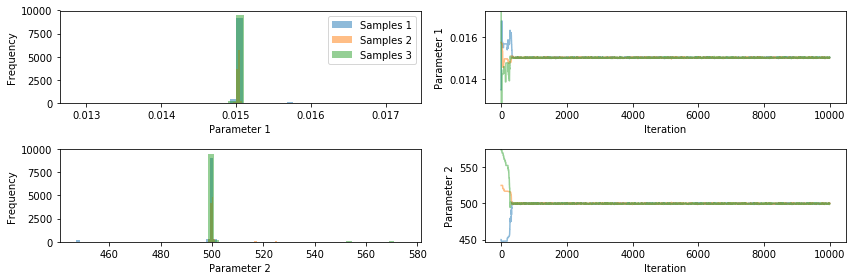

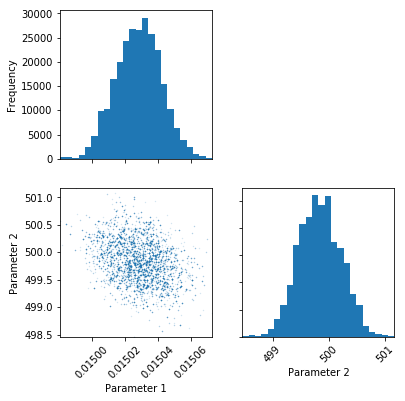

In [25]:
#chains_emu = pints.mcmc_sample(log_posterior_emu, 3, xs)
# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 3, xs)

# Add stopping criterion
mcmc.set_max_iterations(10000)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(chains)

# Discard warm up
chains_thin = chains[:, 2000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains_thin))

# Look at distribution in chain 0
pints.plot.pairwise(chains_thin[0])

# Show graphs
plt.show()

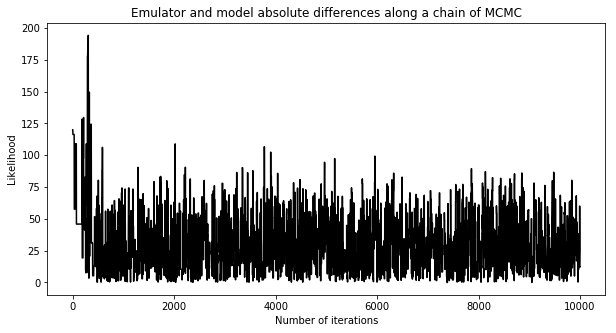

12.281252068718459

In [26]:
chain = chains[0]
emu_prediction = np.apply_along_axis(emu, 1, chain).flatten()
model_prediction = np.apply_along_axis(log_likelihood, 1, chain).flatten()
diffs = np.abs(model_prediction - emu_prediction)

iters = np.linspace(0, 10000, len(chain))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute differences along a chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Likelihood")
plt.plot(iters, diffs, color = "Black")
plt.show()

diffs[-1]

Running...
[2.89988948e-02 4.52605439e+02]
-inf


[-6.09623801e-04  5.23272733e+02]
-inf


[1.44630416e-02 5.78659264e+02]
-23116.859375
accepted


[2.06468180e-02 4.53757362e+02]
-inf


[2.11042565e-03 5.24650453e+02]
-inf


[-1.94693118e-03  5.81189189e+02]
-inf


[2.88803742e-02 4.49852797e+02]
-inf


[1.37140933e-02 5.24721973e+02]
-7133.24755859375


[5.80705152e-04 5.77791394e+02]
-inf


[1.53455965e-02 4.48466946e+02]
-11165.779296875
accepted


[9.46972439e-03 5.28085700e+02]
-inf


[2.07122785e-02 5.79762042e+02]
-inf


[2.78473464e-02 4.49812655e+02]
-inf


[7.8014353e-03 5.2360570e+02]
-inf


[1.78879986e-02 5.75271371e+02]
-65014.00390625


[8.57050937e-03 4.47596351e+02]
-inf


[2.07622259e-02 5.24405645e+02]
-inf


[9.34557152e-03 5.76440446e+02]
-inf


[9.60403106e-03 4.51878849e+02]
-inf


[3.22642351e-02 5.25776647e+02]
-inf


[1.13044876e-02 5.79822498e+02]
-60614.09765625


[2.12265863e-03 4.47286855e+02]
-inf


[2.42970079e-02 5.23065711e+02]
-inf


[-9.89225162e-04

[2.84370755e-02 4.53633437e+02]
-inf


[1.44019422e-02 5.23060832e+02]
-3548.110595703125


[3.16422403e-02 5.69433281e+02]
-inf


[2.98058934e-02 4.51453377e+02]
-inf


[9.13066549e-03 5.22801792e+02]
-inf


[2.10260279e-02 5.72708820e+02]
-inf


[1.85932772e-02 4.49152764e+02]
-25772.845703125


[1.12738200e-02 5.27522659e+02]
-59749.82421875


[1.50605067e-02 5.67107201e+02]
-19712.34765625


[2.24987119e-02 4.49536460e+02]
-inf


[1.10504137e-02 5.21798955e+02]
-69566.9296875


[9.51120470e-03 5.69906737e+02]
-inf


[6.72174017e-03 4.51876233e+02]
-inf


[-5.02760305e-03  5.25043160e+02]
-inf


[1.76683810e-02 5.63841068e+02]
-51157.26953125


[1.51587552e-02 4.52403928e+02]
-10010.083984375
accepted


[1.77066256e-02 5.23515732e+02]
-26338.943359375


[6.40177234e-03 5.70435898e+02]
-inf


[2.12908165e-02 4.51386591e+02]
-inf


[1.90791347e-02 5.23355091e+02]
-46423.90234375


[-1.06557115e-02  5.70323701e+02]
-inf


[2.16473885e-02 4.52582264e+02]
-inf


[3.87768679e-03 5.2379326

[3.17250661e-02 5.17449635e+02]
-inf


[1.36095118e-02 5.70732861e+02]
-18828.95703125


[1.51970647e-02 4.57965928e+02]
-7968.91162109375
accepted


[5.21789708e-02 5.14360167e+02]
-inf


[2.74390344e-02 5.72982721e+02]
-inf


[1.18366319e-03 4.58740166e+02]
-inf


[1.98235619e-02 5.14246437e+02]
-53131.6640625


[1.66682755e-02 5.67559751e+02]
-37926.671875


[2.11203067e-02 4.60278706e+02]
-inf


[2.36110431e-02 5.15204424e+02]
-inf


[1.91539580e-02 5.67288842e+02]
-82407.0


[1.41667297e-02 4.55836635e+02]
-14415.388671875


[1.57101591e-02 5.16128404e+02]
-4613.28662109375


[3.07433960e-03 5.69812239e+02]
-inf


[1.12842735e-02 4.56036251e+02]
-82499.140625


[2.42617693e-02 5.16939627e+02]
-inf


[3.88522666e-02 5.69348340e+02]
-inf


[3.78931982e-02 4.58042754e+02]
-inf


[2.59683889e-03 5.18656675e+02]
-inf


[1.38201653e-02 5.73563599e+02]
-19585.140625


[1.66868472e-02 4.57586726e+02]
-10415.6875


[1.66911957e-02 5.14499391e+02]
-11530.87109375


[1.72817518e-02 5.7204132

[1.48577529e-02 5.16586506e+02]
-2108.622314453125


[1.38676652e-02 5.64259020e+02]
-15451.90625
accepted


[1.55989165e-02 4.59421957e+02]
-7073.27490234375


[1.48891639e-02 5.16544396e+02]
-2105.919189453125


[1.38746893e-02 5.64404460e+02]
-15481.509765625


[1.55754547e-02 4.59476001e+02]
-7069.89208984375


[1.48747157e-02 5.16270305e+02]
-2069.661376953125
accepted


[1.39032264e-02 5.64132622e+02]
-15328.1171875
accepted


[1.56062384e-02 4.59564145e+02]
-7038.58740234375
accepted


[1.48542124e-02 5.16135096e+02]
-2057.165283203125
accepted


[1.38523849e-02 5.63336552e+02]
-15173.306640625
accepted


[1.56230821e-02 4.59693636e+02]
-7017.44287109375
accepted


[1.48626104e-02 5.16063656e+02]
-2044.5482177734375
accepted


[1.38888618e-02 5.63915424e+02]
-15275.529296875


[1.56055138e-02 4.59833576e+02]
-6978.36083984375
accepted


[1.48568950e-02 5.15947554e+02]
-2037.0013427734375
accepted


[1.38700560e-02 5.63324343e+02]
-15114.3515625
accepted


[1.56127506e-02 4.59787

[1.45713336e-02 4.79078329e+02]
-4380.75146484375


[1.49798018e-02 5.01336268e+02]
-1362.8450927734375


[1.37849571e-02 5.31205316e+02]
-7298.69677734375


[1.49153614e-02 4.72621399e+02]
-4646.04833984375


[1.50226994e-02 4.96744727e+02]
-1165.3489990234375


[1.36914882e-02 5.30811114e+02]
-7856.55224609375


[1.47600473e-02 4.75556634e+02]
-4362.74755859375


[1.50379459e-02 4.96021261e+02]
-1178.6107177734375


[1.37201799e-02 5.35866974e+02]
-8353.025390625


[1.47400919e-02 4.75819872e+02]
-4344.64990234375


[1.50041919e-02 4.99567573e+02]
-1240.4114990234375


[1.38914249e-02 5.32792623e+02]
-6816.59912109375


[1.47538517e-02 4.75649605e+02]
-4353.81005859375


[1.49967093e-02 4.99994729e+02]
-1272.8607177734375


[1.37222093e-02 5.19834362e+02]
-6726.92724609375


[1.48368637e-02 4.74096713e+02]
-4509.99365234375


[1.50625723e-02 4.92846680e+02]
-1397.7552490234375


[1.39737057e-02 5.07859079e+02]
-4605.62255859375
accepted


[1.46189231e-02 4.78060300e+02]
-4348.6303710

[1.46572623e-02 4.80377037e+02]
-3819.200439453125
accepted


[1.50267463e-02 4.97546893e+02]
-1148.0443115234375


[1.47700294e-02 4.98294783e+02]
-1661.8802490234375


[1.45992636e-02 4.81732581e+02]
-3793.192626953125
accepted


[1.50285688e-02 4.97485566e+02]
-1146.1341552734375
accepted


[1.49180789e-02 4.97853996e+02]
-1353.4935302734375


[1.45716629e-02 4.82204012e+02]
-3837.997314453125


[1.50313349e-02 4.97199870e+02]
-1147.6380615234375


[1.44931176e-02 5.09634274e+02]
-2064.247314453125


[1.46039014e-02 4.81964440e+02]
-3736.884033203125
accepted


[1.50193953e-02 4.98609328e+02]
-1168.0755615234375


[1.48447513e-02 5.01458340e+02]
-1457.6849365234375


[1.46276148e-02 4.80103783e+02]
-3969.805908203125


[1.50347649e-02 4.96687297e+02]
-1160.1888427734375


[1.50634220e-02 4.96316098e+02]
-1156.7669677734375
accepted


[1.46822473e-02 4.80767161e+02]
-3676.790283203125
accepted


[1.50299062e-02 4.97386619e+02]
-1144.5794677734375
accepted


[1.49946259e-02 4.96938563

[1.51961088e-02 5.07860341e+02]
-1712.9974365234375


[1.51069547e-02 4.98591241e+02]
-1097.1107177734375


[1.52790407e-02 4.93645857e+02]
-1330.6810302734375


[1.52337046e-02 5.02399548e+02]
-1328.3450927734375


[1.51073883e-02 4.99064460e+02]
-1097.4896240234375
accepted


[1.51732190e-02 4.97782061e+02]
-1218.4779052734375


[1.52508432e-02 5.11901471e+02]
-2148.411376953125


[1.51509030e-02 4.99511455e+02]
-1122.7044677734375


[1.50590265e-02 5.01497004e+02]
-1223.7161865234375


[1.53173109e-02 4.94266244e+02]
-1417.2474365234375


[1.51258849e-02 4.99623709e+02]
-1107.7357177734375


[1.51870365e-02 4.96043692e+02]
-1298.3568115234375


[1.49359347e-02 4.94153550e+02]
-1375.7591552734375


[1.51165191e-02 4.98844345e+02]
-1101.2122802734375


[1.51239948e-02 4.94193899e+02]
-1277.1966552734375


[1.48902464e-02 5.01732828e+02]
-1443.6966552734375


[1.51238104e-02 4.99597525e+02]
-1106.8724365234375


[1.50311452e-02 4.99168292e+02]
-1170.4232177734375


[1.51415227e-02 5.04

[1.50971408e-02 4.98791366e+02]
-1099.2786865234375


[1.51036764e-02 4.99521982e+02]
-1103.2318115234375


[1.51321628e-02 4.99478199e+02]
-1108.3646240234375


[1.51122135e-02 4.98934603e+02]
-1097.9505615234375


[1.50815745e-02 4.99441485e+02]
-1120.8529052734375


[1.51647196e-02 5.01685387e+02]
-1201.4466552734375


[1.51126022e-02 4.98884281e+02]
-1098.5130615234375


[1.50926508e-02 4.99800050e+02]
-1117.0482177734375


[1.48409598e-02 4.98980622e+02]
-1572.4154052734375


[1.51003725e-02 4.98797038e+02]
-1096.6380615234375


[1.51402940e-02 4.98477125e+02]
-1119.5911865234375


[1.50856827e-02 5.00155444e+02]
-1134.4544677734375


[1.51041241e-02 4.98873141e+02]
-1094.7904052734375
accepted


[1.50829727e-02 4.98240002e+02]
-1104.7864990234375


[1.51250299e-02 4.99053642e+02]
-1104.9154052734375
accepted


[1.50987959e-02 4.98704304e+02]
-1096.3958740234375


[1.51045827e-02 4.99479035e+02]
-1101.9154052734375


[1.50831107e-02 4.98728313e+02]
-1109.0794677734375


[1.5097945

[1.50417304e-02 4.98230786e+02]
-1137.6810302734375


[1.51031939e-02 4.98523275e+02]
-1095.3372802734375
accepted


[1.51094735e-02 4.98488422e+02]
-1099.3411865234375


[1.51583447e-02 4.99888965e+02]
-1135.6224365234375


[1.51087489e-02 4.98567139e+02]
-1098.3685302734375


[1.50902104e-02 4.99218856e+02]
-1109.5599365234375


[1.50776079e-02 4.98616521e+02]
-1111.8685302734375


[1.51094233e-02 4.98797293e+02]
-1097.1927490234375


[1.51006168e-02 4.98520517e+02]
-1096.0443115234375


[1.50884110e-02 4.97966854e+02]
-1107.6810302734375


[1.51071922e-02 4.98634696e+02]
-1096.9466552734375


[1.50903523e-02 4.99074095e+02]
-1107.7200927734375


[1.51257857e-02 4.98927067e+02]
-1106.2435302734375


[1.50975098e-02 4.98355924e+02]
-1097.9700927734375


[1.51045152e-02 4.99228284e+02]
-1098.8646240234375


[1.51077501e-02 4.97649590e+02]
-1110.5130615234375


[1.51070458e-02 4.98396413e+02]
-1098.5404052734375


[1.51019226e-02 4.98909558e+02]
-1097.0716552734375


[1.51081806e-02 4.9

[1.51116038e-02 4.99188154e+02]
-1099.8372802734375


[1.51039715e-02 4.98735938e+02]
-1094.2513427734375
accepted


[1.51100579e-02 4.99042584e+02]
-1098.0989990234375


[1.50967105e-02 4.98816814e+02]
-1099.8724365234375


[1.51028084e-02 4.98566648e+02]
-1094.9779052734375


[1.51199701e-02 4.98948985e+02]
-1102.5364990234375


[1.51022041e-02 4.98984995e+02]
-1097.7708740234375
accepted


[1.51037675e-02 4.98711341e+02]
-1094.3099365234375


[1.51094836e-02 4.98864455e+02]
-1096.7552490234375
accepted


[1.50726267e-02 4.98857943e+02]
-1118.4661865234375


[1.51090805e-02 4.98763333e+02]
-1097.2357177734375


[1.51156337e-02 4.98928615e+02]
-1100.0716552734375


[1.50903862e-02 4.98946199e+02]
-1106.1575927734375


[1.51070991e-02 4.98769570e+02]
-1095.9505615234375


[1.50995376e-02 4.98885644e+02]
-1098.5482177734375
accepted


[1.51155363e-02 4.99085602e+02]
-1099.9466552734375


[1.51084615e-02 4.99054054e+02]
-1097.7200927734375


[1.51063838e-02 4.98752576e+02]
-1095.63415527

[1.51124994e-02 4.99114609e+02]
-1099.4193115234375


[1.51118341e-02 4.98712030e+02]
-1099.2786865234375


[1.51025130e-02 4.98705052e+02]
-1094.6497802734375
accepted


[1.51146272e-02 4.98886988e+02]
-1099.7357177734375


[1.51000131e-02 4.98251386e+02]
-1098.2786865234375


[1.51007908e-02 4.98943697e+02]
-1098.2943115234375


[1.51122680e-02 4.98912316e+02]
-1098.1146240234375
accepted


[1.51030072e-02 4.98403403e+02]
-1096.0286865234375
accepted


[1.51031623e-02 4.98748060e+02]
-1094.2122802734375
accepted


[1.51099055e-02 4.98926925e+02]
-1096.6810302734375
accepted


[1.50991576e-02 4.98252101e+02]
-1098.5794677734375


[1.51072595e-02 4.98793261e+02]
-1095.9075927734375


[1.51074496e-02 4.98968882e+02]
-1096.6927490234375
accepted


[1.51044399e-02 4.98682134e+02]
-1094.9544677734375
accepted


[1.51020312e-02 4.98643569e+02]
-1095.0247802734375


[1.51069665e-02 4.99031671e+02]
-1097.0794677734375
accepted


[1.51025709e-02 4.98583164e+02]
-1094.9935302734375
accepted


[

[1.50987557e-02 4.98788802e+02]
-1097.8802490234375


[1.51051027e-02 4.98932871e+02]
-1095.6693115234375


[1.51034511e-02 4.98584118e+02]
-1095.0599365234375
accepted


[1.51058470e-02 4.98797622e+02]
-1094.9779052734375
accepted


[1.51029367e-02 4.98833474e+02]
-1095.0950927734375
accepted


[1.51062151e-02 4.98683797e+02]
-1096.0208740234375


[1.51103309e-02 4.98972108e+02]
-1097.3138427734375


[1.51004868e-02 4.98559569e+02]
-1096.0091552734375
accepted


[1.51025342e-02 4.98576166e+02]
-1095.0521240234375
accepted


[1.51029199e-02 4.98943685e+02]
-1096.7279052734375


[1.50998344e-02 4.98598354e+02]
-1096.2005615234375


[1.51022025e-02 4.98488288e+02]
-1095.4779052734375
accepted


[1.51065221e-02 4.98707760e+02]
-1096.0443115234375


[1.51024731e-02 4.98537766e+02]
-1095.2005615234375
accepted


[1.51057208e-02 4.98548370e+02]
-1096.6966552734375
accepted


[1.51060217e-02 4.98842991e+02]
-1094.7513427734375
accepted


[1.51019339e-02 4.98496845e+02]
-1095.5404052734375
acc

[1.51038419e-02 4.98691939e+02]
-1094.5052490234375


[1.51088604e-02 4.98992566e+02]
-1097.3099365234375


[1.51046207e-02 4.98918433e+02]
-1095.4349365234375
accepted


[1.51026444e-02 4.98466230e+02]
-1095.3568115234375


[1.51041573e-02 4.98670762e+02]
-1094.8802490234375


[1.51040879e-02 4.98822206e+02]
-1094.0560302734375
accepted


[1.50974854e-02 4.98663349e+02]
-1096.9818115234375


[1.51056020e-02 4.99051957e+02]
-1096.8333740234375


[1.51030832e-02 4.98874322e+02]
-1095.7005615234375


[1.51056377e-02 4.98694501e+02]
-1095.6029052734375


[1.51013149e-02 4.98431308e+02]
-1096.0755615234375


[1.51020715e-02 4.98854563e+02]
-1096.1927490234375


[1.51040981e-02 4.98898229e+02]
-1095.2708740234375
accepted


[1.51056039e-02 4.98762039e+02]
-1095.0989990234375


[1.51109747e-02 4.99106967e+02]
-1098.9114990234375


[1.51038533e-02 4.98920573e+02]
-1095.7357177734375
accepted


[1.51035483e-02 4.98825450e+02]
-1094.4310302734375
accepted


[1.51071448e-02 4.99097405e+02]
-1097

[1.51018219e-02 4.98783623e+02]
-1095.1732177734375
accepted


[1.51060561e-02 4.99044478e+02]
-1096.9505615234375


[1.51051951e-02 4.98998588e+02]
-1096.2904052734375


[1.51015224e-02 4.98748707e+02]
-1094.9310302734375
accepted


[1.51001703e-02 4.98550085e+02]
-1096.1849365234375
accepted


[1.51044020e-02 4.98892681e+02]
-1095.0521240234375
accepted


[1.50999219e-02 4.98864783e+02]
-1098.0404052734375


[1.51020677e-02 4.98424039e+02]
-1095.7357177734375
accepted


[1.51053223e-02 4.99059505e+02]
-1096.8060302734375


[1.51017651e-02 4.98669813e+02]
-1095.0911865234375


[1.50943415e-02 4.98079481e+02]
-1103.4427490234375


[1.51025326e-02 4.99091649e+02]
-1098.7396240234375


[1.51007722e-02 4.98623674e+02]
-1095.6927490234375
accepted


[1.50993838e-02 4.98536917e+02]
-1096.5482177734375
accepted


[1.51020704e-02 4.98897619e+02]
-1096.8021240234375


[1.51018451e-02 4.98549638e+02]
-1095.4427490234375
accepted


[1.50966703e-02 4.98491929e+02]
-1097.9075927734375
accepted


[

[1.51004762e-02 4.98545628e+02]
-1096.0364990234375
accepted


[1.51075009e-02 4.98799363e+02]
-1095.9739990234375


[1.51001629e-02 4.98391356e+02]
-1096.7200927734375
accepted


[1.50930562e-02 4.98369822e+02]
-1099.8568115234375


[1.51115958e-02 4.98807765e+02]
-1098.4388427734375


[1.51048295e-02 4.98963471e+02]
-1095.8450927734375
accepted


[1.51015219e-02 4.98700645e+02]
-1095.0911865234375
accepted


[1.51086433e-02 4.98859358e+02]
-1096.2474365234375


[1.51050387e-02 4.99085770e+02]
-1096.9739990234375


[1.51121074e-02 4.99272666e+02]
-1100.6771240234375


[1.51078801e-02 4.98737992e+02]
-1096.6654052734375


[1.51102541e-02 4.99268279e+02]
-1100.0482177734375


[1.50958427e-02 4.98590923e+02]
-1097.9661865234375


[1.51016736e-02 4.98713910e+02]
-1094.9779052734375
accepted


[1.51021048e-02 4.99103561e+02]
-1099.2318115234375


[1.50973365e-02 4.98575557e+02]
-1097.3450927734375


[1.51077418e-02 4.98916638e+02]
-1096.0755615234375


[1.51021589e-02 4.98520241e+02]
-1095

[1.51015757e-02 4.98319562e+02]
-1096.4622802734375


[1.50968032e-02 4.98668821e+02]
-1097.4622802734375


[1.51040194e-02 4.98691489e+02]
-1094.5989990234375
accepted


[1.50987524e-02 4.98361425e+02]
-1097.3958740234375


[1.51015998e-02 4.98247958e+02]
-1097.7396240234375


[1.51082882e-02 4.98673764e+02]
-1097.3919677734375


[1.51036311e-02 4.98804922e+02]
-1094.0013427734375
accepted


[1.51081698e-02 4.98350985e+02]
-1099.6224365234375


[1.51001756e-02 4.98642303e+02]
-1095.8997802734375


[1.51048249e-02 4.98597535e+02]
-1095.7904052734375


[1.51070694e-02 4.99423925e+02]
-1100.4271240234375


[1.51081764e-02 4.99310100e+02]
-1099.8177490234375


[1.51063969e-02 4.98865174e+02]
-1095.0911865234375
accepted


[1.51083788e-02 4.98824634e+02]
-1096.3450927734375


[1.51051461e-02 4.98491097e+02]
-1096.6888427734375


[1.51056471e-02 4.98966253e+02]
-1096.1497802734375


[1.51014434e-02 4.98167661e+02]
-1099.2239990234375


[1.51017095e-02 4.98701698e+02]
-1094.9700927734375


[

[1.51067847e-02 4.98286251e+02]
-1100.0599365234375


[1.51077273e-02 4.98992722e+02]
-1096.9896240234375


[1.51135001e-02 4.98874337e+02]
-1099.1575927734375


[1.51005579e-02 4.97897611e+02]
-1103.0091552734375


[1.51194772e-02 4.98771426e+02]
-1103.5013427734375


[1.51106207e-02 4.98940225e+02]
-1096.9739990234375
accepted


[1.51024525e-02 4.98036881e+02]
-1101.6224365234375


[1.51132860e-02 4.99038798e+02]
-1098.8646240234375


[1.51093233e-02 4.99142187e+02]
-1098.7083740234375


[1.51044740e-02 4.98505278e+02]
-1096.2005615234375
accepted


[1.51098101e-02 4.99126371e+02]
-1098.7513427734375


[1.51083340e-02 4.98528804e+02]
-1098.4036865234375
accepted


[1.50957476e-02 4.98019583e+02]
-1103.8802490234375


[1.51035027e-02 4.98913831e+02]
-1095.9310302734375
accepted


[1.51121344e-02 4.99140464e+02]
-1099.5404052734375
accepted


[1.50938859e-02 4.98038108e+02]
-1104.3724365234375


[1.51022796e-02 4.98820455e+02]
-1095.4427490234375
accepted


[1.51067706e-02 4.99036359e+

-1096.5989990234375


[1.51024108e-02 4.98944572e+02]
-1097.1263427734375


[1.51124381e-02 4.99167224e+02]
-1099.8489990234375


[1.51122153e-02 4.98640763e+02]
-1099.9544677734375


[1.51022645e-02 4.98972404e+02]
-1097.5443115234375


[1.51091908e-02 4.98840349e+02]
-1096.7435302734375


[1.51009832e-02 4.98379597e+02]
-1096.3841552734375
accepted


[1.51107364e-02 4.99122359e+02]
-1098.9779052734375


[1.50944861e-02 4.98314295e+02]
-1099.4154052734375


[1.51025332e-02 4.98343439e+02]
-1096.1419677734375
accepted


[1.51089396e-02 4.99078046e+02]
-1098.0716552734375


[1.51100511e-02 4.99431417e+02]
-1101.3646240234375


[1.51016920e-02 4.98201338e+02]
-1098.5716552734375


[1.51066202e-02 4.98816925e+02]
-1095.2943115234375
accepted


[1.51063797e-02 4.99207766e+02]
-1098.4075927734375


[1.50972422e-02 4.98250290e+02]
-1099.3021240234375


[1.51052601e-02 4.98990442e+02]
-1096.2318115234375
accepted


[1.50989184e-02 4.98683137e+02]
-1096.3177490234375


[1.51009878e-02 4.979373

[1.51042917e-02 4.98577307e+02]
-1095.6146240234375
accepted


[1.51035994e-02 4.98268929e+02]
-1098.2864990234375


[1.51061057e-02 4.99149796e+02]
-1097.8216552734375


[1.51040349e-02 4.98578783e+02]
-1095.4622802734375
accepted


[1.50961357e-02 4.98546312e+02]
-1097.9583740234375


[1.51038161e-02 4.99185905e+02]
-1098.9271240234375


[1.51064848e-02 4.98641665e+02]
-1096.4779052734375
accepted


[1.51026944e-02 4.98753711e+02]
-1094.4661865234375
accepted


[1.51141122e-02 4.99257027e+02]
-1101.1380615234375


[1.51068991e-02 4.98611958e+02]
-1096.9427490234375
accepted


[1.51062251e-02 4.98696086e+02]
-1095.9622802734375


[1.51068510e-02 4.98924226e+02]
-1095.9857177734375


[1.51026929e-02 4.98549623e+02]
-1095.0755615234375
accepted


[1.51033140e-02 4.99056062e+02]
-1097.7396240234375


[1.51005479e-02 4.98905744e+02]
-1098.0911865234375


[1.51020454e-02 4.98718407e+02]
-1094.7943115234375
accepted


[1.50993063e-02 4.98864922e+02]
-1098.5052490234375


[1.51019987e-02 4.9

[1.51037760e-02 4.98760468e+02]
-1093.9388427734375
accepted


[1.51057029e-02 4.98816796e+02]
-1094.7396240234375
accepted


[1.51003922e-02 4.98520905e+02]
-1096.1497802734375


[1.51040309e-02 4.99027443e+02]
-1096.8411865234375


[1.51110465e-02 4.99232623e+02]
-1099.9896240234375


[1.51092288e-02 4.99125969e+02]
-1098.5716552734375


[1.51017196e-02 4.98541473e+02]
-1095.5169677734375


[1.51086753e-02 4.98780727e+02]
-1096.8763427734375


[1.51012418e-02 4.98453844e+02]
-1096.0364990234375
accepted


[1.51045018e-02 4.99180045e+02]
-1098.2747802734375


[1.51144113e-02 4.98996468e+02]
-1098.8685302734375


[1.50970247e-02 4.98326212e+02]
-1098.2591552734375
accepted


[1.51020414e-02 4.98552625e+02]
-1095.3372802734375
accepted


[1.51086319e-02 4.98386756e+02]
-1099.5599365234375


[1.50952126e-02 4.98554089e+02]
-1098.3294677734375
accepted


[1.51005248e-02 4.98360588e+02]
-1096.6107177734375


[1.51076147e-02 4.98969649e+02]
-1096.7435302734375


[1.50915204e-02 4.98576895e+

[1.50934036e-02 4.98464227e+02]
-1099.4739990234375


[1.51070608e-02 4.98798118e+02]
-1095.7083740234375


[1.51011840e-02 4.98832609e+02]
-1096.5482177734375
accepted


[1.51129325e-02 4.98559601e+02]
-1100.9974365234375


[1.51012078e-02 4.99096008e+02]
-1099.8099365234375


[1.51017965e-02 4.98834507e+02]
-1096.1341552734375
accepted


[1.51052012e-02 4.98775753e+02]
-1094.7513427734375
accepted


[1.51087489e-02 4.99128528e+02]
-1098.3997802734375


[1.51025114e-02 4.98169460e+02]
-1099.5560302734375


[1.50923658e-02 4.98567050e+02]
-1099.5794677734375


[1.51146433e-02 4.99176001e+02]
-1100.5989990234375


[1.51040109e-02 4.98747907e+02]
-1094.1771240234375
accepted


[1.51014469e-02 4.98089352e+02]
-1100.2435302734375


[1.50993638e-02 4.98216695e+02]
-1099.1341552734375


[1.51009454e-02 4.99019095e+02]
-1099.0989990234375


[1.51083192e-02 4.98620058e+02]
-1097.7786865234375


[1.51075538e-02 4.98917988e+02]
-1096.0169677734375
accepted


[1.51111833e-02 4.99048539e+02]
-1098

[1.51086086e-02 4.98641226e+02]
-1097.7708740234375


[1.51060240e-02 4.98525672e+02]
-1097.0482177734375


[1.50993027e-02 4.98678699e+02]
-1096.1341552734375
accepted


[1.50987293e-02 4.98767228e+02]
-1097.5599365234375


[1.50917810e-02 4.98100441e+02]
-1104.0286865234375


[1.51022695e-02 4.98235091e+02]
-1098.1458740234375


[1.51093002e-02 4.98953672e+02]
-1096.8841552734375
accepted


[1.51008157e-02 4.98073127e+02]
-1100.7161865234375


[1.50925919e-02 4.97817913e+02]
-1107.9232177734375


[1.5103587e-02 4.9906400e+02]
-1097.6419677734375


[1.51122555e-02 4.98615230e+02]
-1100.1966552734375


[1.51118747e-02 4.98765577e+02]
-1098.9193115234375


[1.51130919e-02 4.99060932e+02]
-1099.0911865234375


[1.50965458e-02 4.98127914e+02]
-1101.7982177734375


[1.50963221e-02 4.98185936e+02]
-1100.7943115234375


[1.51082814e-02 4.98829243e+02]
-1096.2708740234375
accepted


[1.51029436e-02 4.98320534e+02]
-1096.7591552734375


[1.51093389e-02 4.98923432e+02]
-1096.5169677734375
accep

[1.50963650e-02 4.97928993e+02]
-1104.7279052734375


[1.51028287e-02 4.98589321e+02]
-1094.8685302734375
accepted


[1.50868656e-02 4.98294934e+02]
-1102.8724365234375


[1.50974394e-02 4.98372701e+02]
-1097.9232177734375


[1.50971552e-02 4.98208860e+02]
-1100.0677490234375


[1.50987589e-02 4.98441582e+02]
-1097.1068115234375


[1.50954001e-02 4.98739716e+02]
-1099.8724365234375


[1.51016795e-02 4.98381229e+02]
-1096.0677490234375


[1.51007249e-02 4.98213412e+02]
-1098.6849365234375


[1.51070262e-02 4.99194327e+02]
-1098.4739990234375


[1.51025910e-02 4.99037361e+02]
-1098.0638427734375


[1.51028903e-02 4.99074198e+02]
-1098.2630615234375


[1.51107858e-02 4.98645073e+02]
-1099.0794677734375


[1.51037512e-02 4.98692040e+02]
-1094.4622802734375
accepted


[1.51042468e-02 4.98318717e+02]
-1097.6575927734375


[1.50952318e-02 4.99202592e+02]
-1105.5482177734375


[1.51134991e-02 4.99035373e+02]
-1098.8333740234375


[1.50979699e-02 4.97872452e+02]
-1104.6302490234375


[1.5105999

[1.51189721e-02 4.98778001e+02]
-1103.1224365234375


[1.51083299e-02 4.98731828e+02]
-1096.9935302734375
accepted


[1.50971998e-02 4.98555560e+02]
-1097.4622802734375


[1.51002981e-02 4.98982958e+02]
-1099.1575927734375


[1.51175290e-02 4.98932047e+02]
-1101.2122802734375


[1.50997511e-02 4.98674834e+02]
-1095.9857177734375
accepted


[1.51068657e-02 4.99463794e+02]
-1100.7122802734375


[1.51053864e-02 4.99074713e+02]
-1096.9818115234375
accepted


[1.50979689e-02 4.98747538e+02]
-1097.8411865234375


[1.51072524e-02 4.98868297e+02]
-1095.3411865234375
accepted


[1.50802747e-02 4.98647292e+02]
-1110.2825927734375


[1.51048916e-02 4.98956541e+02]
-1095.8489990234375
accepted


[1.51075013e-02 4.98781788e+02]
-1096.1224365234375
accepted


[1.51019044e-02 4.98759709e+02]
-1094.7318115234375
accepted


[1.51077271e-02 4.98965168e+02]
-1096.6966552734375


[1.51107651e-02 4.98712413e+02]
-1098.6263427734375


[1.50895217e-02 4.98544805e+02]
-1101.5443115234375


[1.51136542e-02 4.9

[1.51012213e-02 4.98894070e+02]
-1097.4349365234375


[1.51073377e-02 4.98333510e+02]
-1099.4505615234375


[1.50993669e-02 4.98420697e+02]
-1096.9310302734375


[1.50957629e-02 4.98684905e+02]
-1098.6536865234375


[1.51047887e-02 4.98668696e+02]
-1095.2435302734375


[1.50985415e-02 4.98534207e+02]
-1096.9661865234375


[1.50940557e-02 4.98453642e+02]
-1099.1693115234375


[1.50952663e-02 4.98003450e+02]
-1104.2825927734375


[1.51078382e-02 4.98441005e+02]
-1098.6771240234375


[1.50931639e-02 4.98509045e+02]
-1099.4271240234375


[1.51028177e-02 4.98451217e+02]
-1095.5794677734375


[1.50938696e-02 4.98192826e+02]
-1101.6029052734375


[1.51099505e-02 4.99253508e+02]
-1099.8568115234375


[1.51036101e-02 4.98788954e+02]
-1093.9114990234375
accepted


[1.51128013e-02 4.98691969e+02]
-1100.0169677734375


[1.51017085e-02 4.98815346e+02]
-1095.8685302734375
accepted


[1.50895467e-02 4.98901164e+02]
-1106.2747802734375


[1.51107696e-02 4.99156929e+02]
-1099.2396240234375


[1.5106402

[1.51004475e-02 4.98108123e+02]
-1100.4349365234375


[1.50998896e-02 4.98701067e+02]
-1095.8489990234375
accepted


[1.51050622e-02 4.98744703e+02]
-1094.8802490234375
accepted


[1.51134032e-02 4.97864008e+02]
-1110.2279052734375


[1.51050059e-02 4.99339139e+02]
-1099.8177490234375


[1.50992555e-02 4.98551346e+02]
-1096.5833740234375
accepted


[1.51059823e-02 4.98682862e+02]
-1095.9232177734375
accepted


[1.50979796e-02 4.98886912e+02]
-1099.7669677734375


[1.50962658e-02 4.98445606e+02]
-1098.2279052734375


[1.51228131e-02 4.99023897e+02]
-1103.7747802734375


[1.50980641e-02 4.98425938e+02]
-1097.4935302734375
accepted


[1.50918285e-02 4.98435802e+02]
-1100.2396240234375


[1.50900381e-02 4.98153443e+02]
-1103.6966552734375


[1.50978256e-02 4.98085186e+02]
-1101.9974365234375


[1.50909593e-02 4.98258038e+02]
-1101.4739990234375


[1.51123788e-02 4.99672111e+02]
-1104.4583740234375


[1.51049570e-02 4.98906102e+02]
-1095.3489990234375
accepted


[1.51023296e-02 4.98543786e+

[1.50993809e-02 4.98525380e+02]
-1096.5911865234375
accepted


[1.51003032e-02 4.98737353e+02]
-1095.6575927734375


[1.51065093e-02 4.98619102e+02]
-1096.6693115234375
accepted


[1.51004766e-02 4.98633984e+02]
-1095.7825927734375
accepted


[1.51090289e-02 4.98969801e+02]
-1097.0286865234375


[1.50894313e-02 4.98233947e+02]
-1102.5052490234375


[1.50853262e-02 4.99423388e+02]
-1116.5325927734375


[1.50975372e-02 4.98556173e+02]
-1097.3021240234375


[1.50978059e-02 4.98388344e+02]
-1097.7044677734375


[1.51005643e-02 4.98382255e+02]
-1096.5755615234375


[1.51121700e-02 4.98835456e+02]
-1098.6068115234375


[1.51093476e-02 4.98188094e+02]
-1102.9974365234375


[1.50946006e-02 4.98150023e+02]
-1102.0755615234375


[1.51057593e-02 4.98943842e+02]
-1095.9700927734375


[1.50964333e-02 4.98237558e+02]
-1099.8021240234375


[1.50933967e-02 4.98278437e+02]
-1100.1927490234375


[1.51100327e-02 4.98423780e+02]
-1100.1263427734375


[1.51014123e-02 4.98363342e+02]
-1096.2239990234375
acc

[1.51025514e-02 4.98139799e+02]
-1100.0638427734375


[1.51111508e-02 4.99144784e+02]
-1099.2513427734375


[1.50988748e-02 4.98186001e+02]
-1099.8529052734375


[1.50989645e-02 4.98014665e+02]
-1102.3489990234375


[1.51019782e-02 4.98567709e+02]
-1095.2904052734375
accepted


[1.51006392e-02 4.98371412e+02]
-1096.5247802734375
accepted


[1.51051510e-02 4.97705804e+02]
-1108.2630615234375


[1.51052514e-02 4.98852929e+02]
-1094.7005615234375
accepted


[1.51084558e-02 4.98280102e+02]
-1101.0716552734375


[1.50983017e-02 4.99053471e+02]
-1101.4700927734375


[1.51144318e-02 4.99318322e+02]
-1101.7239990234375


[1.50989435e-02 4.98254277e+02]
-1098.5794677734375


[1.51161737e-02 4.98731263e+02]
-1101.7708740234375


[1.51089292e-02 4.99393255e+02]
-1100.7122802734375


[1.50892374e-02 4.97966968e+02]
-1107.3646240234375


[1.51026490e-02 4.99317113e+02]
-1101.3177490234375


[1.51045982e-02 4.98624043e+02]
-1095.4739990234375


[1.50939015e-02 4.98254870e+02]
-1100.4700927734375


[

[1.51170116e-02 5.00083572e+02]
-1110.1302490234375


[1.51019575e-02 4.97966445e+02]
-1102.4271240234375


[1.50967227e-02 4.98019238e+02]
-1103.4036865234375


[1.51026815e-02 4.98802372e+02]
-1094.7747802734375
accepted


[1.51123495e-02 4.98783331e+02]
-1099.0404052734375


[1.51025262e-02 4.98164438e+02]
-1099.6693115234375


[1.50978966e-02 4.98789137e+02]
-1098.6302490234375


[1.51108307e-02 4.98850698e+02]
-1097.6575927734375


[1.50989583e-02 4.98244249e+02]
-1098.7747802734375


[1.51041342e-02 4.99167352e+02]
-1098.4622802734375


[1.51082353e-02 4.99015975e+02]
-1097.3411865234375


[1.51037030e-02 4.98407004e+02]
-1096.4388427734375
accepted


[1.51018860e-02 4.99159565e+02]
-1100.0169677734375


[1.50995956e-02 4.98289196e+02]
-1097.7200927734375


[1.51097445e-02 4.98586046e+02]
-1098.8529052734375


[1.51023490e-02 4.99377585e+02]
-1102.2357177734375


[1.51061718e-02 4.99020584e+02]
-1096.7591552734375
accepted


[1.51028641e-02 4.98419366e+02]
-1095.8255615234375
acc

[1.51077374e-02 4.99473919e+02]
-1101.0677490234375


[1.50991722e-02 4.99201136e+02]
-1102.5560302734375


[1.51092027e-02 4.99289408e+02]
-1099.9583740234375


[1.51047333e-02 4.99524818e+02]
-1102.4154052734375


[1.51057044e-02 4.98298131e+02]
-1099.0677490234375


[1.51107975e-02 4.98997607e+02]
-1097.7982177734375


[1.51177518e-02 4.99716613e+02]
-1106.3958740234375


[1.51054643e-02 4.99070577e+02]
-1096.9974365234375


[1.51043689e-02 4.98760397e+02]
-1094.3450927734375
accepted


[1.51008075e-02 4.98933253e+02]
-1098.1810302734375


[1.51042325e-02 4.98918159e+02]
-1095.3919677734375


[1.51067542e-02 4.99185002e+02]
-1098.2943115234375


[1.51002723e-02 4.98593375e+02]
-1096.0169677734375
accepted


[1.51136293e-02 4.98831754e+02]
-1099.5247802734375


[1.50999132e-02 4.98817555e+02]
-1097.4114990234375


[1.50846900e-02 4.97472604e+02]
-1116.1419677734375


[1.51021172e-02 4.98382582e+02]
-1095.8646240234375


[1.51059173e-02 4.98885905e+02]
-1095.2474365234375


[1.5094408

[1.51030529e-02 4.99102862e+02]
-1098.4739990234375
accepted


[1.50920136e-02 4.98088713e+02]
-1104.1771240234375


[1.51080675e-02 4.98629097e+02]
-1097.5404052734375
accepted


[1.51014439e-02 4.98995191e+02]
-1098.4388427734375
accepted


[1.51066151e-02 4.98213765e+02]
-1101.1029052734375


[1.51108293e-02 4.98470694e+02]
-1100.3216552734375


[1.51007645e-02 4.98708522e+02]
-1095.4466552734375
accepted


[1.51057211e-02 4.98843591e+02]
-1094.6341552734375
accepted


[1.51056660e-02 4.98321853e+02]
-1098.5404052734375


[1.51176619e-02 4.99592110e+02]
-1105.0599365234375


[1.51039405e-02 4.98997364e+02]
-1096.5755615234375


[1.51035620e-02 4.97856281e+02]
-1105.0325927734375


[1.51007318e-02 4.98930787e+02]
-1098.2279052734375


[1.51014342e-02 4.98694015e+02]
-1095.1575927734375
accepted


[1.51147053e-02 4.98805909e+02]
-1100.3450927734375


[1.51012698e-02 4.97936135e+02]
-1102.5013427734375


[1.50997553e-02 4.98454517e+02]
-1096.6419677734375


[1.51191044e-02 4.98485506e+

[1.51004357e-02 4.99082305e+02]
-1100.2161865234375


[1.51072747e-02 4.99016156e+02]
-1097.0404052734375
accepted


[1.51149741e-02 4.99235666e+02]
-1101.2044677734375


[1.51006894e-02 4.98515463e+02]
-1096.0599365234375
accepted


[1.51058641e-02 4.98825099e+02]
-1094.7708740234375
accepted


[1.51105585e-02 4.99374342e+02]
-1101.0560302734375


[1.51107935e-02 4.99361315e+02]
-1101.0286865234375


[1.51027343e-02 4.98632400e+02]
-1094.7864990234375
accepted


[1.51028175e-02 4.98790224e+02]
-1094.4505615234375
accepted


[1.50890501e-02 4.97875977e+02]
-1108.9544677734375


[1.51037448e-02 4.98211046e+02]
-1099.5950927734375


[1.51076494e-02 4.98956076e+02]
-1096.6068115234375


[1.50982404e-02 4.98609252e+02]
-1096.8646240234375
accepted


[1.51041083e-02 4.98711985e+02]
-1094.5169677734375
accepted


[1.51023874e-02 4.98742708e+02]
-1094.5599365234375
accepted


[1.50991973e-02 4.97879975e+02]
-1103.9349365234375


[1.51044007e-02 4.98649497e+02]
-1095.1419677734375


[1.5096212

[1.51007368e-02 4.98286144e+02]
-1097.3646240234375


[1.51010284e-02 4.98501616e+02]
-1095.9232177734375
accepted


[1.50993452e-02 4.98416360e+02]
-1096.9427490234375


[1.51135794e-02 4.98539956e+02]
-1101.4622802734375


[1.50962454e-02 4.98527102e+02]
-1098.0247802734375


[1.51087884e-02 4.98709652e+02]
-1097.4114990234375


[1.51113543e-02 4.98899128e+02]
-1097.6458740234375


[1.51012706e-02 4.98174122e+02]
-1099.1966552734375


[1.51079305e-02 4.98891997e+02]
-1095.7318115234375


[1.50867730e-02 4.98152804e+02]
-1104.9661865234375


[1.50991780e-02 4.98556786e+02]
-1096.6029052734375


[1.50993192e-02 4.98955984e+02]
-1099.5716552734375


[1.51100789e-02 4.99079198e+02]
-1098.4114990234375


[1.51075894e-02 4.98857255e+02]
-1095.5950927734375
accepted


[1.50995797e-02 4.98307317e+02]
-1097.3880615234375


[1.51027339e-02 4.98399761e+02]
-1095.8568115234375
accepted


[1.51112843e-02 4.99287276e+02]
-1100.5052490234375


[1.51125579e-02 4.99144881e+02]
-1099.6927490234375


[

[1.51134116e-02 4.99094799e+02]
-1099.5833740234375


[1.51156717e-02 4.99654402e+02]
-1105.1536865234375


[1.50983232e-02 4.98311892e+02]
-1097.7708740234375
accepted


[1.51053014e-02 4.98502297e+02]
-1096.7435302734375
accepted


[1.51181717e-02 4.99100087e+02]
-1100.7279052734375


[1.50989893e-02 4.98523812e+02]
-1096.7552490234375
accepted


[1.50950980e-02 4.98070036e+02]
-1103.3529052734375


[1.51173785e-02 4.99624528e+02]
-1105.3294677734375


[1.51006883e-02 4.98600494e+02]
-1095.7904052734375
accepted


[1.50954407e-02 4.98076690e+02]
-1103.0833740234375


[1.51040761e-02 4.98309516e+02]
-1097.7279052734375
accepted


[1.51044700e-02 4.98606149e+02]
-1095.5208740234375
accepted


[1.51038013e-02 4.97789696e+02]
-1106.1341552734375


[1.51010938e-02 4.98358805e+02]
-1096.4036865234375
accepted


[1.51088494e-02 4.98212493e+02]
-1102.3099365234375


[1.50988309e-02 4.97692567e+02]
-1106.4583740234375


[1.51122662e-02 4.99094552e+02]
-1099.1810302734375


[1.50982457e-02 4.9

[1.51144536e-02 4.99055173e+02]
-1099.2864990234375
accepted


[1.51021565e-02 4.98629900e+02]
-1095.0521240234375
accepted


[1.51120891e-02 4.99005343e+02]
-1098.1614990234375


[1.51183047e-02 4.98243596e+02]
-1106.9779052734375


[1.51047536e-02 4.98491000e+02]
-1096.4739990234375


[1.51067994e-02 4.98913236e+02]
-1095.8294677734375
accepted


[1.51087894e-02 4.99803964e+02]
-1104.8724365234375


[1.50983068e-02 4.98233044e+02]
-1099.2357177734375


[1.51084170e-02 4.99269025e+02]
-1099.5482177734375


[1.50947737e-02 4.97611245e+02]
-1109.4700927734375


[1.51011235e-02 4.98983447e+02]
-1098.5521240234375


[1.51088385e-02 4.99007918e+02]
-1097.4388427734375


[1.51162393e-02 4.99687269e+02]
-1105.6732177734375


[1.50911012e-02 4.98328861e+02]
-1100.8763427734375


[1.51034368e-02 4.98683073e+02]
-1094.3372802734375
accepted


[1.51053938e-02 4.98516552e+02]
-1096.7279052734375
accepted


[1.51044416e-02 4.98738051e+02]
-1094.5208740234375
accepted


[1.50928735e-02 4.98250135e+

[1.50865530e-02 4.97984904e+02]
-1108.0364990234375


[1.51100536e-02 4.98865906e+02]
-1097.0950927734375


[1.50847610e-02 4.98063963e+02]
-1107.2864990234375


[1.50977245e-02 4.98592162e+02]
-1097.1029052734375
accepted


[1.51008692e-02 4.98761441e+02]
-1095.6146240234375


[1.51065153e-02 4.98987679e+02]
-1096.6068115234375


[1.50949986e-02 4.98964579e+02]
-1102.9310302734375


[1.50976167e-02 4.98524789e+02]
-1097.3880615234375


[1.51065342e-02 4.98946127e+02]
-1096.2200927734375


[1.50982924e-02 4.98992698e+02]
-1100.7630615234375


[1.50964711e-02 4.98919987e+02]
-1101.3060302734375


[1.51124777e-02 4.99607835e+02]
-1103.7943115234375


[1.51007490e-02 4.98898753e+02]
-1097.8216552734375


[1.51061021e-02 4.98755123e+02]
-1095.4388427734375


[1.50904349e-02 4.97757182e+02]
-1109.7825927734375


[1.51098101e-02 4.99244042e+02]
-1099.7474365234375


[1.51081510e-02 4.98978724e+02]
-1097.0130615234375


[1.51154758e-02 4.98689673e+02]
-1101.6341552734375


[1.50830081e-02 4.9

[1.51079359e-02 4.98742943e+02]
-1096.6068115234375
accepted


[1.50980275e-02 4.98452134e+02]
-1097.4427490234375


[1.51033642e-02 4.98834004e+02]
-1094.7630615234375
accepted


[1.50984015e-02 4.98024327e+02]
-1102.5052490234375


[1.51034136e-02 4.98523316e+02]
-1095.4544677734375
accepted


[1.50906995e-02 4.97978734e+02]
-1106.6146240234375


[1.51224778e-02 4.98732404e+02]
-1105.6029052734375


[1.51079005e-02 4.98502352e+02]
-1098.3177490234375


[1.51106342e-02 4.99048274e+02]
-1098.3255615234375


[1.51012503e-02 4.97613400e+02]
-1107.5638427734375


[1.51040979e-02 4.98486274e+02]
-1096.0950927734375


[1.51039546e-02 4.98419070e+02]
-1096.4739990234375
accepted


[1.50998234e-02 4.98624387e+02]
-1096.0989990234375
accepted


[1.51058424e-02 4.98762152e+02]
-1095.2318115234375
accepted


[1.50979329e-02 4.97395964e+02]
-1110.6146240234375


[1.51016569e-02 4.98971541e+02]
-1098.0443115234375
accepted


[1.50996710e-02 4.98459216e+02]
-1096.6458740234375


[1.51048327e-02 4.9

[1.51033041e-02 4.98183166e+02]
-1099.7357177734375


[1.50900329e-02 4.98242283e+02]
-1102.1029052734375


[1.51084381e-02 4.98820866e+02]
-1096.3919677734375


[1.51051534e-02 4.98937127e+02]
-1095.7357177734375


[1.50838783e-02 4.97206245e+02]
-1120.5833740234375


[1.51104112e-02 4.99024877e+02]
-1098.0247802734375


[1.51045623e-02 4.99167978e+02]
-1098.1341552734375


[1.50909804e-02 4.97813062e+02]
-1108.7591552734375


[1.50992599e-02 4.99078037e+02]
-1101.0794677734375


[1.51119045e-02 4.99063274e+02]
-1098.8138427734375
accepted


[1.50994548e-02 4.98238735e+02]
-1098.6810302734375


[1.50970222e-02 4.98119945e+02]
-1101.7279052734375


[1.51151783e-02 4.99860690e+02]
-1107.2396240234375


[1.50938297e-02 4.97784613e+02]
-1107.7435302734375


[1.50918037e-02 4.98792911e+02]
-1103.3021240234375


[1.51084095e-02 4.98601332e+02]
-1097.9271240234375
accepted


[1.51065388e-02 4.98340649e+02]
-1098.7513427734375


[1.50819729e-02 4.98393987e+02]
-1105.3568115234375


[1.5108616



[1.50929448e-02 4.97610910e+02]
-1110.3529052734375


[1.51078504e-02 4.98967654e+02]
-1096.7552490234375
accepted


[1.51054153e-02 4.98201230e+02]
-1100.6419677734375


[1.51167450e-02 4.99309411e+02]
-1102.3255615234375


[1.51072344e-02 4.98952954e+02]
-1096.4505615234375
accepted


[1.51020953e-02 4.99241821e+02]
-1100.8529052734375


[1.51205211e-02 4.99379142e+02]
-1104.0677490234375


[1.50986240e-02 4.98842539e+02]
-1098.7591552734375


[1.51093196e-02 4.98788488e+02]
-1097.1927490234375


[1.51140956e-02 4.98633401e+02]
-1101.1771240234375


[1.51058155e-02 4.99058379e+02]
-1096.9622802734375


[1.50947627e-02 4.97931208e+02]
-1105.4466552734375


[1.50930406e-02 4.98090454e+02]
-1103.7357177734375


[1.51089139e-02 4.98368230e+02]
-1099.8489990234375


[1.50969063e-02 4.98450985e+02]
-1097.9349365234375


[1.51101998e-02 4.98434717e+02]
-1100.1771240234375


[1.51159886e-02 4.99424221e+02]
-1103.1068115234375


[1.51004639e-02 4.98188088e+02]
-1099.2239990234375


[1.51090

[1.50971419e-02 4.98591243e+02]
-1097.3841552734375


[1.50991894e-02 4.98754183e+02]
-1096.9154052734375


[1.51009897e-02 4.98382840e+02]
-1096.3724365234375


[1.51160995e-02 4.99507977e+02]
-1103.8216552734375


[1.50970444e-02 4.98511933e+02]
-1097.6888427734375
accepted


[1.51022016e-02 4.98863712e+02]
-1096.2708740234375


[1.51042459e-02 4.98614736e+02]
-1095.3099365234375


[1.51108721e-02 4.99320877e+02]
-1100.6575927734375


[1.50991502e-02 4.98388727e+02]
-1097.1029052734375


[1.51081568e-02 4.99055953e+02]
-1097.6419677734375


[1.51019458e-02 4.98464132e+02]
-1095.6380615234375
accepted


[1.51086067e-02 4.98838010e+02]
-1096.3802490234375
accepted


[1.51036635e-02 4.99255081e+02]
-1099.8060302734375


[1.50986557e-02 4.98558187e+02]
-1096.8021240234375


[1.51023135e-02 4.98799674e+02]
-1095.0794677734375
accepted


[1.50995739e-02 4.98291275e+02]
-1097.7161865234375


[1.51093423e-02 4.98831175e+02]
-1096.9232177734375


[1.51072950e-02 4.99011386e+02]
-1097.02868652

[1.50948766e-02 4.98415098e+02]
-1098.9388427734375


[1.51093034e-02 4.99258856e+02]
-1099.7083740234375


[1.51014147e-02 4.98633834e+02]
-1095.3372802734375
accepted


[1.51061536e-02 4.98215567e+02]
-1100.8529052734375


[1.51084532e-02 4.99259949e+02]
-1099.4427490234375


[1.51003556e-02 4.98452873e+02]
-1096.3724365234375
accepted


[1.51188911e-02 4.99454359e+02]
-1104.2239990234375


[1.51018520e-02 4.99122576e+02]
-1099.6302490234375


[1.50996110e-02 4.98269764e+02]
-1098.0364990234375


[1.51076428e-02 4.98529552e+02]
-1097.9583740234375


[1.50945670e-02 4.98043546e+02]
-1104.0599365234375


[1.50919243e-02 4.97929819e+02]
-1106.8646240234375


[1.51119067e-02 4.99336702e+02]
-1101.1107177734375


[1.51047678e-02 4.98926115e+02]
-1095.5091552734375


[1.50994557e-02 4.98480871e+02]
-1096.6966552734375
accepted


[1.51006398e-02 4.98559666e+02]
-1095.9154052734375


[1.51143938e-02 4.99835027e+02]
-1106.7357177734375


[1.50994084e-02 4.98332275e+02]
-1097.2122802734375
acc

[1.50975929e-02 4.98831659e+02]
-1099.3919677734375


[1.51056988e-02 4.98395541e+02]
-1097.7161865234375


[1.50925520e-02 4.98588332e+02]
-1099.6771240234375


[1.50878382e-02 4.98067310e+02]
-1106.0755615234375


[1.51026947e-02 4.98262692e+02]
-1097.8372802734375
accepted


[1.50976883e-02 4.98999865e+02]
-1101.3177490234375


[1.50823314e-02 4.97928744e+02]
-1110.6302490234375


[1.51001834e-02 4.98743419e+02]
-1095.8997802734375
accepted


[1.50947751e-02 4.98093876e+02]
-1103.0521240234375


[1.51201362e-02 4.99803693e+02]
-1107.9974365234375


[1.50994680e-02 4.98686102e+02]
-1096.0716552734375
accepted


[1.51026438e-02 4.98929937e+02]
-1096.7708740234375
accepted


[1.50964318e-02 4.98195676e+02]
-1100.5950927734375


[1.51002604e-02 4.99044701e+02]
-1099.8997802734375


[1.50924764e-02 4.98307002e+02]
-1100.3529052734375


[1.50997231e-02 4.99650928e+02]
-1108.1185302734375


[1.50906066e-02 4.98061648e+02]
-1105.1341552734375


[1.51060953e-02 4.99287885e+02]
-1098.99353027

[1.51111045e-02 4.98606744e+02]
-1099.5521240234375


[1.51102874e-02 4.99465164e+02]
-1101.7083740234375


[1.51004986e-02 4.98259416e+02]
-1097.9075927734375


[1.51140647e-02 4.99412098e+02]
-1102.3880615234375


[1.5099683e-02 4.9836566e+02]
-1097.0013427734375


[1.50954800e-02 4.98287431e+02]
-1099.2747802734375


[1.51111037e-02 4.99086292e+02]
-1098.7982177734375


[1.51108478e-02 4.98866150e+02]
-1097.5911865234375


[1.51124379e-02 4.99330808e+02]
-1101.2357177734375


[1.50959124e-02 4.98273655e+02]
-1099.3685302734375


[1.51128630e-02 4.98415659e+02]
-1101.8958740234375


[1.51117828e-02 4.98866307e+02]
-1098.1693115234375


[1.50999892e-02 4.98485165e+02]
-1096.4388427734375
accepted


[1.5095069e-02 4.9848954e+02]
-1098.6107177734375


[1.51063296e-02 4.99131365e+02]
-1097.7122802734375


[1.50923326e-02 4.97831671e+02]
-1107.8919677734375


[1.51088341e-02 4.99044639e+02]
-1097.7630615234375


[1.51140922e-02 4.98509418e+02]
-1101.9935302734375


[1.51044756e-02 4.98514

[1.51150221e-02 4.99109495e+02]
-1100.1575927734375


[1.50974436e-02 4.98495788e+02]
-1097.5521240234375


[1.50998138e-02 4.98889403e+02]
-1098.4388427734375


[1.50936451e-02 4.98687195e+02]
-1100.5247802734375


[1.50975347e-02 4.98087053e+02]
-1102.1302490234375


[1.51052636e-02 4.98963123e+02]
-1096.0169677734375


[1.51027852e-02 4.98714493e+02]
-1094.5013427734375
accepted


[1.50900728e-02 4.98109202e+02]
-1104.5013427734375


[1.51044140e-02 4.98782798e+02]
-1094.1966552734375
accepted


[1.51097220e-02 4.99006185e+02]
-1097.6654052734375


[1.51027506e-02 4.98277634e+02]
-1097.5364990234375


[1.51013963e-02 4.98143946e+02]
-1099.5325927734375


[1.50986209e-02 4.98288976e+02]
-1098.0911865234375


[1.51028371e-02 4.98231978e+02]
-1098.5989990234375


[1.51013304e-02 4.98836519e+02]
-1096.5443115234375


[1.51037515e-02 4.98959827e+02]
-1096.2943115234375


[1.50998095e-02 4.98754502e+02]
-1096.4114990234375


[1.51110190e-02 4.99678447e+02]
-1104.1380615234375


[1.5100979

[1.50985563e-02 4.98859398e+02]
-1098.9896240234375
accepted


[1.50986062e-02 4.98948250e+02]
-1100.0364990234375


[1.50950377e-02 4.98311632e+02]
-1099.2005615234375


[1.51011287e-02 4.98998687e+02]
-1098.7396240234375
accepted


[1.50961247e-02 4.98647604e+02]
-1097.6575927734375


[1.50957558e-02 4.98174373e+02]
-1101.2200927734375
accepted


[1.51008428e-02 4.99373213e+02]
-1103.3450927734375


[1.51135013e-02 4.98412109e+02]
-1102.2122802734375


[1.50850989e-02 4.97579260e+02]
-1114.5872802734375


[1.51080907e-02 4.99863057e+02]
-1105.3177490234375


[1.51042733e-02 4.99069369e+02]
-1097.2083740234375


[1.50977791e-02 4.97915793e+02]
-1104.2005615234375


[1.50952590e-02 4.98809896e+02]
-1100.8919677734375


[1.51032282e-02 4.98744642e+02]
-1094.1888427734375


[1.50960402e-02 4.98027095e+02]
-1103.6536865234375


[1.50929777e-02 4.98867259e+02]
-1103.2904052734375


[1.50939104e-02 4.98470875e+02]
-1099.1810302734375


[1.50953216e-02 4.97726304e+02]
-1107.7279052734375


[

[1.51000595e-02 4.98683487e+02]
-1095.8021240234375
accepted


[1.51099828e-02 4.99048694e+02]
-1098.1341552734375


[1.51023401e-02 4.98439069e+02]
-1095.5833740234375


[1.50969782e-02 4.98822513e+02]
-1099.7396240234375


[1.51099230e-02 4.99268893e+02]
-1099.9896240234375


[1.51006371e-02 4.98815013e+02]
-1096.7747802734375


[1.50978748e-02 4.98292821e+02]
-1098.3021240234375
accepted


[1.51057626e-02 4.99052984e+02]
-1096.8763427734375


[1.51043487e-02 4.98880521e+02]
-1094.8919677734375


[1.50873446e-02 4.98475671e+02]
-1102.1380615234375


[1.51092233e-02 4.99124450e+02]
-1098.5404052734375


[1.51079809e-02 4.99651227e+02]
-1103.0286865234375


[1.50853009e-02 4.98045963e+02]
-1107.4349365234375


[1.50998063e-02 4.98903569e+02]
-1098.5638427734375


[1.51013180e-02 4.98711621e+02]
-1095.1497802734375


[1.50958161e-02 4.98632697e+02]
-1097.8372802734375
accepted


[1.51033907e-02 4.98764808e+02]
-1094.0482177734375
accepted


[1.51110631e-02 4.98964557e+02]
-1097.41149902

[1.51003815e-02 4.99539687e+02]
-1105.9974365234375


[1.50994990e-02 4.98696261e+02]
-1096.0482177734375
accepted


[1.50848066e-02 4.97953498e+02]
-1109.2669677734375


[1.50987089e-02 4.99123063e+02]
-1101.9857177734375


[1.50998165e-02 4.98458221e+02]
-1096.6107177734375


[1.50961426e-02 4.98684119e+02]
-1098.2864990234375


[1.51074011e-02 4.99034931e+02]
-1097.2083740234375
accepted


[1.51032117e-02 4.98620711e+02]
-1094.6341552734375
accepted


[1.50943005e-02 4.98323629e+02]
-1099.4818115234375


[1.51112017e-02 4.99235260e+02]
-1100.0364990234375


[1.50999185e-02 4.98542158e+02]
-1096.2708740234375


[1.51044262e-02 4.98935910e+02]
-1095.5169677734375
accepted


[1.50973627e-02 4.98651454e+02]
-1097.1185302734375
accepted


[1.51012827e-02 4.98441032e+02]
-1096.0208740234375


[1.50971454e-02 4.98643677e+02]
-1097.2161865234375
accepted


[1.50970490e-02 4.98254859e+02]
-1099.3294677734375


[1.51001500e-02 4.98668662e+02]
-1095.8099365234375


[1.51117002e-02 4.99173683e+

[1.51093867e-02 4.99062239e+02]
-1098.0560302734375


[1.51030791e-02 4.98982610e+02]
-1097.0872802734375


[1.51050771e-02 4.99103093e+02]
-1097.1458740234375
accepted


[1.51152518e-02 4.98776404e+02]
-1100.8685302734375


[1.51065767e-02 4.99269285e+02]
-1098.9700927734375


[1.51104304e-02 4.99168206e+02]
-1099.2708740234375


[1.51076838e-02 4.98623330e+02]
-1097.3841552734375


[1.51106278e-02 4.99682824e+02]
-1104.0716552734375


[1.50970703e-02 4.98704232e+02]
-1097.8763427734375


[1.51005388e-02 4.98938170e+02]
-1098.4818115234375


[1.51100258e-02 4.99203245e+02]
-1099.4622802734375


[1.51111349e-02 4.99361567e+02]
-1101.0950927734375


[1.51117081e-02 4.98940184e+02]
-1097.5833740234375


[1.51064507e-02 4.98217946e+02]
-1100.9505615234375


[1.51044489e-02 4.98999807e+02]
-1096.2435302734375
accepted


[1.51026296e-02 4.99505924e+02]
-1103.7669677734375


[1.51090074e-02 4.98896215e+02]
-1096.2122802734375


[1.51094637e-02 4.99007443e+02]
-1097.6458740234375


[1.5094616

[1.51066944e-02 4.98692983e+02]
-1096.2552490234375


[1.51108295e-02 4.98925319e+02]
-1097.1419677734375


[1.51017134e-02 4.98708322e+02]
-1094.9935302734375
accepted


[1.50980370e-02 4.98335189e+02]
-1097.7825927734375


[1.51123665e-02 4.99381306e+02]
-1101.6575927734375


[1.51080121e-02 4.99379797e+02]
-1100.3294677734375


[1.51160338e-02 4.98496033e+02]
-1103.2864990234375


[1.51090503e-02 4.98766017e+02]
-1097.1966552734375
accepted


[1.50958091e-02 4.98912144e+02]
-1101.6966552734375


[1.51095286e-02 4.98860015e+02]
-1096.7943115234375
accepted


[1.51006601e-02 4.98731072e+02]
-1095.4036865234375
accepted


[1.51136824e-02 4.99285984e+02]
-1101.2279052734375


[1.51016566e-02 4.98497371e+02]
-1095.6614990234375
accepted


[1.51025208e-02 4.98811119e+02]
-1095.0677490234375
accepted


[1.51122685e-02 4.99655668e+02]
-1104.2591552734375


[1.50964315e-02 4.98075749e+02]
-1102.7513427734375


[1.50957277e-02 4.98094092e+02]
-1102.6849365234375


[1.51067322e-02 4.98873619e+

[1.50956017e-02 4.98980512e+02]
-1102.6575927734375


[1.50982598e-02 4.98753676e+02]
-1097.7161865234375


[1.50965764e-02 4.98530944e+02]
-1097.8450927734375


[1.51087077e-02 4.98408238e+02]
-1099.4349365234375


[1.51112224e-02 4.99000674e+02]
-1097.9349365234375


[1.51200485e-02 4.99594034e+02]
-1105.7357177734375


[1.50949705e-02 4.98453042e+02]
-1098.7669677734375


[1.51109363e-02 4.99364007e+02]
-1101.0794677734375


[1.51098659e-02 4.99041732e+02]
-1098.0521240234375


[1.51046595e-02 4.99193713e+02]
-1098.3724365234375


[1.51058162e-02 4.99014355e+02]
-1096.6302490234375


[1.51024553e-02 4.98696444e+02]
-1094.7200927734375
accepted


[1.5109424e-02 4.9802380e+02]
-1105.6263427734375


[1.51019306e-02 4.98446821e+02]
-1095.7239990234375
accepted


[1.51051106e-02 4.98550718e+02]
-1096.2904052734375


[1.51065043e-02 4.99778959e+02]
-1104.6654052734375


[1.51072437e-02 4.98455577e+02]
-1098.2044677734375


[1.51084144e-02 4.99102408e+02]
-1098.1302490234375


[1.51032874e

[1.51085305e-02 4.98712663e+02]
-1097.2552490234375


[1.50965221e-02 4.98281065e+02]
-1099.0247802734375


[1.51038761e-02 4.98764385e+02]
-1093.9857177734375
accepted


[1.51057016e-02 4.97993444e+02]
-1104.0560302734375


[1.51063257e-02 4.99093457e+02]
-1097.4622802734375
accepted


[1.51001278e-02 4.98936651e+02]
-1098.7318115234375


[1.50980191e-02 4.98163308e+02]
-1100.5989990234375


[1.50973679e-02 4.98627828e+02]
-1097.2005615234375
accepted


[1.51087363e-02 4.98816785e+02]
-1096.6029052734375


[1.51080376e-02 4.98694190e+02]
-1097.0716552734375
accepted


[1.51036422e-02 4.99417291e+02]
-1101.7786865234375


[1.50999219e-02 4.98577562e+02]
-1096.2083740234375


[1.51000156e-02 4.98502037e+02]
-1096.3724365234375
accepted


[1.51000439e-02 4.99135439e+02]
-1101.1536865234375


[1.51170677e-02 4.98968257e+02]
-1100.6966552734375


[1.51013084e-02 4.98418167e+02]
-1096.0950927734375
accepted


[1.51039703e-02 4.98791405e+02]
-1093.8724365234375
accepted


[1.51084420e-02 4.9

[1.50977029e-02 4.98286364e+02]
-1098.4739990234375


[1.50992586e-02 4.98865758e+02]
-1098.5169677734375


[1.50971476e-02 4.98786481e+02]
-1099.2318115234375


[1.51034670e-02 4.98897062e+02]
-1095.7435302734375
accepted


[1.50927872e-02 4.98328411e+02]
-1100.1380615234375


[1.51132056e-02 4.99502452e+02]
-1102.9271240234375


[1.51078644e-02 4.98160594e+02]
-1102.6263427734375


[1.50902993e-02 4.98457686e+02]
-1100.8607177734375


[1.51052011e-02 4.98627620e+02]
-1095.8411865234375


[1.51061680e-02 4.99154831e+02]
-1097.8763427734375


[1.50961438e-02 4.98383381e+02]
-1098.5052490234375


[1.51037068e-02 4.98373340e+02]
-1096.6575927734375


[1.51010004e-02 4.98996323e+02]
-1098.7591552734375


[1.50961051e-02 4.98584577e+02]
-1097.8763427734375
accepted


[1.51056401e-02 4.98915770e+02]
-1095.6302490234375


[1.51011660e-02 4.99086715e+02]
-1099.7357177734375


[1.51000404e-02 4.98726428e+02]
-1095.7161865234375
accepted


[1.51066491e-02 4.98789539e+02]
-1095.5052490234375


[

[1.51036545e-02 4.98702140e+02]
-1094.3216552734375
accepted


[1.51081662e-02 4.98988670e+02]
-1097.1029052734375
accepted


[1.50996482e-02 4.99405046e+02]
-1104.6575927734375


[1.51042694e-02 4.98858102e+02]
-1094.5560302734375


[1.50930527e-02 4.98167156e+02]
-1102.3333740234375


[1.51039908e-02 5.00054073e+02]
-1110.6693115234375


[1.50913937e-02 4.98380352e+02]
-1100.6146240234375


[1.50979681e-02 4.99114439e+02]
-1102.4583740234375


[1.51018738e-02 4.99214649e+02]
-1100.7083740234375
accepted


[1.51086359e-02 4.98877628e+02]
-1096.1185302734375


[1.51094188e-02 4.98963868e+02]
-1097.0052490234375
accepted


[1.51148476e-02 4.99505870e+02]
-1103.4505615234375


[1.51006847e-02 4.98725251e+02]
-1095.3958740234375
accepted


[1.51154785e-02 4.99616822e+02]
-1104.7044677734375


[1.50964742e-02 4.98402980e+02]
-1098.2864990234375
accepted


[1.50979423e-02 4.98788639e+02]
-1098.5872802734375


[1.51162011e-02 4.99286423e+02]
-1101.9857177734375


[1.50843845e-02 4.97924864e+

[1.50926199e-02 4.98213657e+02]
-1101.6419677734375


[1.51035822e-02 4.99387059e+02]
-1101.4466552734375


[1.51098338e-02 4.98644560e+02]
-1098.4818115234375


[1.50966312e-02 4.98364167e+02]
-1098.3255615234375


[1.51002820e-02 4.98322233e+02]
-1096.8763427734375


[1.51124553e-02 4.98287852e+02]
-1103.1380615234375


[1.50911990e-02 4.98404977e+02]
-1100.6224365234375


[1.51020113e-02 4.98503630e+02]
-1095.4896240234375


[1.51004945e-02 4.98513345e+02]
-1096.1224365234375
accepted


[1.51105724e-02 4.98763459e+02]
-1098.1614990234375
accepted


[1.51019862e-02 4.99198543e+02]
-1100.4232177734375


[1.51107477e-02 4.99221336e+02]
-1099.7943115234375


[1.51161929e-02 4.99213335e+02]
-1101.3802490234375


[1.51120477e-02 4.98762139e+02]
-1099.0443115234375


[1.51066142e-02 4.97627635e+02]
-1110.2044677734375


[1.50970409e-02 4.98317640e+02]
-1098.3177490234375
accepted


[1.50949452e-02 4.98925446e+02]
-1102.5091552734375


[1.50987830e-02 4.97343225e+02]
-1110.8802490234375


[

-1098.8802490234375


[1.50962912e-02 4.98767631e+02]
-1099.6458740234375


[1.51136500e-02 4.98908293e+02]
-1098.9935302734375


[1.51052351e-02 4.99507029e+02]
-1101.7630615234375


[1.51100263e-02 4.98862897e+02]
-1097.0794677734375
accepted


[1.51067515e-02 4.98776411e+02]
-1095.6810302734375


[1.51120416e-02 4.98236266e+02]
-1103.7122802734375


[1.51104725e-02 4.98608827e+02]
-1099.1575927734375


[1.51022474e-02 4.98925553e+02]
-1097.0130615234375


[1.51044654e-02 4.99090815e+02]
-1097.3255615234375


[1.51043843e-02 4.98490249e+02]
-1096.2630615234375
accepted


[1.51156183e-02 4.99190274e+02]
-1100.9974365234375


[1.51075990e-02 4.98689905e+02]
-1096.8685302734375
accepted


[1.51082230e-02 4.99410881e+02]
-1100.6732177734375


[1.51021865e-02 4.98770501e+02]
-1094.6497802734375
accepted


[1.51223023e-02 4.99043893e+02]
-1103.3372802734375


[1.51100475e-02 4.99021065e+02]
-1097.8841552734375


[1.51095337e-02 4.98835705e+02]
-1096.9818115234375


[1.51057381e-02 4.976676



[1.51070954e-02 4.98520593e+02]
-1097.6966552734375


[1.50893889e-02 4.98454355e+02]
-1101.2630615234375


[1.51080425e-02 4.99478496e+02]
-1101.2005615234375


[1.51116189e-02 4.98318790e+02]
-1102.2083740234375


[1.51006162e-02 4.98966904e+02]
-1098.7630615234375


[1.51103142e-02 4.99177712e+02]
-1099.3099365234375


[1.51021752e-02 4.98149262e+02]
-1099.7005615234375


[1.50914780e-02 4.98859004e+02]
-1104.3138427734375


[1.51038789e-02 4.98987322e+02]
-1096.5247802734375
accepted


[1.51102815e-02 4.98843511e+02]
-1097.3763427734375
accepted


[1.50893369e-02 4.98380022e+02]
-1101.5286865234375


[1.50998047e-02 4.98278074e+02]
-1097.8216552734375


[1.51112006e-02 4.98530724e+02]
-1100.1146240234375


[1.51105499e-02 4.99220664e+02]
-1099.7396240234375


[1.51022308e-02 4.99029850e+02]
-1098.2513427734375


[1.51090819e-02 4.98979551e+02]
-1097.1927490234375
accepted


[1.51081936e-02 4.99210948e+02]
-1098.9779052734375


[1.51026040e-02 4.99125857e+02]
-1099.1068115234375




[1.51056535e-02 4.98536701e+02]
-1096.6927490234375


[1.51110955e-02 4.99041627e+02]
-1098.4388427734375


[1.51036839e-02 4.98230379e+02]
-1099.1888427734375


[1.51015407e-02 4.98890135e+02]
-1097.1497802734375
accepted


[1.51085149e-02 4.98750490e+02]
-1096.9583740234375
accepted


[1.51118512e-02 4.98572562e+02]
-1100.2396240234375


[1.51014920e-02 4.98385784e+02]
-1096.1419677734375
accepted


[1.51065880e-02 4.98508712e+02]
-1097.4818115234375


[1.50849753e-02 4.98302562e+02]
-1103.6966552734375


[1.50977838e-02 4.98166180e+02]
-1100.6224365234375


[1.51134038e-02 4.98827772e+02]
-1099.3958740234375


[1.51062924e-02 4.98531072e+02]
-1097.1458740234375
accepted


[1.50988701e-02 4.98668949e+02]
-1096.3646240234375


[1.51024778e-02 4.98835663e+02]
-1095.5364990234375
accepted


[1.51112549e-02 4.97959206e+02]
-1107.6029052734375


[1.50977931e-02 4.97707320e+02]
-1106.7708740234375


[1.51049588e-02 4.98626083e+02]
-1095.6771240234375
accepted


[1.51088753e-02 4.98336131e

[1.51015879e-02 4.98439973e+02]
-1095.8880615234375
accepted


[1.51113978e-02 4.98591111e+02]
-1099.8177490234375


[1.50993344e-02 4.98929390e+02]
-1099.2396240234375
accepted


[1.50842327e-02 4.98355164e+02]
-1103.8450927734375


[1.51010293e-02 4.98759178e+02]
-1095.4075927734375
accepted


[1.50875997e-02 4.98188192e+02]
-1103.9974365234375


[1.50956972e-02 4.98066894e+02]
-1103.2044677734375


[1.51121942e-02 4.99146604e+02]
-1099.6146240234375


[1.51067489e-02 4.99400385e+02]
-1100.1341552734375


[1.51111941e-02 4.98224701e+02]
-1103.4232177734375


[1.51076213e-02 4.98871643e+02]
-1095.5169677734375
accepted


[1.50958150e-02 4.98288498e+02]
-1099.0989990234375
accepted


[1.51055059e-02 4.98789091e+02]
-1094.7825927734375
accepted


[1.50984999e-02 4.98836634e+02]
-1098.7982177734375


[1.50952790e-02 4.98804243e+02]
-1100.8177490234375


[1.50986113e-02 4.98672551e+02]
-1096.4583740234375


[1.50957697e-02 4.97926107e+02]
-1105.0364990234375


[1.51008565e-02 4.98405438e+

[1.51099900e-02 4.99533199e+02]
-1102.3138427734375


[1.51064686e-02 4.99094019e+02]
-1097.4466552734375


[1.50961498e-02 4.98272446e+02]
-1099.2943115234375


[1.51103256e-02 4.98653730e+02]
-1098.7747802734375


[1.51047390e-02 4.98403373e+02]
-1097.0872802734375


[1.50987028e-02 4.98365627e+02]
-1097.4232177734375


[1.51069731e-02 4.99401530e+02]
-1100.1849365234375


[1.51008523e-02 4.98407048e+02]
-1096.3450927734375


[1.51034660e-02 4.98543871e+02]
-1095.3372802734375
accepted


[1.50980962e-02 4.98933833e+02]
-1100.2513427734375


[1.51032221e-02 4.98890882e+02]
-1095.8646240234375


[1.51029035e-02 4.98575987e+02]
-1094.8880615234375
accepted


[1.50993588e-02 4.97880356e+02]
-1103.8489990234375


[1.51001333e-02 4.99355532e+02]
-1103.6536865234375


[1.50950032e-02 4.98466943e+02]
-1098.7239990234375


[1.51077999e-02 4.98934939e+02]
-1096.3216552734375


[1.51069605e-02 4.99075642e+02]
-1097.4466552734375


[1.50960599e-02 4.98633141e+02]
-1097.7552490234375


[1.5104219

[1.51040446e-02 4.99571758e+02]
-1103.6068115234375


[1.51092639e-02 4.98303170e+02]
-1101.1302490234375


[1.51021185e-02 4.98994637e+02]
-1097.9154052734375


[1.50972658e-02 4.98927586e+02]
-1100.7708740234375


[1.51066829e-02 4.98534889e+02]
-1097.3607177734375
accepted


[1.51182238e-02 4.99693160e+02]
-1106.2786865234375


[1.50995883e-02 4.98983262e+02]
-1099.6927490234375


[1.51141812e-02 4.99087412e+02]
-1099.7279052734375


[1.51192450e-02 4.99855368e+02]
-1108.3294677734375


[1.51025684e-02 4.97745331e+02]
-1106.1966552734375


[1.51002319e-02 4.98150842e+02]
-1099.9818115234375


[1.51026119e-02 4.98373274e+02]
-1095.9544677734375
accepted


[1.51118292e-02 4.99170871e+02]
-1099.7279052734375


[1.51031323e-02 4.98467128e+02]
-1095.6849365234375
accepted


[1.50968695e-02 4.97322460e+02]
-1112.0794677734375


[1.50954923e-02 4.98768642e+02]
-1100.2552490234375


[1.51079705e-02 4.98374043e+02]
-1099.2161865234375


[1.51087847e-02 4.98464153e+02]
-1099.1146240234375


[

accepted


[1.51121021e-02 4.99659365e+02]
-1104.2318115234375


[1.51048259e-02 4.98506194e+02]
-1096.4193115234375
accepted


[1.50928152e-02 4.97561844e+02]
-1111.0404052734375


[1.51091760e-02 4.99486094e+02]
-1101.5482177734375


[1.51032334e-02 4.98333582e+02]
-1096.6771240234375
accepted


[1.51083072e-02 4.97840784e+02]
-1107.8333740234375


[1.50997370e-02 4.98809111e+02]
-1097.4466552734375
accepted


[1.50961243e-02 4.97801198e+02]
-1106.3958740234375


[1.50906753e-02 4.98520210e+02]
-1100.5091552734375


[1.50859135e-02 4.97751065e+02]
-1112.0364990234375


[1.51004106e-02 4.98322751e+02]
-1096.8099365234375
accepted


[1.51099276e-02 4.98504503e+02]
-1099.5325927734375


[1.50931966e-02 4.98525253e+02]
-1099.3411865234375


[1.50857520e-02 4.97517594e+02]
-1115.0560302734375


[1.51018978e-02 4.99241865e+02]
-1100.9739990234375


[1.50980599e-02 4.98361931e+02]
-1097.6888427734375
accepted


[1.50961413e-02 4.97780267e+02]
-1106.6849365234375


[1.51040291e-02 4.98996031

[1.51037434e-02 4.98215078e+02]
-1099.5325927734375


[1.51031799e-02 4.98340940e+02]
-1096.5677490234375


[1.51024344e-02 4.98330634e+02]
-1096.1771240234375
accepted


[1.51100160e-02 4.98163129e+02]
-1103.7591552734375


[1.51073177e-02 4.99050864e+02]
-1097.3411865234375


[1.51024762e-02 4.98028382e+02]
-1101.7435302734375


[1.51061354e-02 4.98837761e+02]
-1094.8529052734375
accepted


[1.50965350e-02 4.98514072e+02]
-1097.8997802734375


[1.50997927e-02 4.98241618e+02]
-1098.4857177734375
accepted


[1.51136085e-02 4.99310869e+02]
-1101.4232177734375


[1.50961996e-02 4.99203303e+02]
-1104.8177490234375


[1.50976970e-02 4.98032752e+02]
-1102.7552490234375


[1.51010083e-02 4.98850324e+02]
-1097.0755615234375


[1.51087350e-02 4.98907394e+02]
-1096.1654052734375


[1.50972450e-02 4.98453093e+02]
-1097.7864990234375
accepted


[1.51127321e-02 4.98933686e+02]
-1098.2904052734375


[1.50967130e-02 4.98745325e+02]
-1098.8880615234375


[1.50937377e-02 4.98337545e+02]
-1099.69274902

[1.51034781e-02 4.98689098e+02]
-1094.3177490234375
accepted


[1.51062319e-02 4.98396235e+02]
-1098.0130615234375


[1.51011352e-02 4.98987592e+02]
-1098.5286865234375


[1.51092585e-02 4.99243180e+02]
-1099.5638427734375


[1.51081753e-02 4.98979013e+02]
-1096.9974365234375
accepted


[1.51039455e-02 4.97936371e+02]
-1103.9466552734375


[1.51147088e-02 4.99119118e+02]
-1100.1419677734375


[1.51030921e-02 4.99088935e+02]
-1098.3021240234375


[1.50972575e-02 4.98365135e+02]
-1098.0325927734375


[1.51072485e-02 4.98362284e+02]
-1098.8724365234375


[1.51030625e-02 4.98390960e+02]
-1096.1263427734375
accepted


[1.50997786e-02 4.98212765e+02]
-1099.0091552734375


[1.51039164e-02 4.98750595e+02]
-1094.1302490234375
accepted


[1.51034366e-02 4.98454450e+02]
-1095.9075927734375
accepted


[1.51049877e-02 4.98365636e+02]
-1097.4622802734375


[1.51165300e-02 4.98530362e+02]
-1103.3450927734375


[1.51025565e-02 4.97796099e+02]
-1105.3880615234375


[1.51016886e-02 4.98163839e+02]
-1099

[1.51059303e-02 4.99069929e+02]
-1097.1029052734375


[1.51080725e-02 4.98821527e+02]
-1096.1888427734375
accepted


[1.51018241e-02 4.98267980e+02]
-1097.2825927734375


[1.51094972e-02 4.98785710e+02]
-1097.3568115234375


[1.51180674e-02 4.99536598e+02]
-1104.6614990234375


[1.51054255e-02 4.98792907e+02]
-1094.7396240234375
accepted


[1.51005537e-02 4.98264089e+02]
-1097.8411865234375


[1.51107392e-02 4.99459520e+02]
-1101.7982177734375


[1.51046570e-02 4.98111855e+02]
-1101.6263427734375


[1.50977544e-02 4.98186952e+02]
-1100.2396240234375


[1.51100639e-02 4.99308490e+02]
-1100.3529052734375


[1.51018483e-02 4.98540622e+02]
-1095.4818115234375
accepted


[1.51010152e-02 4.98166422e+02]
-1099.3997802734375
accepted


[1.51073465e-02 4.99156935e+02]
-1098.2904052734375
accepted


[1.51126492e-02 4.98355288e+02]
-1102.1732177734375


[1.51012412e-02 4.98559135e+02]
-1095.6614990234375
accepted


[1.51013781e-02 4.99094930e+02]
-1099.6458740234375


[1.51136272e-02 4.98532891e+

[1.51099706e-02 4.98865856e+02]
-1097.0443115234375


[1.51064400e-02 4.98465734e+02]
-1097.6732177734375


[1.51077368e-02 4.99284965e+02]
-1099.4583740234375


[1.51045182e-02 4.98826747e+02]
-1094.1888427734375
accepted


[1.51013934e-02 4.97958495e+02]
-1102.2513427734375


[1.51059318e-02 4.98122172e+02]
-1102.1614990234375


[1.50976856e-02 4.98487518e+02]
-1097.4935302734375


[1.51097906e-02 4.99066245e+02]
-1098.2279052734375


[1.51048825e-02 4.98320658e+02]
-1098.0677490234375


[1.51077818e-02 4.99218544e+02]
-1098.9388427734375


[1.50907127e-02 4.98147844e+02]
-1103.5833740234375


[1.51016676e-02 4.98590574e+02]
-1095.3919677734375
accepted


[1.51061583e-02 4.98669700e+02]
-1096.0872802734375


[1.51061630e-02 4.99080047e+02]
-1097.2747802734375


[1.51059875e-02 4.98698424e+02]
-1095.7825927734375
accepted


[1.51070723e-02 4.98767865e+02]
-1095.9661865234375


[1.51030024e-02 4.98476369e+02]
-1095.5052490234375
accepted


[1.51132553e-02 4.99587816e+02]
-1103.79431152

[1.51095184e-02 4.98667201e+02]
-1098.1810302734375


[1.51088119e-02 4.99002070e+02]
-1097.4075927734375


[1.51144740e-02 4.98632898e+02]
-1101.3919677734375


[1.51101019e-02 4.98905571e+02]
-1096.7982177734375


[1.51125800e-02 4.98329271e+02]
-1102.5833740234375


[1.51089716e-02 4.99001184e+02]
-1097.4310302734375


[1.51049153e-02 4.97997350e+02]
-1103.5638427734375


[1.51051207e-02 4.98839649e+02]
-1094.5013427734375
accepted


[1.50943451e-02 4.98374104e+02]
-1099.3216552734375


[1.50983857e-02 4.98267887e+02]
-1098.5364990234375


[1.51079633e-02 4.99171178e+02]
-1098.5638427734375


[1.51028171e-02 4.98398972e+02]
-1095.9271240234375
accepted


[1.50975199e-02 4.97663921e+02]
-1107.4388427734375


[1.51168630e-02 4.99288911e+02]
-1102.1966552734375


[1.51037442e-02 4.98736781e+02]
-1094.1146240234375
accepted


[1.51080688e-02 4.98867379e+02]
-1095.8255615234375
accepted


[1.51031106e-02 4.99391522e+02]
-1101.8724365234375


[1.51011731e-02 4.98670200e+02]
-1095.32946777

[1.51065081e-02 4.98346075e+02]
-1098.5716552734375


[1.51083380e-02 4.98893713e+02]
-1095.8880615234375
accepted


[1.50898976e-02 4.98204890e+02]
-1102.8607177734375


[1.51085145e-02 4.99068025e+02]
-1097.8450927734375


[1.50986826e-02 4.98627874e+02]
-1096.5989990234375


[1.50976213e-02 4.98687186e+02]
-1097.0716552734375
accepted


[1.50897841e-02 4.98144129e+02]
-1104.0130615234375


[1.51078333e-02 4.98635407e+02]
-1097.3411865234375


[1.50987086e-02 4.98447411e+02]
-1097.1263427734375
accepted


[1.51194527e-02 4.99330379e+02]
-1103.3489990234375


[1.50994397e-02 4.98717357e+02]
-1096.0443115234375
accepted


[1.51021335e-02 4.98858590e+02]
-1096.2318115234375
accepted


[1.51061689e-02 4.98762709e+02]
-1095.4505615234375


[1.51051393e-02 4.99311805e+02]
-1099.3802490234375


[1.51044016e-02 4.99076789e+02]
-1097.1771240234375


[1.51091038e-02 4.98566613e+02]
-1098.6029052734375


[1.50968469e-02 4.98283222e+02]
-1098.8802490234375


[1.50999227e-02 4.98799984e+02]
-1097

[1.51034471e-02 4.98722830e+02]
-1094.1458740234375
accepted


[1.50993283e-02 4.98196552e+02]
-1099.5247802734375


[1.50958076e-02 4.98125100e+02]
-1102.0989990234375


[1.51037201e-02 4.98445399e+02]
-1096.1654052734375
accepted


[1.50997114e-02 4.98230436e+02]
-1098.7357177734375


[1.50996723e-02 4.98842215e+02]
-1097.9896240234375


[1.51068264e-02 4.98159326e+02]
-1102.0911865234375


[1.50913885e-02 4.97904251e+02]
-1107.4505615234375


[1.50999736e-02 4.99276206e+02]
-1102.8724365234375


[1.51059139e-02 4.98637070e+02]
-1096.1497802734375
accepted


[1.51036557e-02 4.97737322e+02]
-1106.9193115234375


[1.51021704e-02 4.99363119e+02]
-1102.2513427734375


[1.51126899e-02 4.98608614e+02]
-1100.4427490234375


[1.50920913e-02 4.97792009e+02]
-1108.5169677734375


[1.51062241e-02 4.99337429e+02]
-1099.3997802734375


[1.51116318e-02 4.99143361e+02]
-1099.3919677734375


[1.51136079e-02 4.99110434e+02]
-1099.7161865234375


[1.51034331e-02 4.98785752e+02]
-1094.0052490234375
acc

-1097.5208740234375
accepted


[1.51048045e-02 4.98263314e+02]
-1099.2552490234375
accepted


[1.50985580e-02 4.99043336e+02]
-1101.1771240234375


[1.51092688e-02 4.98872863e+02]
-1096.5560302734375
accepted


[1.51011442e-02 4.98568371e+02]
-1095.6614990234375
accepted


[1.50954705e-02 4.98572015e+02]
-1098.1614990234375


[1.50922757e-02 4.97518781e+02]
-1111.8489990234375


[1.51040735e-02 4.98909465e+02]
-1095.4271240234375
accepted


[1.51084392e-02 4.99138052e+02]
-1098.4388427734375


[1.51237250e-02 4.99519548e+02]
-1106.2279052734375


[1.51009416e-02 4.98362982e+02]
-1096.4388427734375


[1.50995211e-02 4.98850454e+02]
-1098.1888427734375


[1.51054022e-02 4.98762406e+02]
-1094.9544677734375
accepted


[1.50973648e-02 4.98838489e+02]
-1099.6458740234375


[1.51080835e-02 4.99009858e+02]
-1097.2552490234375


[1.51119829e-02 5.00052659e+02]
-1108.4388427734375


[1.50986001e-02 4.98944518e+02]
-1099.9896240234375


[1.51040599e-02 4.98541257e+02]
-1095.6849365234375


[1.511

[1.51059634e-02 4.98796035e+02]
-1095.0482177734375
accepted


[1.50995236e-02 4.98349880e+02]
-1097.0950927734375


[1.51077364e-02 4.98784854e+02]
-1096.2513427734375
accepted


[1.51064947e-02 4.98763928e+02]
-1095.6068115234375
accepted


[1.51024217e-02 4.98416085e+02]
-1095.5872802734375
accepted


[1.51113578e-02 4.98478411e+02]
-1100.5950927734375


[1.51095114e-02 4.98651193e+02]
-1098.2435302734375


[1.50956603e-02 4.97898157e+02]
-1105.4193115234375


[1.51030690e-02 4.98182687e+02]
-1099.6849365234375


[1.51045695e-02 4.97886319e+02]
-1105.0716552734375


[1.51045022e-02 4.98019133e+02]
-1102.9700927734375


[1.51047187e-02 4.98763902e+02]
-1094.5286865234375
accepted


[1.51115171e-02 4.98784844e+02]
-1098.5677490234375


[1.51017031e-02 4.98938505e+02]
-1097.5677490234375


[1.51042095e-02 4.98698138e+02]
-1094.6654052734375


[1.51064859e-02 4.98892925e+02]
-1095.4583740234375
accepted


[1.51064878e-02 4.98402188e+02]
-1098.1380615234375


[1.50984669e-02 4.99236438e+

[1.51109608e-02 4.98942683e+02]
-1097.1107177734375


[1.51038473e-02 4.98116986e+02]
-1101.1068115234375


[1.51045825e-02 4.98367854e+02]
-1097.2005615234375
accepted


[1.51097429e-02 4.99024698e+02]
-1097.8529052734375
accepted


[1.51008752e-02 4.97652095e+02]
-1106.7279052734375


[1.51042225e-02 4.98089189e+02]
-1101.7630615234375


[1.50999023e-02 4.98514291e+02]
-1096.3958740234375
accepted


[1.51072086e-02 4.99424428e+02]
-1100.4700927734375


[1.51032369e-02 4.97881348e+02]
-1104.4661865234375


[1.50975506e-02 4.98798490e+02]
-1099.0599365234375


[1.51094389e-02 4.97844614e+02]
-1108.3958740234375


[1.51038778e-02 4.98409338e+02]
-1096.5247802734375
accepted


[1.50986648e-02 4.98053725e+02]
-1102.0169677734375


[1.50996849e-02 4.98095014e+02]
-1100.9896240234375


[1.51065655e-02 4.98311306e+02]
-1099.3763427734375


[1.50933352e-02 4.98215011e+02]
-1101.4075927734375


[1.51044749e-02 4.97759062e+02]
-1107.0482177734375


[1.50990534e-02 4.98031821e+02]
-1102.10681152

[1.51094634e-02 4.98723792e+02]
-1097.7435302734375


[1.51026463e-02 4.98423767e+02]
-1095.6224365234375
accepted


[1.50999242e-02 4.98675359e+02]
-1095.8724365234375
accepted


[1.51044483e-02 4.99034494e+02]
-1096.6302490234375


[1.51035715e-02 4.98190047e+02]
-1099.8255615234375


[1.50955830e-02 4.98993214e+02]
-1102.8177490234375


[1.50985573e-02 4.98617257e+02]
-1096.6849365234375
accepted


[1.50942011e-02 4.98560656e+02]
-1098.7982177734375


[1.51125268e-02 4.99399708e+02]
-1101.8607177734375


[1.50945297e-02 4.98413273e+02]
-1099.1068115234375


[1.51049187e-02 4.98815312e+02]
-1094.2825927734375
accepted


[1.50974698e-02 4.98179349e+02]
-1100.5247802734375


[1.50956774e-02 4.99366176e+02]
-1107.1810302734375


[1.51044722e-02 4.99615550e+02]
-1103.8997802734375


[1.50988221e-02 4.98608092e+02]
-1096.5677490234375
accepted


[1.50960926e-02 4.97771772e+02]
-1106.7904052734375


[1.51093969e-02 4.97799039e+02]
-1109.0833740234375


[1.50916707e-02 4.98414053e+02]
-1100

[1.51090386e-02 4.99254892e+02]
-1099.5794677734375


[1.51132214e-02 4.99168922e+02]
-1100.1341552734375


[1.51047239e-02 4.98868673e+02]
-1094.7904052734375
accepted


[1.51016504e-02 4.98669369e+02]
-1095.1575927734375
accepted


[1.51029713e-02 4.98921466e+02]
-1096.4271240234375


[1.51005204e-02 4.99355203e+02]
-1103.3607177734375


[1.50963473e-02 4.99005971e+02]
-1102.3958740234375


[1.51134535e-02 4.99404899e+02]
-1102.1614990234375


[1.51130204e-02 4.99045008e+02]
-1098.8880615234375


[1.51016855e-02 4.98054028e+02]
-1100.8958740234375


[1.51045615e-02 4.98237520e+02]
-1099.6146240234375


[1.50943462e-02 4.98883765e+02]
-1102.4739990234375


[1.51139398e-02 4.98331497e+02]
-1103.2630615234375


[1.50935872e-02 4.98604487e+02]
-1099.0950927734375


[1.51037195e-02 4.99124000e+02]
-1098.2669677734375


[1.50950694e-02 4.98793933e+02]
-1100.8450927734375


[1.51040912e-02 4.98187650e+02]
-1100.1614990234375


[1.51052299e-02 4.99515253e+02]
-1101.8880615234375


[1.5097688

[1.50987941e-02 4.97954618e+02]
-1103.1849365234375


[1.51003061e-02 4.98122067e+02]
-1100.3294677734375


[1.50995925e-02 4.99013047e+02]
-1100.0560302734375


[1.51074611e-02 4.98644173e+02]
-1097.0794677734375
accepted


[1.51096410e-02 4.98909487e+02]
-1096.5560302734375
accepted


[1.51036697e-02 4.99082852e+02]
-1097.8216552734375
accepted


[1.51052806e-02 4.98702861e+02]
-1095.3138427734375
accepted


[1.51117353e-02 4.98585187e+02]
-1100.0716552734375


[1.50995591e-02 4.98964979e+02]
-1099.4896240234375
accepted


[1.51082462e-02 4.99198835e+02]
-1098.8568115234375


[1.51207598e-02 4.99434159e+02]
-1104.5911865234375


[1.51004716e-02 4.99462544e+02]
-1104.8411865234375


[1.51045579e-02 4.98839428e+02]
-1094.3607177734375
accepted


[1.50991432e-02 4.98433422e+02]
-1096.9896240234375
accepted


[1.51037054e-02 4.98879342e+02]
-1095.2396240234375
accepted


[1.51021478e-02 4.98318739e+02]
-1096.2200927734375


[1.51005250e-02 4.98682073e+02]
-1095.6224365234375
accepted


[

[1.50939292e-02 4.98429992e+02]
-1099.3372802734375


[1.50967815e-02 4.98426546e+02]
-1098.0521240234375


[1.51054805e-02 4.98498774e+02]
-1096.8333740234375


[1.50908954e-02 4.98229735e+02]
-1102.0247802734375


[1.51005540e-02 4.98875513e+02]
-1097.6927490234375


[1.51001472e-02 4.98464267e+02]
-1096.4349365234375
accepted


[1.51096038e-02 4.99023448e+02]
-1097.7864990234375


[1.50952574e-02 4.98883250e+02]
-1101.7357177734375


[1.51013347e-02 4.98321910e+02]
-1096.4935302734375
accepted


[1.50879137e-02 4.97966721e+02]
-1107.8880615234375


[1.51067144e-02 4.98500359e+02]
-1097.5833740234375


[1.5095320e-02 4.9814042e+02]
-1102.0013427734375


[1.50964896e-02 4.98702516e+02]
-1098.2982177734375
accepted


[1.51073451e-02 4.98785294e+02]
-1095.9857177734375
accepted


[1.51038773e-02 4.98007412e+02]
-1102.8216552734375


[1.51098440e-02 4.99411301e+02]
-1101.1693115234375


[1.51028454e-02 4.98971919e+02]
-1097.1185302734375


[1.51084761e-02 4.98387869e+02]
-1099.4232177734

[1.51132468e-02 4.99105858e+02]
-1099.5638427734375


[1.50966740e-02 4.98549991e+02]
-1097.7161865234375


[1.50962001e-02 4.98010682e+02]
-1103.7591552734375


[1.51011204e-02 4.98308004e+02]
-1096.8177490234375
accepted


[1.51087966e-02 4.99074879e+02]
-1098.0091552734375


[1.50979801e-02 4.98592505e+02]
-1097.0130615234375
accepted


[1.50988628e-02 4.98630092e+02]
-1096.5247802734375
accepted


[1.51016103e-02 4.98285555e+02]
-1097.0091552734375


[1.50925807e-02 4.98442379e+02]
-1099.8568115234375


[1.50980053e-02 4.97945301e+02]
-1103.6888427734375


[1.51122525e-02 4.98590230e+02]
-1100.3529052734375


[1.50895026e-02 4.98234402e+02]
-1102.4935302734375


[1.51097079e-02 4.99103124e+02]
-1098.5130615234375


[1.51041847e-02 4.98555172e+02]
-1095.6849365234375
accepted


[1.51000627e-02 4.98916656e+02]
-1098.5286865234375


[1.50943348e-02 4.97929368e+02]
-1105.6771240234375


[1.51103884e-02 5.00274690e+02]
-1110.8294677734375


[1.50940741e-02 4.98871277e+02]
-1102.51306152

[1.51045259e-02 4.98612808e+02]
-1095.5169677734375


[1.51068152e-02 4.99257805e+02]
-1098.9466552734375


[1.50922086e-02 4.98143662e+02]
-1103.0911865234375


[1.51089956e-02 4.98459142e+02]
-1099.2864990234375


[1.50938544e-02 4.98974874e+02]
-1103.8919677734375


[1.51052992e-02 4.98927407e+02]
-1095.7357177734375
accepted


[1.50944017e-02 4.98167521e+02]
-1101.8216552734375


[1.51051430e-02 4.99177201e+02]
-1097.7708740234375


[1.51128417e-02 4.99148815e+02]
-1099.8646240234375


[1.51034635e-02 4.98859947e+02]
-1095.1185302734375


[1.51017770e-02 4.98588564e+02]
-1095.3646240234375


[1.51133713e-02 4.99375997e+02]
-1101.8958740234375


[1.51060313e-02 4.99047699e+02]
-1096.9232177734375


[1.51039817e-02 4.98085255e+02]
-1101.6810302734375


[1.50992544e-02 4.98414451e+02]
-1096.9896240234375


[1.51083922e-02 4.99057141e+02]
-1097.7161865234375


[1.51074123e-02 4.98871435e+02]
-1095.4310302734375


[1.51028400e-02 4.98199753e+02]
-1099.2591552734375


[1.50958376e-02 4.9



[1.51143117e-02 4.98672984e+02]
-1101.0482177734375


[1.50977120e-02 4.98431543e+02]
-1097.6341552734375


[1.51101259e-02 4.98133183e+02]
-1104.2630615234375


[1.50986505e-02 4.98762267e+02]
-1097.4896240234375
accepted


[1.51049629e-02 4.98648740e+02]
-1095.4896240234375
accepted


[1.51031767e-02 4.97837635e+02]
-1105.0989990234375


[1.50972133e-02 4.98514449e+02]
-1097.5911865234375
accepted


[1.50997256e-02 4.98411261e+02]
-1096.7982177734375


[1.50958499e-02 4.98836091e+02]
-1100.7786865234375


[1.51042350e-02 4.98172428e+02]
-1100.4349365234375


[1.50994041e-02 4.98072432e+02]
-1101.3802490234375


[1.50974074e-02 4.97787413e+02]
-1105.9583740234375


[1.50864235e-02 4.98112889e+02]
-1105.8060302734375


[1.51062604e-02 4.99134864e+02]
-1097.7474365234375


[1.50918775e-02 4.98176409e+02]
-1102.6107177734375


[1.51002364e-02 4.99193141e+02]
-1101.6654052734375


[1.51061632e-02 4.98776404e+02]
-1095.2943115234375
accepted


[1.51077692e-02 4.99028073e+02]
-1097.290405

[1.50915241e-02 4.98334950e+02]
-1100.6732177734375


[1.51131042e-02 4.99187944e+02]
-1100.2318115234375


[1.51045178e-02 4.98114310e+02]
-1101.5208740234375


[1.50995299e-02 4.98635097e+02]
-1096.1849365234375


[1.51142031e-02 4.98955992e+02]
-1099.0091552734375


[1.50999823e-02 4.98343753e+02]
-1096.9232177734375


[1.51102962e-02 4.99252414e+02]
-1099.9700927734375


[1.50975783e-02 4.98413514e+02]
-1097.7513427734375


[1.51144683e-02 4.98893357e+02]
-1099.6068115234375


[1.51039474e-02 4.98838794e+02]
-1094.3411865234375
accepted


[1.51011821e-02 4.98802018e+02]
-1096.0638427734375


[1.51012479e-02 4.98394810e+02]
-1096.2083740234375
accepted


[1.51052831e-02 4.98866170e+02]
-1094.8880615234375
accepted


[1.51016403e-02 4.98504875e+02]
-1095.6614990234375
accepted


[1.51112799e-02 4.98957784e+02]
-1097.3489990234375
accepted


[1.51126685e-02 4.99305806e+02]
-1101.1107177734375


[1.50958986e-02 4.98160536e+02]
-1101.4271240234375


[1.51208787e-02 4.99200875e+02]
-1102

[1.51065996e-02 4.99259495e+02]
-1098.8958740234375


[1.51094405e-02 4.98948154e+02]
-1096.8685302734375
accepted


[1.51111424e-02 4.98595027e+02]
-1099.6771240234375


[1.51037119e-02 4.98764842e+02]
-1093.9505615234375
accepted


[1.51160933e-02 4.99466261e+02]
-1103.4661865234375


[1.50979989e-02 4.98976161e+02]
-1100.8060302734375


[1.51125097e-02 4.98742761e+02]
-1099.4505615234375


[1.51126229e-02 4.98759363e+02]
-1099.4193115234375


[1.50954246e-02 4.98361460e+02]
-1098.8685302734375


[1.51015306e-02 4.98800994e+02]
-1095.7591552734375


[1.50989286e-02 4.98551631e+02]
-1096.6966552734375
accepted


[1.50984351e-02 4.98637996e+02]
-1096.6693115234375


[1.51093348e-02 4.98904729e+02]
-1096.3724365234375


[1.51033501e-02 4.98860587e+02]
-1095.2161865234375
accepted


[1.51044812e-02 4.98716036e+02]
-1094.7279052734375
accepted


[1.51085818e-02 4.98692719e+02]
-1097.4114990234375


[1.51032051e-02 4.99594236e+02]
-1104.5911865234375


[1.50984255e-02 4.98785962e+02]
-1098

-1103.9075927734375


[1.51017593e-02 4.98765198e+02]
-1094.9583740234375
accepted


[1.51073185e-02 4.99317019e+02]
-1099.6146240234375


[1.50929438e-02 4.98030852e+02]
-1104.8529052734375


[1.51028956e-02 4.98730965e+02]
-1094.3997802734375
accepted


[1.51091661e-02 4.98570156e+02]
-1098.6536865234375


[1.50931412e-02 4.97880276e+02]
-1106.8997802734375


[1.51124104e-02 4.99115384e+02]
-1099.4271240234375


[1.51091423e-02 4.99206453e+02]
-1099.1927490234375


[1.50996356e-02 4.97708234e+02]
-1105.8880615234375


[1.50906155e-02 4.98637752e+02]
-1102.2161865234375


[1.51066713e-02 4.98787959e+02]
-1095.5560302734375
accepted


[1.51133191e-02 4.99215362e+02]
-1100.5404052734375


[1.51022770e-02 4.98683302e+02]
-1094.8255615234375
accepted


[1.51107106e-02 4.98948339e+02]
-1097.1458740234375


[1.50979316e-02 4.98482028e+02]
-1097.3841552734375
accepted


[1.51009769e-02 4.99008294e+02]
-1098.9583740234375


[1.50989324e-02 4.99118416e+02]
-1101.7904052734375


[1.51144395e-02

[1.50984531e-02 4.98084676e+02]
-1101.7200927734375


[1.51009614e-02 4.98470554e+02]
-1096.0755615234375


[1.51126566e-02 4.99204111e+02]
-1100.2239990234375


[1.51078091e-02 4.98813540e+02]
-1096.1029052734375


[1.50927027e-02 4.98027259e+02]
-1104.9857177734375


[1.51107370e-02 4.98395319e+02]
-1100.7825927734375
accepted


[1.50988907e-02 4.98459729e+02]
-1097.0286865234375


[1.51038434e-02 4.99322269e+02]
-1100.4935302734375


[1.51178444e-02 4.98555081e+02]
-1103.9739990234375


[1.51100488e-02 4.98601919e+02]
-1098.9466552734375


[1.51160089e-02 4.99514734e+02]
-1103.8919677734375


[1.51079283e-02 4.98136113e+02]
-1103.0247802734375


[1.50945644e-02 4.98023371e+02]
-1104.3802490234375


[1.50903126e-02 4.98053735e+02]
-1105.4036865234375


[1.51278236e-02 4.98802178e+02]
-1108.3568115234375


[1.51049664e-02 4.98451519e+02]
-1096.8802490234375


[1.50976242e-02 4.97727314e+02]
-1106.5872802734375


[1.51005611e-02 4.97698636e+02]
-1105.8450927734375


[1.51007162e-02 4.9

[1.51130817e-02 5.00019737e+02]
-1108.3568115234375


[1.51094442e-02 4.98134575e+02]
-1103.8997802734375


[1.50962075e-02 4.98891461e+02]
-1101.1536865234375


[1.51095049e-02 4.99080200e+02]
-1098.2396240234375
accepted


[1.50762676e-02 4.96841495e+02]
-1132.4622802734375


[1.51091718e-02 4.99176746e+02]
-1098.9622802734375
accepted


[1.51225911e-02 4.99788500e+02]
-1108.4935302734375


[1.51020595e-02 4.99041086e+02]
-1098.5052490234375


[1.50970344e-02 4.99088790e+02]
-1102.8411865234375


[1.51048418e-02 4.98730772e+02]
-1094.8568115234375
accepted


[1.51158142e-02 4.98251649e+02]
-1105.5443115234375


[1.51055884e-02 4.98902650e+02]
-1095.4271240234375
accepted


[1.50976966e-02 4.98295929e+02]
-1098.3021240234375


[1.51093796e-02 4.99029930e+02]
-1097.8060302734375
accepted


[1.51114547e-02 4.99087480e+02]
-1098.9036865234375


[1.51092176e-02 4.99055057e+02]
-1097.9505615234375


[1.51190370e-02 4.98993846e+02]
-1101.7239990234375


[1.51091229e-02 4.99156568e+02]
-1098

-1094.8568115234375
accepted


[1.50925124e-02 4.98582627e+02]
-1099.6224365234375


[1.51086791e-02 4.98927736e+02]
-1096.4193115234375
accepted


[1.51072603e-02 4.98660927e+02]
-1096.8372802734375


[1.51155568e-02 4.99236593e+02]
-1101.3841552734375


[1.50968635e-02 4.99057652e+02]
-1102.6302490234375


[1.50886582e-02 4.98372196e+02]
-1101.8372802734375


[1.51056162e-02 4.98951503e+02]
-1096.0130615234375
accepted


[1.51055815e-02 4.98955654e+02]
-1096.0130615234375
accepted


[1.51083025e-02 4.98670864e+02]
-1097.3763427734375


[1.51101687e-02 4.98970517e+02]
-1097.2825927734375


[1.51204505e-02 4.99225561e+02]
-1102.7591552734375


[1.51081005e-02 4.99372066e+02]
-1100.3138427734375


[1.51005029e-02 4.99058333e+02]
-1099.8529052734375


[1.51079262e-02 4.98457996e+02]
-1098.6029052734375


[1.51106296e-02 4.98969130e+02]
-1097.3802490234375


[1.50974256e-02 4.98952386e+02]
-1100.9583740234375


[1.51093288e-02 4.99561728e+02]
-1102.4114990234375


[1.51023753e-02 4.985985

[1.51021916e-02 4.99365650e+02]
-1102.2513427734375


[1.50900048e-02 4.98389114e+02]
-1101.1771240234375


[1.51036077e-02 4.99138972e+02]
-1098.5286865234375


[1.51086817e-02 4.98552747e+02]
-1098.4271240234375


[1.5106988e-02 4.9929615e+02]
-1099.3177490234375


[1.51093132e-02 4.99405498e+02]
-1100.9154052734375


[1.51135729e-02 4.98613641e+02]
-1100.9896240234375


[1.51118611e-02 4.99150720e+02]
-1099.5638427734375


[1.51004546e-02 4.98972259e+02]
-1098.8841552734375


[1.51078205e-02 4.98801109e+02]
-1096.1693115234375
accepted


[1.51002927e-02 4.98722372e+02]
-1095.5755615234375


[1.5104694e-02 4.9863571e+02]
-1095.4349365234375
accepted


[1.50958990e-02 4.98799497e+02]
-1100.2943115234375


[1.51136083e-02 4.99290024e+02]
-1101.2435302734375


[1.51048079e-02 4.98505563e+02]
-1096.3880615234375
accepted


[1.51194421e-02 4.99239736e+02]
-1102.5638427734375


[1.51009895e-02 4.98792641e+02]
-1096.0404052734375
accepted


[1.51111880e-02 4.99512265e+02]
-1102.399780273437

[1.51064460e-02 4.98394859e+02]
-1098.1458740234375


[1.51090866e-02 4.99358430e+02]
-1100.4857177734375


[1.50954813e-02 4.98529423e+02]
-1098.3099365234375


[1.50945532e-02 4.98690754e+02]
-1099.7825927734375


[1.51133799e-02 4.98534305e+02]
-1101.4193115234375


[1.51015885e-02 4.98373035e+02]
-1096.1263427734375
accepted


[1.51083650e-02 4.99274773e+02]
-1099.5521240234375


[1.51089104e-02 4.99295167e+02]
-1099.8919677734375


[1.50993696e-02 4.98448363e+02]
-1096.8255615234375
accepted


[1.51058575e-02 4.99016141e+02]
-1096.6029052734375


[1.51049874e-02 4.99120055e+02]
-1097.2357177734375


[1.50946543e-02 4.98501678e+02]
-1098.7904052734375


[1.50955895e-02 4.98049717e+02]
-1103.5560302734375


[1.51115297e-02 4.98993833e+02]
-1097.8685302734375
accepted


[1.50916478e-02 4.98745311e+02]
-1102.8802490234375


[1.51072589e-02 4.99648325e+02]
-1102.7904052734375


[1.51154454e-02 4.99554021e+02]
-1104.0286865234375


[1.50963862e-02 4.98178155e+02]
-1100.9154052734375


[

[1.51053807e-02 4.98412079e+02]
-1097.3919677734375


[1.50987277e-02 4.98951076e+02]
-1099.9310302734375


[1.51116732e-02 4.98307471e+02]
-1102.3919677734375


[1.51137800e-02 4.99175325e+02]
-1100.3216552734375


[1.50990844e-02 4.98881466e+02]
-1098.8919677734375


[1.50885908e-02 4.98632134e+02]
-1103.8255615234375


[1.51098977e-02 4.98916823e+02]
-1096.6146240234375


[1.51142540e-02 4.99480867e+02]
-1103.0130615234375


[1.50969172e-02 4.98034748e+02]
-1103.1185302734375


[1.51157703e-02 4.98858244e+02]
-1100.6263427734375


[1.51019661e-02 4.99222856e+02]
-1100.7474365234375


[1.50924402e-02 4.98184836e+02]
-1102.2669677734375


[1.51113423e-02 4.99035310e+02]
-1098.3958740234375


[1.51054383e-02 4.98694485e+02]
-1095.5247802734375


[1.51110310e-02 4.98644887e+02]
-1099.2435302734375


[1.50962627e-02 4.98365980e+02]
-1098.4818115234375


[1.51094176e-02 4.99239605e+02]
-1099.5755615234375


[1.51132986e-02 4.98674382e+02]
-1100.3958740234375


[1.51109782e-02 4.99267977e+

[1.51135163e-02 4.98598157e+02]
-1101.0638427734375


[1.50930338e-02 4.98569358e+02]
-1099.2825927734375


[1.50976839e-02 4.97757314e+02]
-1106.2200927734375


[1.50966738e-02 4.98059559e+02]
-1102.8997802734375


[1.50953577e-02 4.98167778e+02]
-1101.5130615234375


[1.50960201e-02 4.98339940e+02]
-1098.6341552734375


[1.51026995e-02 4.98341417e+02]
-1096.2786865234375
accepted


[1.50933095e-02 4.97666292e+02]
-1109.5130615234375


[1.51210548e-02 4.99263685e+02]
-1103.2669677734375


[1.51047167e-02 4.98830679e+02]
-1094.2591552734375
accepted


[1.50958863e-02 4.98886728e+02]
-1101.2904052734375


[1.50939161e-02 4.98754596e+02]
-1101.2747802734375


[1.51049248e-02 4.99046627e+02]
-1096.6107177734375


[1.51033835e-02 4.98562573e+02]
-1095.1575927734375
accepted


[1.50953619e-02 4.98806310e+02]
-1100.7786865234375


[1.51133298e-02 4.99238669e+02]
-1100.7200927734375


[1.50961244e-02 4.98294921e+02]
-1098.8997802734375
accepted


[1.50997380e-02 4.99241026e+02]
-1102.58728027


[1.51143705e-02 4.99088374e+02]
-1099.7474365234375


[1.50788066e-02 4.97829682e+02]
-1113.7279052734375


[1.50987517e-02 4.98027211e+02]
-1102.2513427734375


[1.51129249e-02 4.99203833e+02]
-1100.3060302734375


[1.51028314e-02 4.98729475e+02]
-1094.4544677734375
accepted


[1.51063829e-02 4.98928708e+02]
-1095.9661865234375


[1.50964318e-02 4.98810445e+02]
-1100.0325927734375


[1.51139619e-02 4.99529561e+02]
-1103.3841552734375


[1.50922689e-02 4.98423524e+02]
-1100.0872802734375


[1.51109465e-02 4.99260379e+02]
-1100.2200927734375
accepted


[1.51129916e-02 4.99733954e+02]
-1105.2904052734375


[1.51011717e-02 4.98750625e+02]
-1095.1263427734375
accepted


[1.51083595e-02 4.98702007e+02]
-1097.2318115234375
accepted


[1.51036229e-02 4.98610465e+02]
-1094.9779052734375
accepted


[1.50841789e-02 4.98513074e+02]
-1105.5286865234375


[1.50952356e-02 4.98398661e+02]
-1098.8060302734375
accepted


[1.51055290e-02 4.98687047e+02]
-1095.5794677734375
accepted


[1.51042185e-02 4.

[1.50988089e-02 4.99593696e+02]
-1108.0286865234375


[1.51124964e-02 4.98218305e+02]
-1104.2318115234375


[1.51028541e-02 4.98125812e+02]
-1100.4349365234375


[1.50965990e-02 4.98279655e+02]
-1098.9896240234375


[1.51180764e-02 4.99347188e+02]
-1103.0521240234375


[1.51028897e-02 4.98488464e+02]
-1095.3607177734375
accepted


[1.51079090e-02 4.98209356e+02]
-1101.8880615234375


[1.51106029e-02 4.99031536e+02]
-1098.1614990234375


[1.50947680e-02 4.97906754e+02]
-1105.7357177734375


[1.50962966e-02 4.97731032e+02]
-1107.1771240234375


[1.51124790e-02 4.98921917e+02]
-1098.2083740234375


[1.51109547e-02 4.99343294e+02]
-1100.8763427734375


[1.51017985e-02 4.98796962e+02]
-1095.4388427734375
accepted


[1.51134708e-02 4.98962820e+02]
-1098.4896240234375
accepted


[1.50961579e-02 4.98231763e+02]
-1100.0443115234375


[1.50898183e-02 4.98400485e+02]
-1101.2357177734375


[1.51229956e-02 4.99491709e+02]
-1105.7239990234375


[1.51053664e-02 4.98492554e+02]
-1096.8685302734375


[

[1.50977695e-02 4.98730127e+02]
-1097.7513427734375


[1.51045548e-02 4.98767342e+02]
-1094.3919677734375
accepted


[1.50997012e-02 4.99084462e+02]
-1100.8099365234375


[1.50985411e-02 4.98725075e+02]
-1096.9583740234375


[1.51122330e-02 4.98838809e+02]
-1098.6029052734375


[1.51110261e-02 4.99052851e+02]
-1098.4739990234375


[1.51097707e-02 4.98626023e+02]
-1098.5950927734375


[1.51005686e-02 4.98275702e+02]
-1097.5872802734375


[1.50965103e-02 4.98455980e+02]
-1098.1068115234375


[1.51100605e-02 4.98687889e+02]
-1098.3372802734375


[1.51045943e-02 4.98373154e+02]
-1097.1849365234375


[1.5097917e-02 4.9867383e+02]
-1096.7747802734375


[1.50980213e-02 4.98723086e+02]
-1097.3841552734375


[1.51039962e-02 4.98717822e+02]
-1094.3802490234375
accepted


[1.50958332e-02 4.98300700e+02]
-1098.9232177734375


[1.50957529e-02 4.99086999e+02]
-1103.7864990234375


[1.50990982e-02 4.98417121e+02]
-1097.0989990234375


[1.51082007e-02 4.98916692e+02]
-1096.1693115234375


[1.51054227e

[1.51044613e-02 4.97795164e+02]
-1106.4505615234375


[1.51138728e-02 4.99023574e+02]
-1098.7669677734375


[1.51117407e-02 4.99367348e+02]
-1101.3489990234375


[1.51006704e-02 4.98232672e+02]
-1098.3255615234375


[1.50959220e-02 4.98694604e+02]
-1098.6614990234375
accepted


[1.51079215e-02 4.99541084e+02]
-1101.8294677734375


[1.51077289e-02 4.98608706e+02]
-1097.5013427734375
accepted


[1.50929531e-02 4.98415119e+02]
-1099.7982177734375


[1.50991522e-02 4.98750234e+02]
-1096.8997802734375
accepted


[1.50942483e-02 4.98558711e+02]
-1098.7982177734375
accepted


[1.50830852e-02 4.98261808e+02]
-1104.6380615234375


[1.51028954e-02 4.98826378e+02]
-1095.0091552734375
accepted


[1.50885132e-02 4.98443002e+02]
-1101.7005615234375


[1.51066344e-02 4.98708753e+02]
-1096.1341552734375
accepted


[1.51021118e-02 4.98477463e+02]
-1095.5325927734375


[1.50999055e-02 4.98660268e+02]
-1095.9544677734375
accepted


[1.51089751e-02 4.98992027e+02]
-1097.3411865234375
accepted


[1.5108803

[1.51016241e-02 4.98930840e+02]
-1097.5599365234375


[1.51038501e-02 4.98715596e+02]
-1094.3255615234375
accepted


[1.51035865e-02 4.98794713e+02]
-1093.9154052734375
accepted


[1.51018624e-02 4.99126788e+02]
-1099.6849365234375


[1.51051101e-02 4.98117661e+02]
-1101.8138427734375


[1.51031136e-02 4.98678181e+02]
-1094.5091552734375
accepted


[1.51063934e-02 4.98977604e+02]
-1096.4935302734375


[1.50958606e-02 4.98229772e+02]
-1100.1849365234375


[1.51048740e-02 4.98421038e+02]
-1097.0482177734375


[1.50988654e-02 4.98830032e+02]
-1098.4154052734375


[1.51062986e-02 4.98774440e+02]
-1095.4154052734375


[1.50997692e-02 4.98983846e+02]
-1099.5560302734375


[1.51064909e-02 4.98697181e+02]
-1096.1146240234375


[1.50952685e-02 4.98747274e+02]
-1100.1771240234375


[1.51039694e-02 4.98905505e+02]
-1095.4896240234375


[1.51071456e-02 4.98856224e+02]
-1095.3997802734375


[1.51132210e-02 4.98842344e+02]
-1099.1888427734375


[1.51058193e-02 4.98768705e+02]
-1095.1536865234375
acc

[1.51105251e-02 4.98569704e+02]
-1099.4271240234375


[1.50872854e-02 4.97992764e+02]
-1107.6302490234375


[1.50936289e-02 4.98668854e+02]
-1100.1927490234375


[1.50975158e-02 4.98405613e+02]
-1097.8372802734375


[1.50999671e-02 4.98515903e+02]
-1096.3841552734375


[1.51045716e-02 4.98270116e+02]
-1098.9388427734375


[1.51064448e-02 4.98846226e+02]
-1094.9779052734375
accepted


[1.51125868e-02 4.98872718e+02]
-1098.5833740234375


[1.50982399e-02 4.98768521e+02]
-1098.0325927734375


[1.51012217e-02 4.99010551e+02]
-1098.7904052734375


[1.51016290e-02 4.98286867e+02]
-1097.0130615234375


[1.50982713e-02 4.98360571e+02]
-1097.6107177734375


[1.50995388e-02 4.98846937e+02]
-1098.1263427734375


[1.50988687e-02 4.98788935e+02]
-1097.8177490234375


[1.50887006e-02 4.98016003e+02]
-1106.7005615234375


[1.50987004e-02 4.98614738e+02]
-1096.6146240234375


[1.50950127e-02 4.98646343e+02]
-1098.5716552734375


[1.51066688e-02 4.99074399e+02]
-1097.3568115234375


[1.51115689e-02 4.9

accepted


[1.51092312e-02 4.98608659e+02]
-1098.3763427734375
accepted


[1.51073406e-02 4.98618231e+02]
-1097.1771240234375


[1.51052874e-02 4.98695650e+02]
-1095.3763427734375
accepted


[1.51002857e-02 4.98053121e+02]
-1101.2435302734375


[1.51064538e-02 4.98480591e+02]
-1097.6146240234375


[1.51071107e-02 4.98216816e+02]
-1101.3568115234375


[1.51099335e-02 4.99100168e+02]
-1098.5794677734375
accepted


[1.50995492e-02 4.98851704e+02]
-1098.1966552734375
accepted


[1.51036420e-02 4.98712516e+02]
-1094.2200927734375
accepted


[1.51152399e-02 4.99259858e+02]
-1101.4661865234375


[1.50978099e-02 4.99054070e+02]
-1101.8489990234375


[1.50951401e-02 4.98263756e+02]
-1099.8529052734375


[1.51136877e-02 4.98926676e+02]
-1098.9388427734375
accepted


[1.50952481e-02 4.98764324e+02]
-1100.3724365234375
accepted


[1.51150616e-02 4.99891081e+02]
-1107.5286865234375


[1.51117009e-02 4.99280185e+02]
-1100.5755615234375


[1.50997109e-02 4.98979357e+02]
-1099.5404052734375
accepted



[1.51079426e-02 4.98620802e+02]
-1097.4857177734375


[1.51166845e-02 4.98901514e+02]
-1100.9427490234375


[1.51128045e-02 4.98802583e+02]
-1099.2122802734375


[1.51070550e-02 4.98633901e+02]
-1096.8724365234375


[1.51156385e-02 4.98964361e+02]
-1099.8450927734375


[1.51013343e-02 4.98977611e+02]
-1098.2864990234375


[1.51072780e-02 4.98876515e+02]
-1095.4310302734375


[1.51092951e-02 4.99018468e+02]
-1097.6693115234375


[1.51141095e-02 4.99530881e+02]
-1103.4271240234375


[1.50966283e-02 4.98699172e+02]
-1098.1614990234375


[1.51125393e-02 4.98829353e+02]
-1098.8607177734375


[1.50913478e-02 4.98488454e+02]
-1100.2669677734375


[1.50942185e-02 4.98082696e+02]
-1103.4622802734375


[1.50967298e-02 4.98403311e+02]
-1098.1614990234375


[1.51033661e-02 4.98341802e+02]
-1096.6380615234375


[1.51041618e-02 4.98972480e+02]
-1096.1302490234375


[1.51161771e-02 4.99363022e+02]
-1102.6224365234375


[1.51005063e-02 4.98060150e+02]
-1101.0052490234375


[1.51150253e-02 4.99311514e+

[1.51074089e-02 4.98654202e+02]
-1096.9505615234375


[1.51074227e-02 4.98554311e+02]
-1097.6654052734375


[1.51048472e-02 4.98927231e+02]
-1095.5872802734375
accepted


[1.51093053e-02 4.98164391e+02]
-1103.3646240234375


[1.51152214e-02 4.98905747e+02]
-1099.9935302734375


[1.51012032e-02 4.99076755e+02]
-1099.5872802734375


[1.51032634e-02 4.98641805e+02]
-1094.5208740234375
accepted


[1.51023047e-02 4.98456922e+02]
-1095.5208740234375
accepted


[1.51069019e-02 4.98847971e+02]
-1095.2669677734375
accepted


[1.51118373e-02 4.99067881e+02]
-1098.8489990234375


[1.51109654e-02 4.98439253e+02]
-1100.5911865234375


[1.50972892e-02 4.97831801e+02]
-1105.4857177734375


[1.51046832e-02 4.98256138e+02]
-1099.3216552734375


[1.50961834e-02 4.98501960e+02]
-1098.0872802734375


[1.51095934e-02 4.99127245e+02]
-1098.6888427734375


[1.51078689e-02 4.98321299e+02]
-1100.0286865234375


[1.50923942e-02 4.98938597e+02]
-1104.5872802734375


[1.51018590e-02 4.98603315e+02]
-1095.25524902

[1.50956569e-02 4.98529338e+02]
-1098.2357177734375


[1.51072159e-02 4.98837971e+02]
-1095.5169677734375


[1.51056896e-02 4.98262002e+02]
-1099.8411865234375


[1.50970344e-02 4.98592474e+02]
-1097.4349365234375


[1.51072444e-02 4.99016173e+02]
-1097.0560302734375


[1.51016917e-02 4.99109339e+02]
-1099.6146240234375


[1.51024461e-02 4.98452967e+02]
-1095.4818115234375
accepted


[1.50948986e-02 4.97527972e+02]
-1110.4466552734375


[1.51087331e-02 4.98960049e+02]
-1096.8529052734375


[1.51057406e-02 4.98689443e+02]
-1095.6810302734375
accepted


[1.51015360e-02 4.98679049e+02]
-1095.1654052734375


[1.51164541e-02 4.98713902e+02]
-1102.0482177734375


[1.51072774e-02 4.98720429e+02]
-1096.3958740234375


[1.51035379e-02 4.98601425e+02]
-1094.9700927734375
accepted


[1.51042081e-02 4.98594431e+02]
-1095.4505615234375


[1.51027671e-02 4.98627158e+02]
-1094.7669677734375
accepted


[1.51061583e-02 4.98840803e+02]
-1094.8568115234375
accepted


[1.50926011e-02 4.98465311e+02]
-1099

[1.50971160e-02 4.98484478e+02]
-1097.7239990234375


[1.50986602e-02 4.99336133e+02]
-1104.5599365234375


[1.51046827e-02 4.98403271e+02]
-1097.0286865234375


[1.51075562e-02 4.98773340e+02]
-1096.2474365234375


[1.51084951e-02 4.99206939e+02]
-1099.0208740234375


[1.50973746e-02 4.97921965e+02]
-1104.3216552734375


[1.51129376e-02 4.98607033e+02]
-1100.6380615234375


[1.51029559e-02 4.98999930e+02]
-1097.3802490234375
accepted


[1.51074832e-02 4.98239385e+02]
-1101.1927490234375


[1.51028511e-02 4.98256304e+02]
-1098.0911865234375


[1.51074138e-02 4.98992209e+02]
-1096.8763427734375
accepted


[1.51003757e-02 4.98715718e+02]
-1095.5638427734375
accepted


[1.51029616e-02 4.98657789e+02]
-1094.6029052734375
accepted


[1.51094312e-02 4.98744588e+02]
-1097.5677490234375
accepted


[1.50814971e-02 4.98087115e+02]
-1108.0950927734375


[1.51035393e-02 4.98490878e+02]
-1095.7200927734375
accepted


[1.51192166e-02 4.98542212e+02]
-1104.8646240234375


[1.51063257e-02 4.98537313e+

[1.50970492e-02 4.97383140e+02]
-1111.2200927734375


[1.51029640e-02 4.98830052e+02]
-1095.0208740234375
accepted


[1.50975864e-02 4.98642894e+02]
-1097.0247802734375


[1.50988105e-02 4.97853015e+02]
-1104.4427490234375


[1.51014297e-02 4.98388052e+02]
-1096.1536865234375
accepted


[1.50969240e-02 4.99023089e+02]
-1102.1536865234375


[1.51014941e-02 4.97996135e+02]
-1101.7357177734375


[1.50929251e-02 4.98478774e+02]
-1099.5950927734375


[1.50953938e-02 4.98541362e+02]
-1098.3372802734375


[1.51063976e-02 4.98481629e+02]
-1097.5364990234375


[1.51059854e-02 4.98265188e+02]
-1099.9818115234375


[1.51135232e-02 4.99256857e+02]
-1100.9349365234375


[1.51030481e-02 4.98304660e+02]
-1097.1614990234375
accepted


[1.51088050e-02 4.98316223e+02]
-1100.7044677734375


[1.51090668e-02 4.98800337e+02]
-1096.9505615234375


[1.51033179e-02 4.98255727e+02]
-1098.3763427734375
accepted


[1.51155187e-02 4.99496135e+02]
-1103.5482177734375


[1.51010814e-02 4.98557590e+02]
-1095.77087402

-1097.1185302734375


[1.50947748e-02 4.98707887e+02]
-1099.9036865234375


[1.50981597e-02 4.98018172e+02]
-1102.7005615234375


[1.51079219e-02 4.98201413e+02]
-1102.0482177734375


[1.50986556e-02 4.98090523e+02]
-1101.5521240234375


[1.51098174e-02 4.99104303e+02]
-1098.5286865234375


[1.51019449e-02 4.98605495e+02]
-1095.2083740234375
accepted


[1.51075379e-02 4.99173033e+02]
-1098.4466552734375


[1.51046629e-02 4.98772822e+02]
-1094.4232177734375
accepted


[1.51002662e-02 4.98917193e+02]
-1098.4075927734375


[1.51106000e-02 4.99001685e+02]
-1097.8060302734375


[1.51063346e-02 4.98688235e+02]
-1096.0638427734375


[1.51009020e-02 4.98728148e+02]
-1095.2864990234375
accepted


[1.51017615e-02 4.98651873e+02]
-1095.1419677734375
accepted


[1.51023387e-02 4.98875803e+02]
-1096.3529052734375


[1.51068141e-02 4.99153609e+02]
-1098.0560302734375


[1.51047835e-02 4.99084550e+02]
-1096.9857177734375


[1.51060146e-02 4.98774636e+02]
-1095.2318115234375


[1.51064265e-02 4.989877

[1.51063432e-02 4.98747028e+02]
-1095.6263427734375
accepted


[1.51083292e-02 4.98679348e+02]
-1097.3099365234375


[1.51109970e-02 4.99266232e+02]
-1100.3060302734375


[1.51076946e-02 4.98173614e+02]
-1102.3411865234375


[1.51064403e-02 4.99093636e+02]
-1097.4310302734375


[1.51113620e-02 4.98663232e+02]
-1099.3177490234375


[1.51131313e-02 4.99320896e+02]
-1101.3958740234375


[1.51009311e-02 4.98144995e+02]
-1099.7474365234375


[1.51012665e-02 4.98210981e+02]
-1098.4935302734375
accepted


[1.51082226e-02 4.99245356e+02]
-1099.2513427734375


[1.51098942e-02 4.98691838e+02]
-1098.2239990234375


[1.51029125e-02 4.98629016e+02]
-1094.7318115234375
accepted


[1.51046739e-02 4.99364036e+02]
-1100.3294677734375


[1.51058486e-02 4.99095225e+02]
-1097.3060302734375


[1.51007592e-02 4.98486052e+02]
-1096.1263427734375


[1.51086655e-02 4.98908583e+02]
-1096.1341552734375
accepted


[1.51078449e-02 4.98857978e+02]
-1095.7747802734375
accepted


[1.50970414e-02 4.97969748e+02]
-1103

[1.51054754e-02 4.98564870e+02]
-1096.4310302734375


[1.51028008e-02 4.98391278e+02]
-1095.9818115234375
accepted


[1.50965182e-02 4.98727091e+02]
-1098.7591552734375


[1.51023615e-02 4.98320663e+02]
-1096.3372802734375


[1.51084463e-02 4.98184671e+02]
-1102.5638427734375


[1.51051099e-02 4.99083415e+02]
-1096.9661865234375


[1.50987114e-02 4.98388742e+02]
-1097.3411865234375


[1.51016365e-02 4.98315875e+02]
-1096.4779052734375
accepted


[1.51083526e-02 4.98305567e+02]
-1100.6068115234375


[1.51000199e-02 4.98511154e+02]
-1096.3880615234375


[1.50986289e-02 4.97938902e+02]
-1103.4661865234375


[1.51082305e-02 4.98914479e+02]
-1096.1458740234375


[1.51016761e-02 4.98010858e+02]
-1101.5833740234375


[1.51006788e-02 4.98724148e+02]
-1095.3958740234375
accepted


[1.50958942e-02 4.98418237e+02]
-1098.4661865234375


[1.51071587e-02 4.98759632e+02]
-1096.0325927734375


[1.51059759e-02 4.98820024e+02]
-1094.8997802734375
accepted


[1.51047314e-02 4.98706264e+02]
-1094.92712402

[1.51070823e-02 4.98867222e+02]
-1095.2552490234375
accepted


[1.51044389e-02 4.98391928e+02]
-1096.9505615234375
accepted


[1.50948153e-02 4.98370832e+02]
-1099.0833740234375


[1.51071517e-02 4.98327916e+02]
-1099.3919677734375


[1.51042585e-02 4.98476260e+02]
-1096.2396240234375
accepted


[1.51095763e-02 4.98998860e+02]
-1097.5638427734375


[1.51111797e-02 4.99349564e+02]
-1101.0208740234375


[1.51075687e-02 4.98213064e+02]
-1101.6419677734375


[1.51001565e-02 4.98794816e+02]
-1096.8216552734375


[1.51095175e-02 4.99393770e+02]
-1100.8919677734375


[1.51148885e-02 4.98439648e+02]
-1102.8568115234375


[1.51008958e-02 4.98671654e+02]
-1095.4661865234375


[1.51049645e-02 4.99020241e+02]
-1096.4114990234375


[1.50954478e-02 4.98415720e+02]
-1098.6849365234375


[1.51030667e-02 4.99239290e+02]
-1100.0872802734375


[1.50952187e-02 4.98497005e+02]
-1098.5325927734375


[1.51092222e-02 4.98692711e+02]
-1097.8138427734375


[1.50995080e-02 4.98035238e+02]
-1101.8372802734375


[

[1.50995683e-02 4.98117131e+02]
-1100.7513427734375


[1.50971153e-02 4.98484143e+02]
-1097.7552490234375


[1.51088849e-02 4.98908151e+02]
-1096.2239990234375
accepted


[1.51080656e-02 4.98991440e+02]
-1097.0599365234375


[1.50977414e-02 4.98420443e+02]
-1097.6419677734375


[1.51077099e-02 4.98723018e+02]
-1096.6771240234375


[1.50964151e-02 4.97714874e+02]
-1107.3763427734375


[1.51011247e-02 4.98367321e+02]
-1096.3216552734375


[1.51073764e-02 4.98633095e+02]
-1097.1068115234375
accepted


[1.50980626e-02 4.98718125e+02]
-1097.2396240234375
accepted


[1.50912559e-02 4.98086855e+02]
-1104.4779052734375


[1.51041409e-02 4.98835788e+02]
-1094.2122802734375
accepted


[1.51096026e-02 4.98904553e+02]
-1096.5404052734375
accepted


[1.51035076e-02 4.99310805e+02]
-1100.5833740234375


[1.51105110e-02 4.99560956e+02]
-1102.7200927734375


[1.51126227e-02 4.99322110e+02]
-1101.1849365234375


[1.50992230e-02 4.99324174e+02]
-1103.9544677734375


[1.51020007e-02 4.98780028e+02]
-1094

[1.51047042e-02 4.98360888e+02]
-1097.3060302734375


[1.51036942e-02 4.98897245e+02]
-1095.5755615234375
accepted


[1.50871306e-02 4.97562074e+02]
-1113.8372802734375


[1.50925311e-02 4.97750180e+02]
-1108.8099365234375


[1.50979486e-02 4.99230601e+02]
-1103.8216552734375


[1.51027033e-02 4.98933409e+02]
-1096.7708740234375
accepted


[1.51056096e-02 4.98663913e+02]
-1095.8099365234375
accepted


[1.51092956e-02 4.99584071e+02]
-1102.6575927734375


[1.50937841e-02 4.99032265e+02]
-1104.6693115234375


[1.51039432e-02 4.98199343e+02]
-1099.8529052734375


[1.50942238e-02 4.98796947e+02]
-1101.5599365234375


[1.50994654e-02 4.98545366e+02]
-1096.4896240234375
accepted


[1.51075048e-02 4.98710199e+02]
-1096.6497802734375
accepted


[1.51099007e-02 4.99778067e+02]
-1104.8880615234375


[1.50914166e-02 4.98707478e+02]
-1102.5911865234375


[1.51084697e-02 4.98818806e+02]
-1096.4622802734375
accepted


[1.51251262e-02 4.99107909e+02]
-1104.5989990234375


[1.51057430e-02 4.99230175e+

[1.51043293e-02 4.98391786e+02]
-1096.9232177734375


[1.51108592e-02 4.98813877e+02]
-1097.9544677734375
accepted


[1.51010678e-02 4.98938385e+02]
-1098.0911865234375


[1.51040060e-02 4.98780554e+02]
-1093.9271240234375
accepted


[1.51107532e-02 4.98550926e+02]
-1099.7200927734375


[1.51097201e-02 4.98543494e+02]
-1099.1224365234375


[1.50856584e-02 4.98577744e+02]
-1105.3568115234375


[1.51195669e-02 4.99213421e+02]
-1102.3685302734375


[1.51074519e-02 4.98622998e+02]
-1097.2083740234375


[1.51021060e-02 4.98813547e+02]
-1095.4857177734375


[1.51126033e-02 4.98757703e+02]
-1099.4349365234375


[1.51067791e-02 4.98832303e+02]
-1095.2786865234375
accepted


[1.51040668e-02 4.98646906e+02]
-1094.9857177734375
accepted


[1.51146246e-02 4.98444401e+02]
-1102.7435302734375


[1.51039451e-02 4.98816629e+02]
-1093.9700927734375
accepted


[1.51111106e-02 4.98940748e+02]
-1097.1927490234375


[1.51115068e-02 4.99153095e+02]
-1099.4388427734375
accepted


[1.50985762e-02 4.98498434e+

[1.50969498e-02 4.98299308e+02]
-1098.5286865234375


[1.50948946e-02 4.97952399e+02]
-1105.0872802734375


[1.50876457e-02 4.98554367e+02]
-1103.2943115234375


[1.50952997e-02 4.98510958e+02]
-1098.4271240234375


[1.50931631e-02 4.98235242e+02]
-1101.0638427734375


[1.51009066e-02 4.99193354e+02]
-1101.1849365234375


[1.51009286e-02 4.98101351e+02]
-1100.3021240234375


[1.50939950e-02 4.98311197e+02]
-1099.6497802734375


[1.51074660e-02 4.99136047e+02]
-1098.1068115234375
accepted


[1.51065626e-02 4.98806401e+02]
-1095.3489990234375
accepted


[1.50886596e-02 4.98137935e+02]
-1104.5247802734375


[1.51125946e-02 4.99441160e+02]
-1102.2279052734375


[1.51018962e-02 4.99074101e+02]
-1099.0404052734375


[1.50919347e-02 4.98437771e+02]
-1100.2083740234375


[1.51051932e-02 4.98655954e+02]
-1095.5950927734375
accepted


[1.51171085e-02 4.99561859e+02]
-1104.5989990234375


[1.50904396e-02 4.98366083e+02]
-1101.0638427734375


[1.51048780e-02 4.99527335e+02]
-1102.3607177734375


[

[1.51082168e-02 4.99276170e+02]
-1099.5169677734375


[1.51056431e-02 4.98953040e+02]
-1096.0364990234375
accepted


[1.51045326e-02 4.98381761e+02]
-1097.0560302734375
accepted


[1.50989382e-02 4.98386453e+02]
-1097.2279052734375


[1.51043231e-02 4.99050238e+02]
-1096.9505615234375


[1.51151065e-02 4.98927244e+02]
-1099.7786865234375


[1.51071518e-02 4.99051273e+02]
-1097.2825927734375


[1.51013125e-02 4.99109275e+02]
-1099.9075927734375


[1.51098175e-02 4.98710756e+02]
-1098.0130615234375


[1.51086504e-02 4.98363957e+02]
-1099.7044677734375


[1.50984854e-02 4.98568190e+02]
-1096.8685302734375


[1.50953362e-02 4.98433570e+02]
-1098.6810302734375


[1.51018182e-02 4.98644226e+02]
-1095.0989990234375
accepted


[1.51105720e-02 4.98544077e+02]
-1099.6380615234375


[1.50965407e-02 4.98031252e+02]
-1103.3294677734375


[1.51048450e-02 4.99065845e+02]
-1096.7279052734375


[1.51031906e-02 4.98407410e+02]
-1096.1029052734375
accepted


[1.51116563e-02 4.98619717e+02]
-1099.80993652

[1.50882973e-02 4.98255098e+02]
-1102.5638427734375


[1.51016392e-02 4.98780168e+02]
-1095.2630615234375
accepted


[1.51048169e-02 4.98677556e+02]
-1095.2044677734375
accepted


[1.50995879e-02 4.98124256e+02]
-1100.6497802734375


[1.51017311e-02 4.98104786e+02]
-1100.1536865234375


[1.51080386e-02 4.99136380e+02]
-1098.3177490234375


[1.51034686e-02 4.98514181e+02]
-1095.5169677734375
accepted


[1.51082174e-02 5.00030003e+02]
-1107.1419677734375


[1.51017680e-02 4.98362717e+02]
-1096.0950927734375


[1.51042326e-02 4.98357569e+02]
-1097.0872802734375
accepted


[1.51091533e-02 4.99156389e+02]
-1098.7904052734375


[1.51086704e-02 4.98818027e+02]
-1096.5169677734375


[1.50973143e-02 4.98173142e+02]
-1100.6732177734375


[1.51143475e-02 4.98850098e+02]
-1099.8177490234375


[1.51012084e-02 4.98161143e+02]
-1099.4232177734375


[1.50931202e-02 4.98411229e+02]
-1099.7044677734375


[1.51118813e-02 4.99475953e+02]
-1102.2982177734375


[1.51089398e-02 4.98801475e+02]
-1096.87634277

[1.51114552e-02 4.98952424e+02]
-1097.3529052734375


[1.51027334e-02 4.98896017e+02]
-1096.3060302734375
accepted


[1.51104950e-02 4.98756892e+02]
-1098.1419677734375


[1.50966780e-02 4.98370905e+02]
-1098.2591552734375


[1.50998720e-02 4.98342251e+02]
-1096.9896240234375
accepted


[1.51001227e-02 4.98291232e+02]
-1097.4779052734375


[1.50946342e-02 4.98270507e+02]
-1099.9154052734375


[1.5098021e-02 4.9785968e+02]
-1104.7630615234375


[1.50994531e-02 4.98956286e+02]
-1099.4739990234375
accepted


[1.50951518e-02 4.98261166e+02]
-1099.8568115234375


[1.51048747e-02 4.98402337e+02]
-1097.1107177734375
accepted


[1.51031958e-02 4.99273257e+02]
-1100.3724365234375
accepted


[1.51062796e-02 4.98367146e+02]
-1098.2786865234375


[1.51064108e-02 4.98256377e+02]
-1100.3216552734375


[1.51075677e-02 4.99037995e+02]
-1097.3138427734375
accepted


[1.51058997e-02 4.98477638e+02]
-1097.2786865234375


[1.51033770e-02 4.98329026e+02]
-1096.8607177734375
accepted


[1.51138078e-02 4.992

[1.51079145e-02 4.99124180e+02]
-1098.1302490234375


[1.51070465e-02 4.98732564e+02]
-1096.2083740234375
accepted


[1.51124475e-02 4.98376311e+02]
-1101.7396240234375


[1.50957163e-02 4.99196099e+02]
-1105.1185302734375


[1.51037969e-02 4.99151745e+02]
-1098.5208740234375


[1.51115125e-02 4.99275212e+02]
-1100.4935302734375


[1.51001318e-02 4.98199112e+02]
-1099.1654052734375


[1.51079481e-02 4.98555598e+02]
-1097.9622802734375
accepted


[1.51045156e-02 4.99306690e+02]
-1099.8099365234375


[1.50961636e-02 4.98272451e+02]
-1099.2943115234375


[1.51047355e-02 4.98438318e+02]
-1096.8411865234375
accepted


[1.51029390e-02 4.98161392e+02]
-1099.9349365234375


[1.51035503e-02 4.99088858e+02]
-1097.9661865234375


[1.51043379e-02 4.97929134e+02]
-1104.3294677734375


[1.51017968e-02 4.98728964e+02]
-1094.9310302734375


[1.51066181e-02 4.98859616e+02]
-1095.0677490234375
accepted


[1.51098571e-02 4.99041478e+02]
-1098.0169677734375


[1.51007202e-02 4.98135060e+02]
-1099.97009277

[1.50995819e-02 4.98432339e+02]
-1096.7864990234375
accepted


[1.50937101e-02 4.98706033e+02]
-1100.7552490234375


[1.50972685e-02 4.98665595e+02]
-1097.0794677734375


[1.50951716e-02 4.98282522e+02]
-1099.4896240234375


[1.51064107e-02 4.99000692e+02]
-1096.6380615234375


[1.51104386e-02 4.99860897e+02]
-1105.9193115234375


[1.50937089e-02 4.98434887e+02]
-1099.3724365234375


[1.51021754e-02 4.98720230e+02]
-1094.7669677734375
accepted


[1.51116458e-02 4.98781607e+02]
-1098.6693115234375


[1.51164919e-02 4.99720139e+02]
-1106.0911865234375


[1.51070086e-02 4.98627511e+02]
-1096.9154052734375


[1.51123562e-02 4.99050213e+02]
-1098.8060302734375


[1.51046512e-02 4.98599341e+02]
-1095.6536865234375
accepted


[1.51066863e-02 4.98440675e+02]
-1097.9818115234375


[1.51081333e-02 4.98357817e+02]
-1099.4075927734375


[1.50882066e-02 4.98062320e+02]
-1106.0482177734375


[1.51018459e-02 4.98583854e+02]
-1095.3021240234375
accepted


[1.51099062e-02 4.98864547e+02]
-1096.97790527

[1.51029725e-02 4.98647246e+02]
-1094.6263427734375
accepted


[1.51070315e-02 4.98842566e+02]
-1095.3607177734375
accepted


[1.50961348e-02 4.98931943e+02]
-1101.6810302734375


[1.51052514e-02 4.98409968e+02]
-1097.3138427734375


[1.51136824e-02 4.98713845e+02]
-1100.3919677734375


[1.50993056e-02 4.98191092e+02]
-1099.6146240234375


[1.51047617e-02 4.99215964e+02]
-1098.5208740234375


[1.5103871e-02 4.9863077e+02]
-1094.9779052734375
accepted


[1.51061558e-02 4.98747170e+02]
-1095.5325927734375
accepted


[1.5094325e-02 4.9846984e+02]
-1099.0091552734375


[1.51023580e-02 4.98656611e+02]
-1094.8138427734375
accepted


[1.51092002e-02 4.98635189e+02]
-1098.1536865234375


[1.51026376e-02 4.98902249e+02]
-1096.4271240234375


[1.51055116e-02 4.98868013e+02]
-1094.9700927734375
accepted


[1.51136907e-02 4.99292146e+02]
-1101.2904052734375


[1.51007746e-02 4.98204366e+02]
-1098.8529052734375


[1.51024871e-02 4.98852630e+02]
-1095.8099365234375
accepted


[1.51054728e-02 4.99038

-1098.3294677734375


[1.51031963e-02 4.99068663e+02]
-1097.9739990234375


[1.51094898e-02 4.98731542e+02]
-1097.6966552734375


[1.51159535e-02 4.98556065e+02]
-1102.8529052734375


[1.51040031e-02 4.99017509e+02]
-1096.7396240234375


[1.5105195e-02 4.9900797e+02]
-1096.3411865234375
accepted


[1.50924739e-02 4.98718795e+02]
-1101.8919677734375


[1.51016173e-02 4.98457891e+02]
-1095.8411865234375


[1.51079584e-02 4.99406193e+02]
-1100.5091552734375


[1.51096861e-02 4.98401534e+02]
-1100.0560302734375


[1.50992402e-02 4.98779059e+02]
-1097.3216552734375


[1.51142427e-02 4.99532240e+02]
-1103.4818115234375


[1.51027787e-02 4.98310530e+02]
-1096.9036865234375


[1.50992213e-02 4.99308249e+02]
-1103.8099365234375


[1.51021716e-02 4.98728344e+02]
-1094.7239990234375
accepted


[1.51028165e-02 4.98384575e+02]
-1096.0130615234375


[1.51116217e-02 4.98951436e+02]
-1097.3958740234375


[1.51100943e-02 4.99260279e+02]
-1099.9388427734375


[1.51025265e-02 4.97751383e+02]
-1106.087280

-1099.6380615234375


[1.50957156e-02 4.98131908e+02]
-1101.9896240234375


[1.50946311e-02 4.98201727e+02]
-1101.1380615234375


[1.51066015e-02 4.99153290e+02]
-1098.0091552734375


[1.51133538e-02 4.99114419e+02]
-1099.6693115234375


[1.51042545e-02 4.99301308e+02]
-1099.9310302734375


[1.51085509e-02 4.99113456e+02]
-1098.2513427734375
accepted


[1.51124786e-02 4.99477530e+02]
-1102.4857177734375


[1.50945244e-02 4.99100992e+02]
-1104.8646240234375


[1.51083369e-02 4.98788374e+02]
-1096.5560302734375
accepted


[1.51132753e-02 4.98586814e+02]
-1101.0052490234375


[1.5100578e-02 4.9870999e+02]
-1095.4896240234375
accepted


[1.51066209e-02 4.98780365e+02]
-1095.5794677734375
accepted


[1.50973853e-02 4.98020152e+02]
-1103.0443115234375


[1.51047498e-02 4.98950123e+02]
-1095.7239990234375
accepted


[1.51104085e-02 4.98323102e+02]
-1101.4779052734375


[1.50900189e-02 4.98015222e+02]
-1106.2200927734375


[1.50970393e-02 4.98184047e+02]
-1100.5872802734375


[1.51020428e-02 4

[1.51040130e-02 4.99117723e+02]
-1097.9505615234375
accepted


[1.51085429e-02 4.98358231e+02]
-1099.7200927734375


[1.51045370e-02 4.99057322e+02]
-1096.8255615234375
accepted


[1.50984333e-02 4.98675662e+02]
-1096.5482177734375
accepted


[1.51010528e-02 4.98718401e+02]
-1095.2474365234375
accepted


[1.51073524e-02 4.99527248e+02]
-1101.5130615234375


[1.51050074e-02 4.98458534e+02]
-1096.8411865234375
accepted


[1.51110307e-02 4.99396151e+02]
-1101.3568115234375


[1.51106712e-02 4.99166893e+02]
-1099.3450927734375


[1.51005835e-02 4.98221464e+02]
-1098.5794677734375


[1.51009432e-02 4.98899109e+02]
-1097.6888427734375


[1.51083621e-02 4.98988215e+02]
-1097.1341552734375
accepted


[1.50982995e-02 4.98628111e+02]
-1096.7435302734375
accepted


[1.51013533e-02 4.98475874e+02]
-1095.8997802734375


[1.51119489e-02 4.98831620e+02]
-1098.5130615234375


[1.50948142e-02 4.98151357e+02]
-1101.9974365234375


[1.51053556e-02 4.98710516e+02]
-1095.3021240234375
accepted


[1.5103330

[1.51116743e-02 4.99883809e+02]
-1106.5443115234375


[1.50956908e-02 4.98443477e+02]
-1098.4661865234375


[1.51110302e-02 4.98380269e+02]
-1101.0404052734375


[1.51143230e-02 4.99506629e+02]
-1103.2864990234375


[1.50971880e-02 4.98466737e+02]
-1097.7708740234375


[1.51062133e-02 4.99098567e+02]
-1097.4388427734375


[1.51112492e-02 5.00343079e+02]
-1112.5833740234375


[1.51117081e-02 4.98720867e+02]
-1099.1341552734375


[1.50906278e-02 4.98252883e+02]
-1101.7239990234375


[1.51101864e-02 4.99023446e+02]
-1097.9544677734375
accepted


[1.51091768e-02 4.99165491e+02]
-1098.8802490234375


[1.50973244e-02 4.99067065e+02]
-1102.3919677734375


[1.51265831e-02 4.99078837e+02]
-1105.7083740234375


[1.50832258e-02 4.97809088e+02]
-1112.4466552734375


[1.51058692e-02 4.98581837e+02]
-1096.5325927734375


[1.50961660e-02 4.98709422e+02]
-1098.7318115234375


[1.51021747e-02 4.98674797e+02]
-1094.8958740234375
accepted


[1.51018210e-02 4.98948788e+02]
-1097.5911865234375


[1.5112085



[1.50936856e-02 4.98485514e+02]
-1099.2318115234375


[1.50962141e-02 4.99090221e+02]
-1103.4779052734375


[1.51029496e-02 4.98373976e+02]
-1096.1732177734375


[1.51056608e-02 4.98693819e+02]
-1095.6146240234375
accepted


[1.51091436e-02 4.98559588e+02]
-1098.6614990234375


[1.51030248e-02 4.98471593e+02]
-1095.5677490234375
accepted


[1.51082881e-02 4.98785603e+02]
-1096.5716552734375


[1.51000334e-02 4.99426462e+02]
-1104.6927490234375


[1.50969773e-02 4.98575347e+02]
-1097.5247802734375


[1.51007022e-02 4.99166378e+02]
-1101.0052490234375


[1.50949825e-02 4.98192652e+02]
-1101.1693115234375


[1.51037443e-02 4.98681555e+02]
-1094.5286865234375
accepted


[1.51154241e-02 4.99297102e+02]
-1101.8529052734375


[1.51017907e-02 4.98322289e+02]
-1096.3255615234375


[1.51022599e-02 4.98591039e+02]
-1095.1224365234375


[1.50926069e-02 4.98761115e+02]
-1102.3138427734375


[1.51019114e-02 4.99213750e+02]
-1100.6771240234375


[1.51017019e-02 4.98677983e+02]
-1095.1068115234375
a



[1.50997676e-02 4.98885488e+02]
-1098.3841552734375
accepted


[1.51065479e-02 4.98600355e+02]
-1096.7864990234375


[1.51027022e-02 4.99362699e+02]
-1101.8060302734375


[1.50968049e-02 4.98482064e+02]
-1097.8646240234375
accepted


[1.51052317e-02 4.99047612e+02]
-1096.6888427734375


[1.51101892e-02 4.99235754e+02]
-1099.7669677734375


[1.51030131e-02 4.99164069e+02]
-1099.2708740234375


[1.51001583e-02 4.98769868e+02]
-1096.3763427734375


[1.51069164e-02 4.98710955e+02]
-1096.2708740234375


[1.50974288e-02 4.99094411e+02]
-1102.6341552734375


[1.51066060e-02 4.98829927e+02]
-1095.1810302734375


[1.51065813e-02 4.99074419e+02]
-1097.3294677734375


[1.50873787e-02 4.98313720e+02]
-1102.5716552734375


[1.50943093e-02 4.98771305e+02]
-1101.1693115234375


[1.51001740e-02 4.98849951e+02]
-1097.7083740234375
accepted


[1.50919887e-02 4.98275582e+02]
-1100.8255615234375


[1.51028843e-02 4.98879483e+02]
-1095.9700927734375
accepted


[1.51013074e-02 4.98913122e+02]
-1097.575561

[1.51118950e-02 4.98929076e+02]
-1097.7474365234375


[1.51014733e-02 4.98866715e+02]
-1096.9075927734375


[1.50997414e-02 4.98593077e+02]
-1096.2239990234375
accepted


[1.51043882e-02 4.98698021e+02]
-1094.8138427734375
accepted


[1.51006404e-02 4.98569411e+02]
-1095.9193115234375
accepted


[1.51004804e-02 4.98651279e+02]
-1095.7239990234375
accepted


[1.51038024e-02 4.98819374e+02]
-1094.1068115234375
accepted


[1.51108484e-02 4.98552669e+02]
-1099.7669677734375


[1.50964053e-02 4.98356610e+02]
-1098.4388427734375


[1.51146973e-02 4.99892648e+02]
-1107.4349365234375


[1.51000793e-02 4.98428701e+02]
-1096.5794677734375
accepted


[1.50886664e-02 4.98722628e+02]
-1104.8450927734375


[1.51066494e-02 4.99236333e+02]
-1098.7083740234375


[1.51160054e-02 4.99355209e+02]
-1102.4974365234375


[1.50951900e-02 4.98523877e+02]
-1098.4622802734375


[1.51038896e-02 4.98537810e+02]
-1095.6458740234375


[1.50904514e-02 4.97937323e+02]
-1107.4739990234375


[1.50921625e-02 4.98138142e+


[1.50981789e-02 4.98778793e+02]
-1098.2357177734375


[1.50838886e-02 4.98396146e+02]
-1103.8919677734375


[1.51027475e-02 4.98238903e+02]
-1098.3607177734375


[1.51100634e-02 4.99338411e+02]
-1100.5755615234375


[1.50937565e-02 4.98364600e+02]
-1099.5794677734375


[1.51018022e-02 4.98255965e+02]
-1097.5404052734375


[1.51000789e-02 4.98249780e+02]
-1098.2630615234375


[1.50973336e-02 4.98311676e+02]
-1098.1458740234375


[1.51014218e-02 4.98138973e+02]
-1099.5755615234375


[1.50948089e-02 4.97745491e+02]
-1107.7474365234375


[1.51034098e-02 4.99295767e+02]
-1100.4779052734375


[1.50924506e-02 4.98390820e+02]
-1100.1107177734375


[1.51048631e-02 4.98925926e+02]
-1095.5716552734375
accepted


[1.51059795e-02 4.98390856e+02]
-1097.9193115234375
accepted


[1.51035343e-02 4.98238744e+02]
-1098.9075927734375


[1.51070307e-02 4.98873926e+02]
-1095.3685302734375
accepted


[1.50978595e-02 4.97805755e+02]
-1105.4857177734375


[1.51071702e-02 4.98599838e+02]
-1097.2161865234375




[1.51117758e-02 4.98850296e+02]
-1098.2669677734375


[1.51087311e-02 4.99217759e+02]
-1099.1966552734375


[1.51068321e-02 4.99069456e+02]
-1097.3450927734375


[1.51086323e-02 4.98708213e+02]
-1097.3489990234375
accepted


[1.51155114e-02 4.99386238e+02]
-1102.6263427734375


[1.50975921e-02 4.98705410e+02]
-1097.4544677734375


[1.50982582e-02 4.97979671e+02]
-1103.1341552734375


[1.50955981e-02 4.98752899e+02]
-1099.9818115234375


[1.50935873e-02 4.97684103e+02]
-1109.1380615234375


[1.51007089e-02 4.98095340e+02]
-1100.4857177734375


[1.51009966e-02 4.98775420e+02]
-1095.7591552734375


[1.51030522e-02 4.98534400e+02]
-1095.1575927734375
accepted


[1.51095628e-02 4.98653682e+02]
-1098.2786865234375
accepted


[1.51080801e-02 4.98262850e+02]
-1101.1419677734375


[1.51171317e-02 4.99214878e+02]
-1101.6732177734375


[1.51199868e-02 4.99662614e+02]
-1106.4154052734375


[1.51066806e-02 4.98486013e+02]
-1097.6771240234375


[1.51068330e-02 4.98536012e+02]
-1097.4505615234375


[

[1.50980531e-02 4.97947965e+02]
-1103.6302490234375


[1.51090114e-02 4.99651959e+02]
-1103.3138427734375


[1.51083766e-02 4.99446472e+02]
-1101.0208740234375


[1.50976289e-02 4.97750309e+02]
-1106.3255615234375


[1.51076431e-02 4.98833298e+02]
-1095.8099365234375
accepted


[1.51184993e-02 4.99304820e+02]
-1102.8216552734375


[1.50948681e-02 4.98359698e+02]
-1099.1146240234375
accepted


[1.51011355e-02 4.99128980e+02]
-1100.2357177734375


[1.51123402e-02 4.99117201e+02]
-1099.4193115234375
accepted


[1.50890619e-02 4.98318423e+02]
-1101.8372802734375


[1.51098324e-02 4.99155081e+02]
-1099.0013427734375


[1.51155893e-02 4.99134128e+02]
-1100.5091552734375
accepted


[1.50940174e-02 4.98679794e+02]
-1100.0482177734375
accepted


[1.51174277e-02 4.98957916e+02]
-1100.9583740234375


[1.51080172e-02 4.98716459e+02]
-1096.9427490234375
accepted


[1.50883983e-02 4.98538320e+02]
-1102.3724365234375


[1.51037078e-02 4.98599318e+02]
-1095.0911865234375
accepted


[1.51048515e-02 4.9

[1.51007367e-02 4.98643935e+02]
-1095.6302490234375
accepted


[1.51122994e-02 5.00020819e+02]
-1108.1536865234375


[1.51101400e-02 4.99048091e+02]
-1098.1849365234375


[1.50987170e-02 4.98087914e+02]
-1101.5560302734375


[1.50970769e-02 4.98771796e+02]
-1099.0482177734375


[1.51071759e-02 4.99124070e+02]
-1097.9310302734375


[1.50944502e-02 4.98871501e+02]
-1102.2786865234375


[1.51126702e-02 4.99250545e+02]
-1100.6185302734375


[1.51075578e-02 4.98932475e+02]
-1096.2318115234375


[1.50916715e-02 4.98458923e+02]
-1100.2239990234375


[1.50981833e-02 4.98800580e+02]
-1098.5794677734375


[1.51017279e-02 4.98497668e+02]
-1095.6263427734375
accepted


[1.51040865e-02 4.98530394e+02]
-1095.8138427734375
accepted


[1.51134617e-02 4.98955921e+02]
-1098.5325927734375


[1.50950938e-02 4.97932635e+02]
-1105.2904052734375


[1.51059146e-02 4.98129181e+02]
-1102.0325927734375


[1.51115059e-02 4.99307821e+02]
-1100.7552490234375


[1.51030157e-02 4.99116943e+02]
-1098.7318115234375


[

[1.51084751e-02 4.99435016e+02]
-1100.9349365234375


[1.51123166e-02 4.99100580e+02]
-1099.2357177734375


[1.51031801e-02 4.98129574e+02]
-1100.5247802734375


[1.51128502e-02 4.98747416e+02]
-1099.6536865234375


[1.50881346e-02 4.98773593e+02]
-1105.8489990234375


[1.51024476e-02 4.98965932e+02]
-1097.3489990234375


[1.51078545e-02 4.98985759e+02]
-1096.9622802734375


[1.51029898e-02 4.98634568e+02]
-1094.6302490234375
accepted


[1.51024084e-02 4.99067864e+02]
-1098.5950927734375


[1.50936885e-02 4.98095858e+02]
-1103.4036865234375


[1.51105422e-02 4.98544467e+02]
-1099.6302490234375


[1.51025631e-02 4.98426059e+02]
-1095.6029052734375


[1.51060914e-02 4.99564795e+02]
-1101.9271240234375


[1.51094122e-02 4.98491226e+02]
-1099.3216552734375


[1.50967739e-02 4.98548805e+02]
-1097.6771240234375


[1.51137330e-02 4.99568581e+02]
-1103.7200927734375


[1.51047825e-02 4.98161882e+02]
-1100.9349365234375


[1.51036823e-02 4.98969169e+02]
-1096.4700927734375


[1.51017494e-02 4.9

[1.51037323e-02 4.98607036e+02]
-1095.0599365234375
accepted


[1.50995369e-02 4.98655949e+02]
-1096.1107177734375
accepted


[1.50967713e-02 4.98373000e+02]
-1098.2747802734375


[1.51105445e-02 4.98811707e+02]
-1097.7669677734375


[1.51031843e-02 4.98989813e+02]
-1097.0794677734375


[1.50965281e-02 4.99056129e+02]
-1102.8450927734375


[1.51150220e-02 4.99562356e+02]
-1103.9818115234375


[1.50981471e-02 4.98205849e+02]
-1099.7669677734375


[1.51125924e-02 4.99294686e+02]
-1101.0013427734375


[1.50998362e-02 4.99014950e+02]
-1099.8802490234375


[1.50935273e-02 4.98152364e+02]
-1102.4818115234375


[1.51140007e-02 4.98939495e+02]
-1099.0091552734375


[1.51001648e-02 4.97219178e+02]
-1113.0833740234375


[1.51023421e-02 4.98173710e+02]
-1099.4271240234375


[1.50990164e-02 4.98625835e+02]
-1096.4544677734375
accepted


[1.51105950e-02 4.98979981e+02]
-1097.5130615234375


[1.51010083e-02 4.98543439e+02]
-1095.8099365234375
accepted


[1.50984773e-02 4.98832548e+02]
-1098.76696777

[1.51001975e-02 4.98215500e+02]
-1098.8177490234375


[1.51080918e-02 4.98450437e+02]
-1098.7747802734375


[1.50978401e-02 4.98991015e+02]
-1101.0833740234375


[1.50973794e-02 4.99071999e+02]
-1102.3997802734375


[1.50931767e-02 4.98384323e+02]
-1099.8021240234375


[1.50967731e-02 4.98552956e+02]
-1097.6654052734375


[1.50945661e-02 4.98009047e+02]
-1104.5911865234375


[1.51190524e-02 4.99305036e+02]
-1102.9779052734375


[1.51040556e-02 4.99087288e+02]
-1097.5677490234375


[1.51071085e-02 4.99143283e+02]
-1098.0755615234375


[1.51198712e-02 4.99142668e+02]
-1101.6380615234375


[1.51061887e-02 4.98599918e+02]
-1096.5755615234375


[1.51035725e-02 4.98641070e+02]
-1094.7005615234375
accepted


[1.51053181e-02 4.98779296e+02]
-1094.7904052734375
accepted


[1.50980974e-02 4.98369244e+02]
-1097.6497802734375
accepted


[1.51128822e-02 4.98486583e+02]
-1101.4466552734375


[1.51094254e-02 4.98400573e+02]
-1099.9232177734375


[1.50976596e-02 4.98289366e+02]
-1098.4232177734375
acc

[1.51130565e-02 4.99662268e+02]
-1104.5091552734375


[1.50958144e-02 4.98094965e+02]
-1102.6029052734375


[1.51066023e-02 4.98306689e+02]
-1099.5130615234375


[1.51128419e-02 4.99170032e+02]
-1100.0130615234375


[1.50993505e-02 4.98246911e+02]
-1098.6185302734375


[1.51104518e-02 4.98841402e+02]
-1097.5208740234375
accepted


[1.51027259e-02 4.98431165e+02]
-1095.6341552734375


[1.51013939e-02 4.98973010e+02]
-1098.2279052734375
accepted


[1.51133333e-02 4.99242432e+02]
-1100.7747802734375


[1.50985223e-02 4.98310658e+02]
-1097.7396240234375


[1.50928998e-02 4.99356209e+02]
-1109.2161865234375


[1.51004416e-02 4.98279492e+02]
-1097.5989990234375
accepted


[1.50979515e-02 4.98101133e+02]
-1101.7318115234375


[1.50940282e-02 4.98978031e+02]
-1103.8060302734375


[1.51043135e-02 4.98846205e+02]
-1094.4232177734375
accepted


[1.50990458e-02 4.98295055e+02]
-1097.8450927734375
accepted


[1.51045268e-02 4.99386329e+02]
-1100.7357177734375


[1.50979515e-02 4.98747206e+02]
-1097

[1.50959407e-02 4.98036280e+02]
-1103.5482177734375


[1.51075615e-02 4.99329474e+02]
-1099.7513427734375


[1.51000612e-02 4.98163202e+02]
-1099.8372802734375


[1.51011604e-02 4.98679697e+02]
-1095.3177490234375
accepted


[1.51145771e-02 4.98682482e+02]
-1101.1068115234375


[1.51026410e-02 4.98431167e+02]
-1095.6029052734375


[1.50990481e-02 4.99054072e+02]
-1100.9154052734375


[1.51016652e-02 4.99083349e+02]
-1099.3411865234375


[1.51006125e-02 4.98684837e+02]
-1095.5560302734375
accepted


[1.51067453e-02 4.98358150e+02]
-1098.5950927734375


[1.50948086e-02 4.98875704e+02]
-1102.0247802734375


[1.51027880e-02 4.98726769e+02]
-1094.5013427734375
accepted


[1.51006489e-02 4.99308603e+02]
-1102.7083740234375


[1.5114184e-02 4.9839503e+02]
-1102.5482177734375


[1.51139017e-02 4.99320977e+02]
-1101.5833740234375


[1.51077095e-02 4.98758618e+02]
-1096.4232177734375


[1.51224951e-02 4.99371814e+02]
-1104.5794677734375


[1.51073631e-02 4.99089048e+02]
-1097.6732177734375


[1.

[1.50946820e-02 4.98436764e+02]
-1098.9232177734375


[1.51060888e-02 4.98684281e+02]
-1095.9349365234375


[1.51127758e-02 4.99035061e+02]
-1098.7122802734375


[1.51002716e-02 4.98912256e+02]
-1098.3411865234375


[1.51124932e-02 4.99235983e+02]
-1100.4622802734375


[1.50998686e-02 4.98795109e+02]
-1097.0638427734375


[1.50836039e-02 4.98275970e+02]
-1104.3333740234375


[1.51059552e-02 4.98890029e+02]
-1095.3607177734375
accepted


[1.51018526e-02 4.99555441e+02]
-1105.1029052734375


[1.50963222e-02 4.97999493e+02]
-1103.8255615234375


[1.51124638e-02 4.99544980e+02]
-1103.1068115234375


[1.51096845e-02 4.98841291e+02]
-1097.0404052734375


[1.51063756e-02 4.98700712e+02]
-1096.0052490234375
accepted


[1.51125043e-02 4.99869644e+02]
-1106.5794677734375


[1.50982525e-02 4.98564206e+02]
-1096.9818115234375


[1.51036028e-02 4.98796254e+02]
-1093.9114990234375
accepted


[1.51065390e-02 4.99132364e+02]
-1097.8060302734375


[1.51048733e-02 4.98638086e+02]
-1095.5443115234375


[

[1.50990101e-02 4.98517557e+02]
-1096.7552490234375


[1.51047132e-02 4.98802844e+02]
-1094.2044677734375
accepted


[1.51002210e-02 4.98311616e+02]
-1097.0872802734375


[1.51073884e-02 4.98869361e+02]
-1095.3919677734375


[1.51069476e-02 4.99250869e+02]
-1098.9310302734375


[1.50970434e-02 4.98220926e+02]
-1099.8919677734375


[1.50903163e-02 4.97737910e+02]
-1110.0599365234375


[1.51085686e-02 4.98697358e+02]
-1097.3802490234375


[1.51078199e-02 4.99247838e+02]
-1099.1732177734375


[1.51009656e-02 4.98761183e+02]
-1095.5404052734375


[1.51057059e-02 4.98457596e+02]
-1097.2982177734375


[1.51051306e-02 4.99249141e+02]
-1098.6614990234375


[1.51151950e-02 4.98990735e+02]
-1099.3763427734375


[1.51020852e-02 4.99181360e+02]
-1100.1107177734375


[1.51045439e-02 4.98399374e+02]
-1096.9622802734375


[1.51143610e-02 4.99545217e+02]
-1103.6497802734375


[1.50976805e-02 4.97893541e+02]
-1104.4935302734375


[1.51026401e-02 4.98715820e+02]
-1094.5208740234375
accepted


[1.5109261


[1.51078928e-02 4.99183491e+02]
-1098.6614990234375


[1.51153372e-02 4.98357524e+02]
-1103.6146240234375


[1.51082147e-02 4.99491998e+02]
-1101.3568115234375


[1.51042568e-02 4.99044338e+02]
-1096.8997802734375


[1.51022819e-02 4.98777869e+02]
-1094.7239990234375
accepted


[1.51070474e-02 4.99024314e+02]
-1097.0560302734375


[1.51085157e-02 4.99326312e+02]
-1100.0130615234375


[1.51044990e-02 4.98060249e+02]
-1102.3529052734375


[1.51051922e-02 4.99289428e+02]
-1099.0872802734375


[1.51084238e-02 4.99009910e+02]
-1097.3568115234375


[1.51135817e-02 4.98556495e+02]
-1101.4075927734375


[1.51061083e-02 4.98516836e+02]
-1097.1263427734375


[1.51116281e-02 4.98935155e+02]
-1097.5677490234375


[1.51072364e-02 4.98793127e+02]
-1095.8880615234375


[1.51106785e-02 4.98977038e+02]
-1097.4935302734375


[1.50976526e-02 4.97824239e+02]
-1105.3880615234375


[1.51042907e-02 4.98861237e+02]
-1094.5989990234375
accepted


[1.50982544e-02 4.98375351e+02]
-1097.5716552734375


[1.510848

[1.51024060e-02 4.98397084e+02]
-1095.6927490234375
accepted


[1.51029232e-02 4.99202276e+02]
-1099.7943115234375


[1.51063708e-02 4.98735636e+02]
-1095.7200927734375
accepted


[1.51106969e-02 4.98315049e+02]
-1101.7396240234375


[1.51049252e-02 4.98550998e+02]
-1096.1927490234375


[1.51108444e-02 4.98500844e+02]
-1100.1185302734375


[1.51046273e-02 4.98493140e+02]
-1096.3802490234375
accepted


[1.50989531e-02 4.98353420e+02]
-1097.3333740234375


[1.51014815e-02 4.98569131e+02]
-1095.5482177734375
accepted


[1.51112687e-02 4.98789876e+02]
-1098.3997802734375


[1.51111461e-02 4.99261432e+02]
-1100.2435302734375


[1.51010029e-02 4.98827608e+02]
-1096.6380615234375


[1.50915779e-02 4.98182859e+02]
-1102.6107177734375


[1.50882876e-02 4.98237764e+02]
-1102.8568115234375


[1.50964773e-02 4.98421546e+02]
-1098.2200927734375


[1.51010596e-02 4.98800638e+02]
-1096.1380615234375
accepted


[1.51164203e-02 4.98260161e+02]
-1105.7044677734375


[1.50995705e-02 4.97633875e+02]
-1106

accepted


[1.51006362e-02 4.99387276e+02]
-1103.6536865234375


[1.50963620e-02 4.98640815e+02]
-1097.5794677734375


[1.51054639e-02 4.98687182e+02]
-1095.5325927734375
accepted


[1.51025504e-02 4.98266280e+02]
-1097.6654052734375


[1.50995757e-02 4.98084558e+02]
-1101.1810302734375


[1.51079898e-02 4.98481055e+02]
-1098.5130615234375


[1.51024563e-02 4.98707981e+02]
-1094.6849365234375
accepted


[1.51111541e-02 4.98537830e+02]
-1100.0130615234375


[1.51093746e-02 4.98686821e+02]
-1097.9427490234375


[1.50945963e-02 4.98778071e+02]
-1101.0325927734375


[1.51045709e-02 4.98498618e+02]
-1096.3060302734375
accepted


[1.50986161e-02 4.98700245e+02]
-1096.4349365234375


[1.51020731e-02 4.98631362e+02]
-1095.0989990234375
accepted


[1.51047488e-02 4.98622595e+02]
-1095.5716552734375
accepted


[1.50990604e-02 4.99089624e+02]
-1101.3450927734375


[1.50991283e-02 4.99229365e+02]
-1102.9114990234375


[1.50951821e-02 4.98690567e+02]
-1099.2708740234375


[1.51053646e-02 4.98370435


[1.51019094e-02 4.99030825e+02]
-1098.5208740234375


[1.50990818e-02 4.99008706e+02]
-1100.3724365234375


[1.51091920e-02 4.98214486e+02]
-1102.4974365234375


[1.51165346e-02 4.99305943e+02]
-1102.2630615234375


[1.51042700e-02 4.99110459e+02]
-1097.6732177734375


[1.51066436e-02 4.99121402e+02]
-1097.7161865234375


[1.51076591e-02 4.98162315e+02]
-1102.4739990234375


[1.51012215e-02 4.97848040e+02]
-1103.9075927734375


[1.51041715e-02 4.98863722e+02]
-1094.6419677734375


[1.50931588e-02 4.98784329e+02]
-1102.1419677734375


[1.51107885e-02 4.99017064e+02]
-1098.0638427734375


[1.51007195e-02 4.98670595e+02]
-1095.5521240234375
accepted


[1.51109420e-02 4.99297561e+02]
-1100.5286865234375


[1.51101327e-02 4.98792208e+02]
-1097.6888427734375


[1.50983832e-02 4.98499554e+02]
-1097.1419677734375
accepted


[1.50894045e-02 4.98164669e+02]
-1103.7357177734375


[1.51130786e-02 4.98359944e+02]
-1102.3489990234375


[1.51017969e-02 4.98382170e+02]
-1096.0052490234375
accepted




[1.50929206e-02 4.98713654e+02]
-1101.5286865234375


[1.51095368e-02 4.99281397e+02]
-1099.9388427734375


[1.50995535e-02 4.98592378e+02]
-1096.3255615234375


[1.50963897e-02 4.98645926e+02]
-1097.5443115234375


[1.51133280e-02 4.98113447e+02]
-1106.3411865234375


[1.50942219e-02 4.98462280e+02]
-1099.0638427734375


[1.51028223e-02 4.98292585e+02]
-1097.2396240234375


[1.51106619e-02 4.98640259e+02]
-1099.0677490234375


[1.51080272e-02 4.98766368e+02]
-1096.5443115234375


[1.51067458e-02 4.98500568e+02]
-1097.5989990234375


[1.50987582e-02 4.98637456e+02]
-1096.5169677734375


[1.51077129e-02 4.98700019e+02]
-1096.8099365234375


[1.51001853e-02 4.98744049e+02]
-1095.9075927734375
accepted


[1.51141184e-02 4.98385658e+02]
-1102.5286865234375


[1.50970423e-02 4.98912216e+02]
-1100.7474365234375


[1.51087807e-02 4.99025358e+02]
-1097.5599365234375


[1.51089221e-02 4.98692350e+02]
-1097.6341552734375


[1.51043561e-02 4.98578816e+02]
-1095.6302490234375


[1.50982224e-02 4.9

[1.50943958e-02 4.97773035e+02]
-1107.6380615234375


[1.51068489e-02 4.98374284e+02]
-1098.5716552734375


[1.50942983e-02 4.97673440e+02]
-1108.9036865234375


[1.50970665e-02 4.98492549e+02]
-1097.7318115234375


[1.50989795e-02 4.98269622e+02]
-1098.3021240234375


[1.51025475e-02 4.99570397e+02]
-1104.7747802734375


[1.51014595e-02 4.97667074e+02]
-1106.8372802734375


[1.51080132e-02 4.98817974e+02]
-1096.1693115234375


[1.51019841e-02 4.98710585e+02]
-1094.8294677734375


[1.50954794e-02 4.98569274e+02]
-1098.1927490234375


[1.51102298e-02 4.99055530e+02]
-1098.2786865234375


[1.51112511e-02 4.98831257e+02]
-1098.0989990234375


[1.51029814e-02 4.98545939e+02]
-1094.9896240234375
accepted


[1.50975882e-02 4.98230696e+02]
-1099.5247802734375


[1.51017094e-02 4.98484517e+02]
-1095.6927490234375
accepted


[1.51012029e-02 4.98392378e+02]
-1096.2318115234375
accepted


[1.51084264e-02 4.99791628e+02]
-1104.6732177734375


[1.50993141e-02 4.98206356e+02]
-1099.3294677734375


[

[1.51040341e-02 4.98264465e+02]
-1098.6927490234375
accepted


[1.50969666e-02 4.98108757e+02]
-1101.9271240234375


[1.51113379e-02 4.99011412e+02]
-1098.0677490234375


[1.51056941e-02 4.97983382e+02]
-1104.1849365234375


[1.51037279e-02 4.98652211e+02]
-1094.6927490234375
accepted


[1.51137995e-02 4.99343504e+02]
-1101.7552490234375


[1.50994699e-02 4.97785773e+02]
-1104.9779052734375


[1.51084669e-02 4.98447358e+02]
-1099.0325927734375
accepted


[1.51138363e-02 4.99183525e+02]
-1100.4310302734375


[1.50971491e-02 4.98192686e+02]
-1100.3880615234375


[1.51061844e-02 4.97982417e+02]
-1104.4857177734375


[1.51142594e-02 4.99533745e+02]
-1103.4857177734375


[1.51049268e-02 4.98193780e+02]
-1100.5169677734375


[1.51024218e-02 4.98265948e+02]
-1097.5677490234375
accepted


[1.51077288e-02 4.98661877e+02]
-1097.1107177734375


[1.51051382e-02 4.98362782e+02]
-1097.5560302734375
accepted


[1.51028633e-02 4.98440327e+02]
-1095.6693115234375
accepted


[1.50979496e-02 4.98772188e+

[1.51057775e-02 4.98611864e+02]
-1096.2825927734375


[1.50988771e-02 4.99071936e+02]
-1101.2708740234375


[1.50984851e-02 4.97297363e+02]
-1111.5989990234375


[1.50977622e-02 4.98640140e+02]
-1096.9935302734375


[1.5106300e-02 4.9858945e+02]
-1096.7357177734375
accepted


[1.50993040e-02 4.98373429e+02]
-1097.0911865234375
accepted


[1.51046719e-02 4.98624725e+02]
-1095.5169677734375
accepted


[1.51025408e-02 4.98532363e+02]
-1095.1614990234375
accepted


[1.51027187e-02 4.98323221e+02]
-1096.5247802734375
accepted


[1.51094253e-02 4.98622832e+02]
-1098.4114990234375
accepted


[1.51015304e-02 4.98259924e+02]
-1097.5169677734375


[1.51090767e-02 4.98872952e+02]
-1096.4271240234375
accepted


[1.51127252e-02 4.98973817e+02]
-1097.9427490234375
accepted


[1.51077651e-02 4.98905190e+02]
-1095.9271240234375


[1.50953025e-02 4.98411189e+02]
-1098.7552490234375


[1.51096528e-02 4.98550648e+02]
-1099.0638427734375
accepted


[1.51061386e-02 4.98595115e+02]
-1096.5833740234375
accep

[1.51095362e-02 4.98771216e+02]
-1097.4232177734375


[1.50950389e-02 4.99689453e+02]
-1112.2747802734375


[1.5109450e-02 4.9901364e+02]
-1097.6810302734375


[1.50927216e-02 4.98287330e+02]
-1100.3411865234375


[1.51135305e-02 4.99910378e+02]
-1107.3099365234375


[1.51012795e-02 4.99157580e+02]
-1100.4857177734375


[1.51099450e-02 4.98936685e+02]
-1096.7825927734375


[1.50938697e-02 4.98313696e+02]
-1099.6927490234375
accepted


[1.51076870e-02 4.99766855e+02]
-1104.1497802734375


[1.51022389e-02 4.98858873e+02]
-1096.1146240234375


[1.50901085e-02 4.98724642e+02]
-1103.7513427734375


[1.51030662e-02 4.99263614e+02]
-1100.3724365234375


[1.51078281e-02 4.98904722e+02]
-1095.8802490234375


[1.50964733e-02 4.98628405e+02]
-1097.5872802734375
accepted


[1.51034647e-02 4.99519335e+02]
-1103.3372802734375


[1.51196182e-02 4.99530641e+02]
-1105.0794677734375


[1.51162163e-02 4.98974641e+02]
-1100.1029052734375


[1.51015798e-02 4.98814990e+02]
-1095.9466552734375
accepted


[1.

[1.51072550e-02 4.98956295e+02]
-1096.5091552734375
accepted


[1.51059175e-02 4.99199135e+02]
-1098.2005615234375


[1.50988239e-02 4.98010456e+02]
-1102.4818115234375


[1.51022497e-02 4.98731908e+02]
-1094.6771240234375
accepted


[1.51051740e-02 4.98837711e+02]
-1094.4544677734375
accepted


[1.50927048e-02 4.98135518e+02]
-1103.0599365234375


[1.51074352e-02 4.99339594e+02]
-1099.8099365234375


[1.51058468e-02 4.99010763e+02]
-1096.5911865234375


[1.50966220e-02 4.98055434e+02]
-1102.9739990234375


[1.51038983e-02 4.98589802e+02]
-1095.2630615234375
accepted


[1.51127395e-02 4.99035525e+02]
-1098.7239990234375


[1.50982074e-02 4.98740013e+02]
-1097.4935302734375
accepted


[1.50952238e-02 4.97779598e+02]
-1107.1497802734375


[1.50932158e-02 4.98137220e+02]
-1102.8411865234375


[1.51050690e-02 4.98545176e+02]
-1096.2864990234375
accepted


[1.50998783e-02 4.98423931e+02]
-1096.7083740234375


[1.51168322e-02 4.98817697e+02]
-1101.5755615234375


[1.51041790e-02 4.98272886e+


[1.50983194e-02 4.98809790e+02]
-1098.5794677734375


[1.51082168e-02 4.98963828e+02]
-1096.8255615234375


[1.51056565e-02 4.99228381e+02]
-1098.3411865234375


[1.50984183e-02 4.98567527e+02]
-1096.8685302734375


[1.50923187e-02 4.98479504e+02]
-1099.8646240234375


[1.51083367e-02 4.99083375e+02]
-1097.9310302734375


[1.51015290e-02 4.98547984e+02]
-1095.5950927734375
accepted


[1.51062131e-02 4.98510162e+02]
-1097.2435302734375


[1.51009230e-02 4.98343625e+02]
-1096.5130615234375


[1.50983841e-02 4.98715150e+02]
-1096.9193115234375
accepted


[1.51104870e-02 4.98607541e+02]
-1099.1536865234375


[1.51115948e-02 4.99385795e+02]
-1101.4193115234375


[1.51017729e-02 4.98659080e+02]
-1095.1224365234375
accepted


[1.51019248e-02 4.98427478e+02]
-1095.8333740234375
accepted


[1.51050704e-02 4.99151856e+02]
-1097.5443115234375


[1.50984682e-02 4.98308785e+02]
-1097.7864990234375


[1.51005113e-02 4.98316117e+02]
-1096.8841552734375
accepted


[1.51033802e-02 4.98929612e+02]
-109

R-hat:
[1.0009149864946247, 1.0004773478989977]


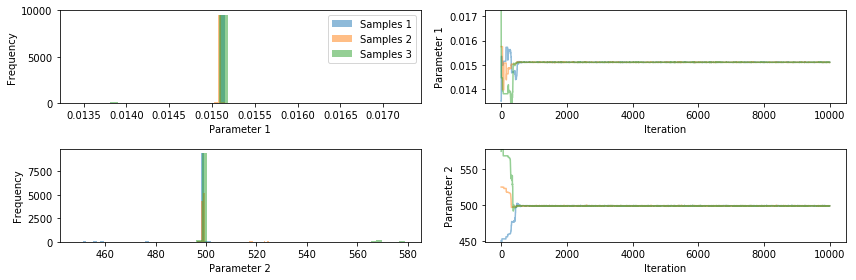

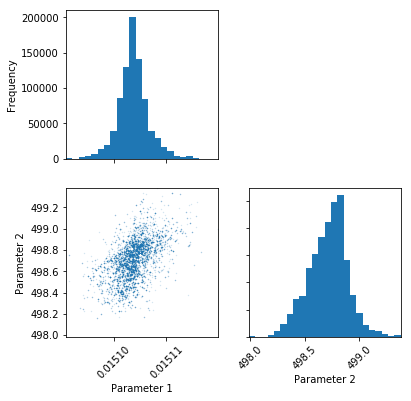

In [27]:
#chains_emu = pints.mcmc_sample(log_posterior_emu, 3, xs)
# Create mcmc routine
mcmc = pints.MCMCController(log_posterior_emu, 3, xs)

# Add stopping criterion
mcmc.set_max_iterations(10000)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains_emu = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(chains_emu)

# Discard warm up
chains_emu_thin = chains_emu[:, 2000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains_emu_thin))

# Look at distribution in chain 0
pints.plot.pairwise(chains_emu_thin[0])

# Show graphs
plt.show()

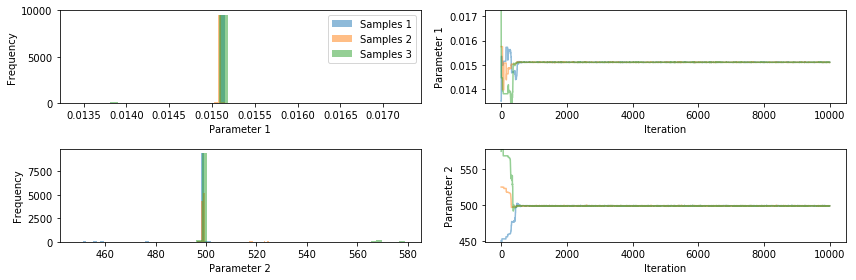

In [28]:
pints.plot.trace(chains_emu)
plt.show()

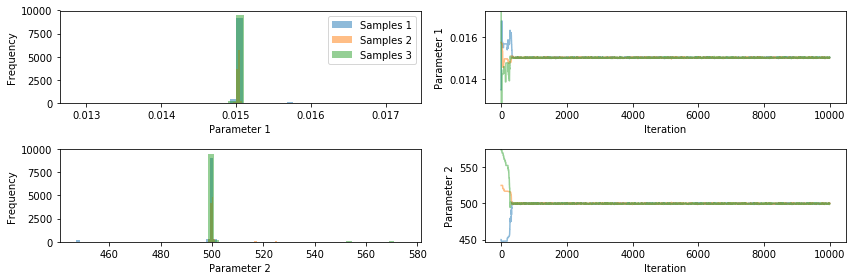

In [29]:
pints.plot.trace(chains)
plt.show()

In [30]:
chain_emu = chains_emu[0]
chain_emu = chain_emu[2000:]
chain = chains[0]
chain = chain[2000:]

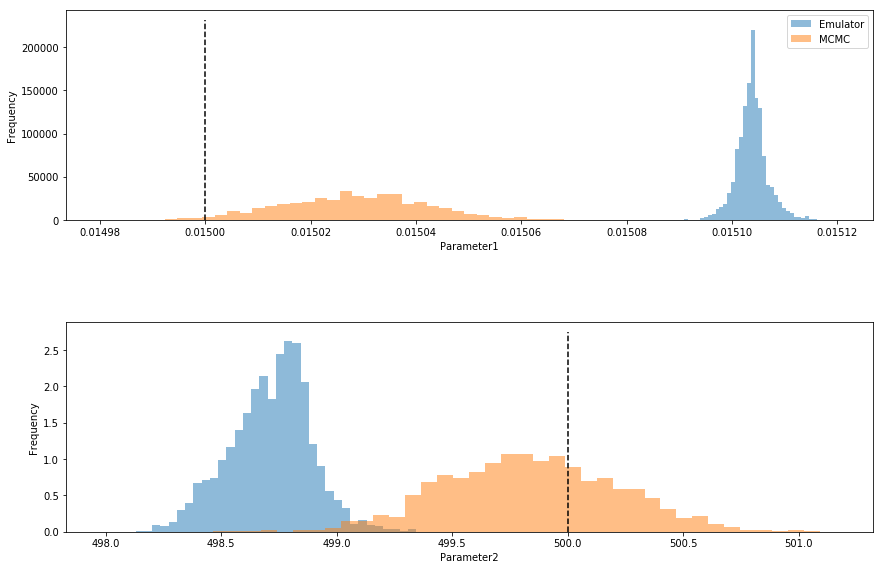

In [31]:
fig, axes = pints.plot.histogram([chain_emu, chain], ref_parameters=true_parameters, sample_names=["Emulator", "MCMC"])
fig.set_size_inches(14, 9)
plt.show()

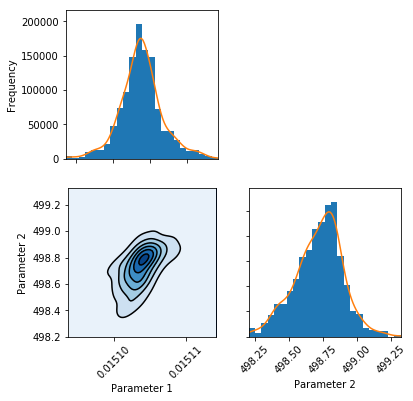

In [32]:
thinned_chain_emu = chain_emu[::10]
pints.plot.pairwise(thinned_chain_emu, kde=True, ref_parameters=true_parameters)
plt.show()

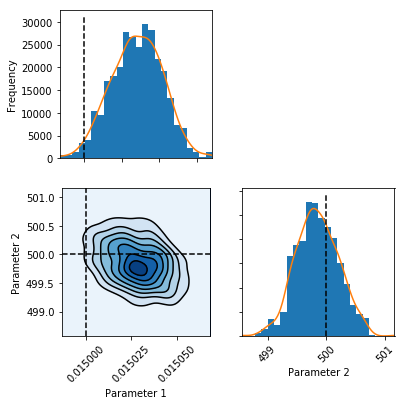

In [33]:
thinned_chain = chain[::10]
pints.plot.pairwise(thinned_chain, kde=True, ref_parameters=true_parameters)
plt.show()

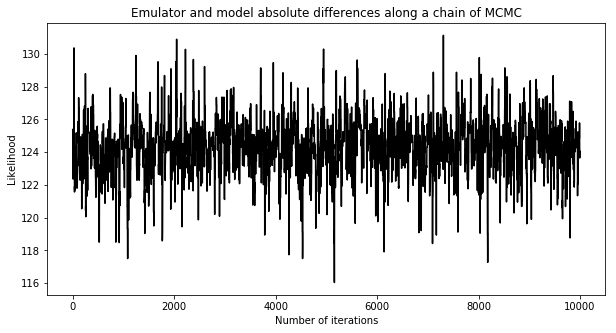

124.04687293128154

In [34]:
emu_prediction = np.apply_along_axis(emu, 1, chain_emu).flatten()
model_prediction = np.apply_along_axis(log_likelihood, 1, chain).flatten()
diffs = np.abs(model_prediction - emu_prediction)

iters = np.linspace(0, 10000, len(chain_emu))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute differences along a chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Likelihood")
plt.plot(iters, diffs, color = "Black")
plt.show()

diffs[-1]

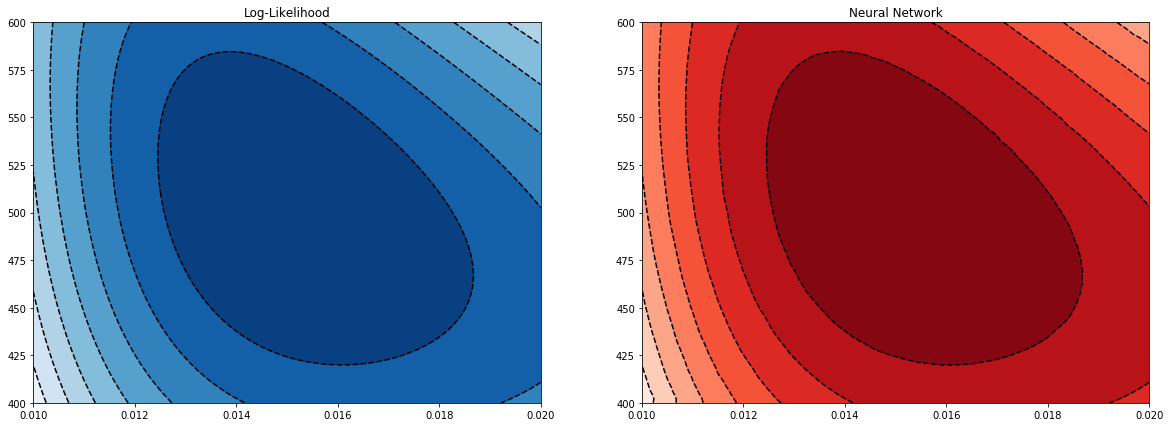

In [35]:
# Create grid
x = [p[0] for p in input_parameters]
y = [p[1] for p in input_parameters]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

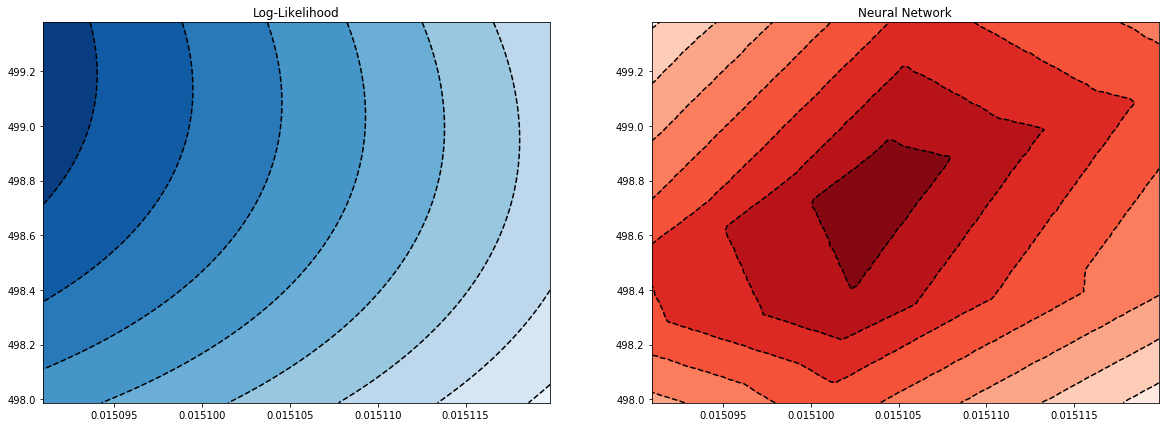

In [36]:
# Create grid
x = [p[0] for p in chain_emu]
y = [p[1] for p in chain_emu]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

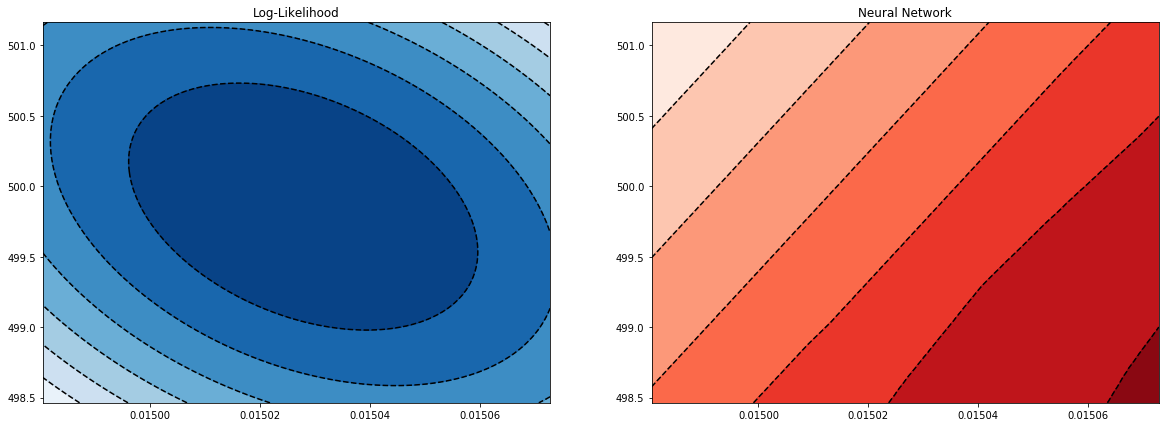

In [37]:
# Create grid
x = [p[0] for p in chain]
y = [p[1] for p in chain]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

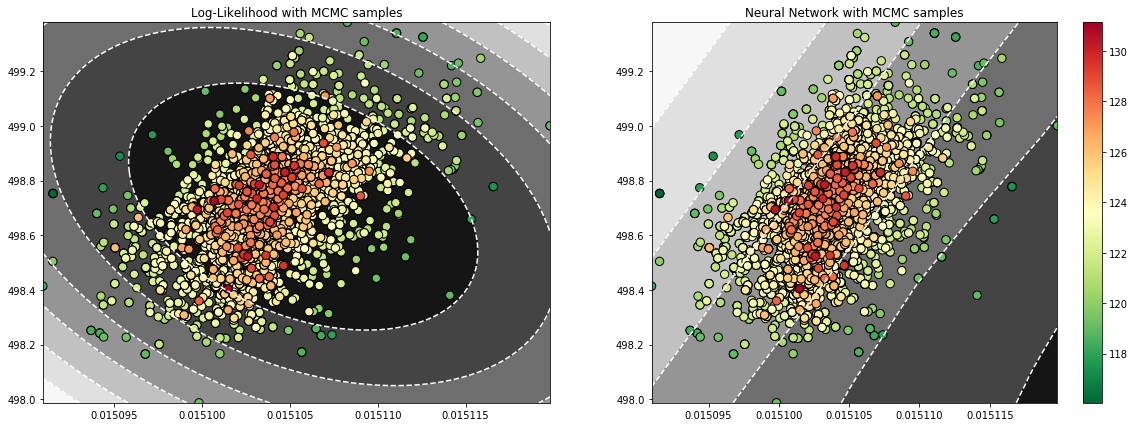

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood with MCMC samples')
ax2.title.set_text('Neural Network with MCMC samples')                                                                  

# Plot chain_emu
x = [p[0] for p in chain_emu]
y = [p[1] for p in chain_emu]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

# Sort according to likelihood error
idx = diffs.argsort()
x_sorted = np.array(x)[idx]
y_sorted = np.array(y)[idx]
diffs_sorted = diffs[idx]

# Add contour lines of log-likelihood
ax1.contourf(xx, yy, ll, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='w')

# Plot chain_emu    
ax1.set_xlim([xmin, xmax])                                                                           
ax1.set_ylim([ymin, ymax])
ax1.scatter(x_sorted, y_sorted, c=diffs_sorted, s=70, edgecolor='k', cmap="RdYlGn_r")

# Add contour lines of emulated likelihood
ax2.contourf(xx, yy, ll_emu, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='w')

# Plot chain_emu    
ax2.set_xlim([xmin, xmax])                                                                           
ax2.set_ylim([ymin, ymax])
im = ax2.scatter(x_sorted, y_sorted, c=diffs_sorted, s=70, edgecolor='k', cmap="RdYlGn_r")
fig.colorbar(im, ax=ax2)
plt.show()

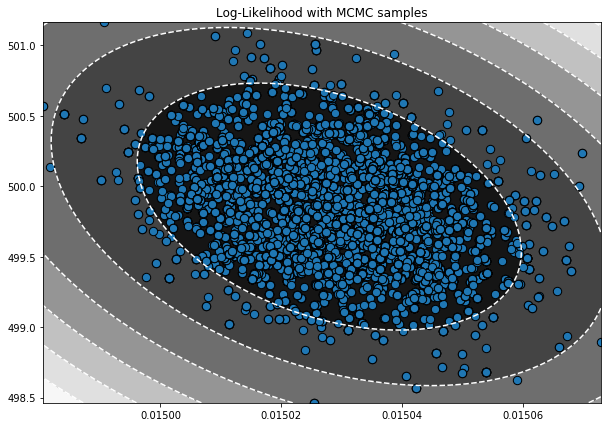

In [39]:
fig, ax = plt.subplots(figsize=(10,7))                   
ax.title.set_text('Log-Likelihood with MCMC samples')

# Show density 
#ax.imshow(np.rot90(ll), cmap=plt.cm.Blues, extent=[xmin, xmax, ymin, ymax])                                                                     

# Plot chain_emu
x = [p[0] for p in chain]
y = [p[1] for p in chain]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

idx = diffs.argsort()
x_sorted = np.array(x)[idx]
y_sorted = np.array(y)[idx]
diffs_sorted = diffs[idx]

# Add contour lines
ax.contourf(xx, yy, ll, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
plt.contour(xx, yy, ll, colors='w')

# Plot chain_emu    
ax.set_xlim([xmin, xmax])                                                                           
ax.set_ylim([ymin, ymax])

ax.scatter(x, y, s=70, edgecolor='k', cmap="RdYlGn_r")
#fig.colorbar(ax)
plt.show()